In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cPickle as pk
import pandas as pd

# PATSTAT Data Checks

# Table of Contents
* [Preliminary Data Munge](#Prelim-Data-Munge)
* [Importing Data](#Importing)
* [Distribution of Patents in Time by Publication Year](#Distribution-of-Patents-by-Pub-Yr)
* [By Publication Year (Split-apply-combine)](#Split-apply-combine-On-Publication-Year)
    * [Distribution Of Patents In Time by Pub Year](#Distribution-in-Time-by-Pub-Check/Practice)
    * [Checking Application Dates](#Checking-Application-Dates)
    * [Checking Classfications](#Checking-Classfications)
* [By Authory-Publication Year (Split-apply-combine)](#Split-apply-combine-On-Authority-And-Publication-Year)
    * [Distribution of Patents In Time by Authority-Pub Year](#Quick–number-of-patents-authority-pub-year)
    * [Checking Application Dates](#Checking-Application-Dates-By-Auth-Year)
    * [Checking IPC Classfications](#Checking-IPC-Classfications-By-Auth)
    * [Checking CPC Classfications](#Checking-CPC-Classfications-By-Auth)

## Prelim Data Munge
[to top](#Table-of-Contents) 

In [2]:
# Take date col. with format 'yyyy-mm-dd' and return that col as int(yyyy)
def d_to_y(col):
    return col.map(lambda x:int(x[:4]))

In [3]:
#Date to years function - works on application date and publication date in one
def date_to_year(df):
    if 'appln_filing_date' in df.columns:
        df.appln_filing_date = df.appln_filing_date.map(lambda x:int(x[:4]))
        df.rename(columns={'appln_filing_date':'app_year'}, inplace=True)
    if 'publn_date'in df.columns:
        df.publn_date = df.publn_date.map(lambda x:int(x[:4]))
        df.rename(columns={'publn_date':'pub_year'}, inplace=True)
    return

In [4]:
# Date to binary is missing or now
def date_to_binary(df, d_col, new_col_name):
    if d_col in df.columns:
        df[d_col] = df[d_col].map( lambda x: 0 if x == 9999 else 1 )
        df.rename(columns={d_col:new_col_name}, inplace=True)
    else: 
        return 'd_col not a column'

## SQL Query used on PATSTAT 2015 Spring

## Importing
[to top](#Table-of-Contents) 

In [5]:
pwd

u'/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Python'

In [6]:
f_all_grants = '/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Data_Play/all_grant_only_prior_flags_v1.csv'

In [7]:
df = pd.read_csv(f_all_grants, engine='c', usecols=[1,2,3,5,6]); df.head()
#dont need ID's

appln_auth  publn_date appln_filing_date  has_ipc  has_cpc
0         US  2009-01-20        2007-01-12        0        0
1         US  2009-01-20        2007-10-18        0        0
2         US  2009-01-20        2008-02-12        0        0
3         US  2009-01-20        2008-07-17        0        0
4         US  2009-01-20        2008-02-21        0        0

In [8]:
# munge dates to years
date_to_year(df); df.head()

appln_auth  pub_year  app_year  has_ipc  has_cpc
0         US      2009      2007        0        0
1         US      2009      2007        0        0
2         US      2009      2008        0        0
3         US      2009      2008        0        0
4         US      2009      2008        0        0

In [9]:
# munge application to year to binary if date is missing (app_year == 9999)
date_to_binary(df, 'app_year', 'has_app_date'); df.head()

appln_auth  pub_year  has_app_date  has_ipc  has_cpc
0         US      2009             1        0        0
1         US      2009             1        0        0
2         US      2009             1        0        0
3         US      2009             1        0        0
4         US      2009             1        0        0

In [10]:
# Find top 6 countries by number of patents, and get list of those autheorties for later
auth_grp = df.groupby('appln_auth')
auth_num = len(auth_grp)
auth_sizes = auth_grp.size()
auth_sizes.sort_values(ascending=False, inplace=True)
print auth_sizes
auth_by_size = auth_sizes.index.values
print auth_by_size
#pk.dump(auth_by_size, open('pickles_and_munged_csv/auth_by_size.pk', 'wb'))
#pk.dump(auth_sizes, open('pickles_and_munged_csv/auth_sizes.pk', 'wb'))

appln_auth
US    5806200
CN    4825616
JP    3551215
DE    1998080
FR    1362220
SU    1310990
KR    1308899
GB    1004759
RU     516833
TW     448047
ES     352867
IT     217647
CH     190787
DD     132214
AT     116268
CS     107047
CA      98969
PL      93645
EP      68315
AU      53686
RO      47082
GR      46679
FI      41436
NL      40443
HU      39793
CZ      31990
SE      31705
BG      30754
ZA      25157
TR      25156
       ...   
SK       2830
GE       2160
LT       2082
EA       1926
SG       1878
HR       1795
EE       1360
OA       1268
MC       1222
MD       1099
JO       1022
IS        934
ZM        766
SM        554
CU        336
ZW        334
TJ        274
MN        222
MT        220
VN        119
HK        106
AP         94
MW         92
ID         88
GC         77
CL         26
BY         25
KE         19
NI         16
BA         11
dtype: int64
['US' 'CN' 'JP' 'DE' 'FR' 'SU' 'KR' 'GB' 'RU' 'TW' 'ES' 'IT' 'CH' 'DD' 'AT'
 'CS' 'CA' 'PL' 'EP' 'AU' 'RO' 'GR' 'FI' 'NL' 

In [11]:
# Get European authority codes
with open('/Users/innovation-sfi/Desktop/eu_auths.txt') as f:
    eu_auths = f.read().splitlines()
# clean off those not contained in patstat
eu_auths = [val for val in auth_by_size if val in eu_auths]
# add 'EP' to the list
eu_auths.insert(0,'EP')
print eu_auths
#pk.dump(eu_auths, open('pickles_and_munged_csv/eu_auths.pk', 'wb'))

['EP', 'DE', 'FR', 'GB', 'ES', 'IT', 'CH', 'AT', 'PL', 'RO', 'GR', 'FI', 'NL', 'HU', 'CZ', 'SE', 'BG', 'TR', 'DK', 'BE', 'NO', 'SI', 'LU', 'IE', 'PT', 'LV', 'SK', 'LT', 'HR', 'EE', 'MC', 'IS', 'SM', 'MT']


## Distribution of Patents by Pub Yr
[to top](#Table-of-Contents) 

In [12]:
yr_min_max_plt = [df.pub_year.min()-2, df.pub_year.max()+2]; #print yr_min_max ADDED 2 buffer years
yr_bins = range(yr_min_max_plt[0], yr_min_max_plt[1]); #print yr_bins

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


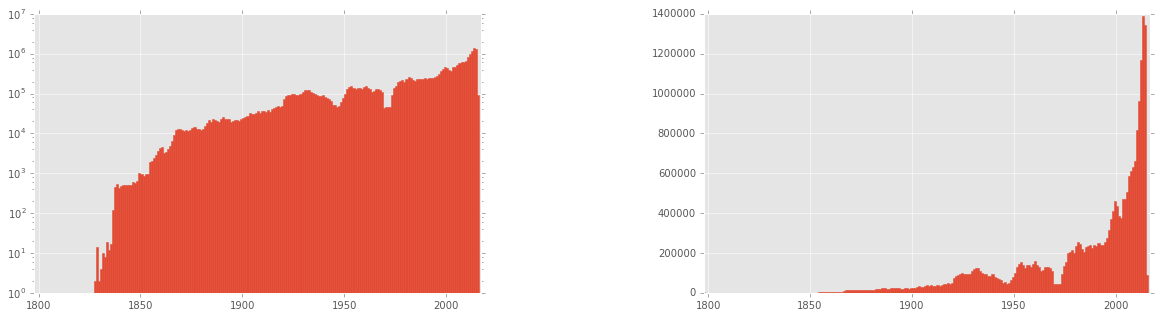

In [13]:
#Complete set

fig, axes = plt.subplots(nrows=1, ncols=2)

clr1 = plt.rcParams['axes.color_cycle'][0]

df['pub_year'].hist(ax=axes[0], bins=yr_bins, log=True, edgecolor=clr1)
df['pub_year'].hist(ax=axes[1], bins=yr_bins, log=False, edgecolor=clr1)

for ax in axes:
    ax.set_xlim(yr_min_max_plt)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(20,5)

# print plt.rcParams['axes.color_cycle'][0] : #E24A33


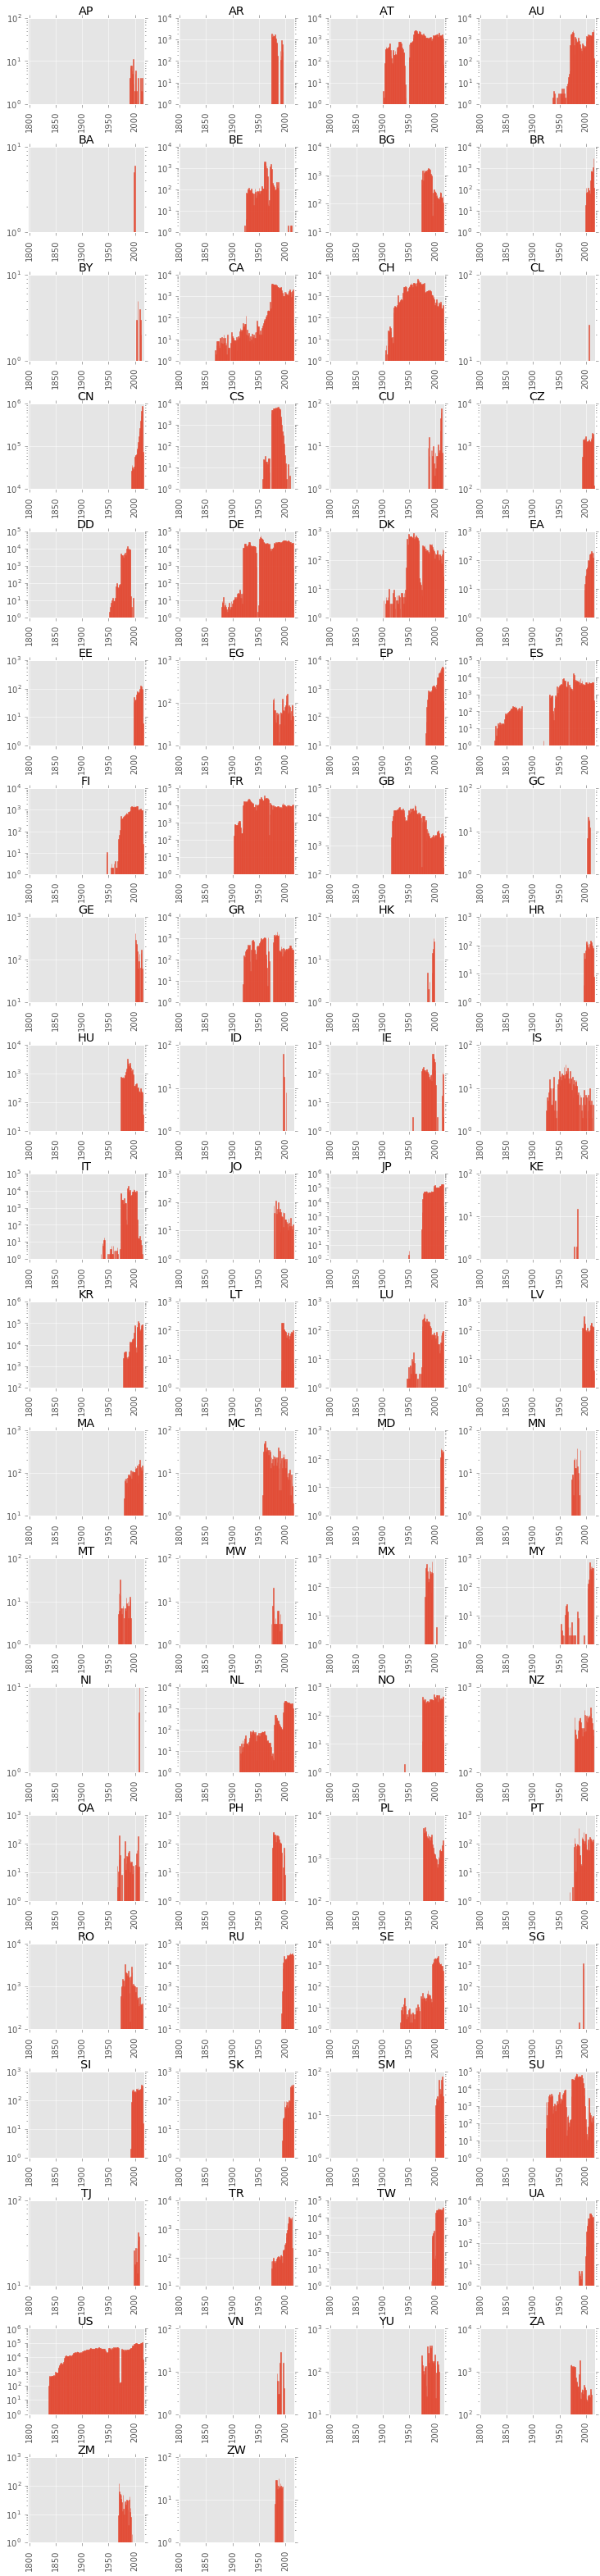

In [14]:
#Grouped by country NOT LOG

col = 4
w = 3
h = 3

axes = df['pub_year'].hist(by=df['appln_auth'], bins=yr_bins, log=True, edgecolor=clr1, 
                           figsize=((col * w),((auth_num / col) * h)), layout=((auth_num / col)+1,col))
for row in axes:
    for ax in row:
        ax.set_xlim(yr_min_max_plt)
#plt.subplots_adjust(wspace=0.5, hspace=1)
#plt.savefig('figures/bad_hist.pdf')

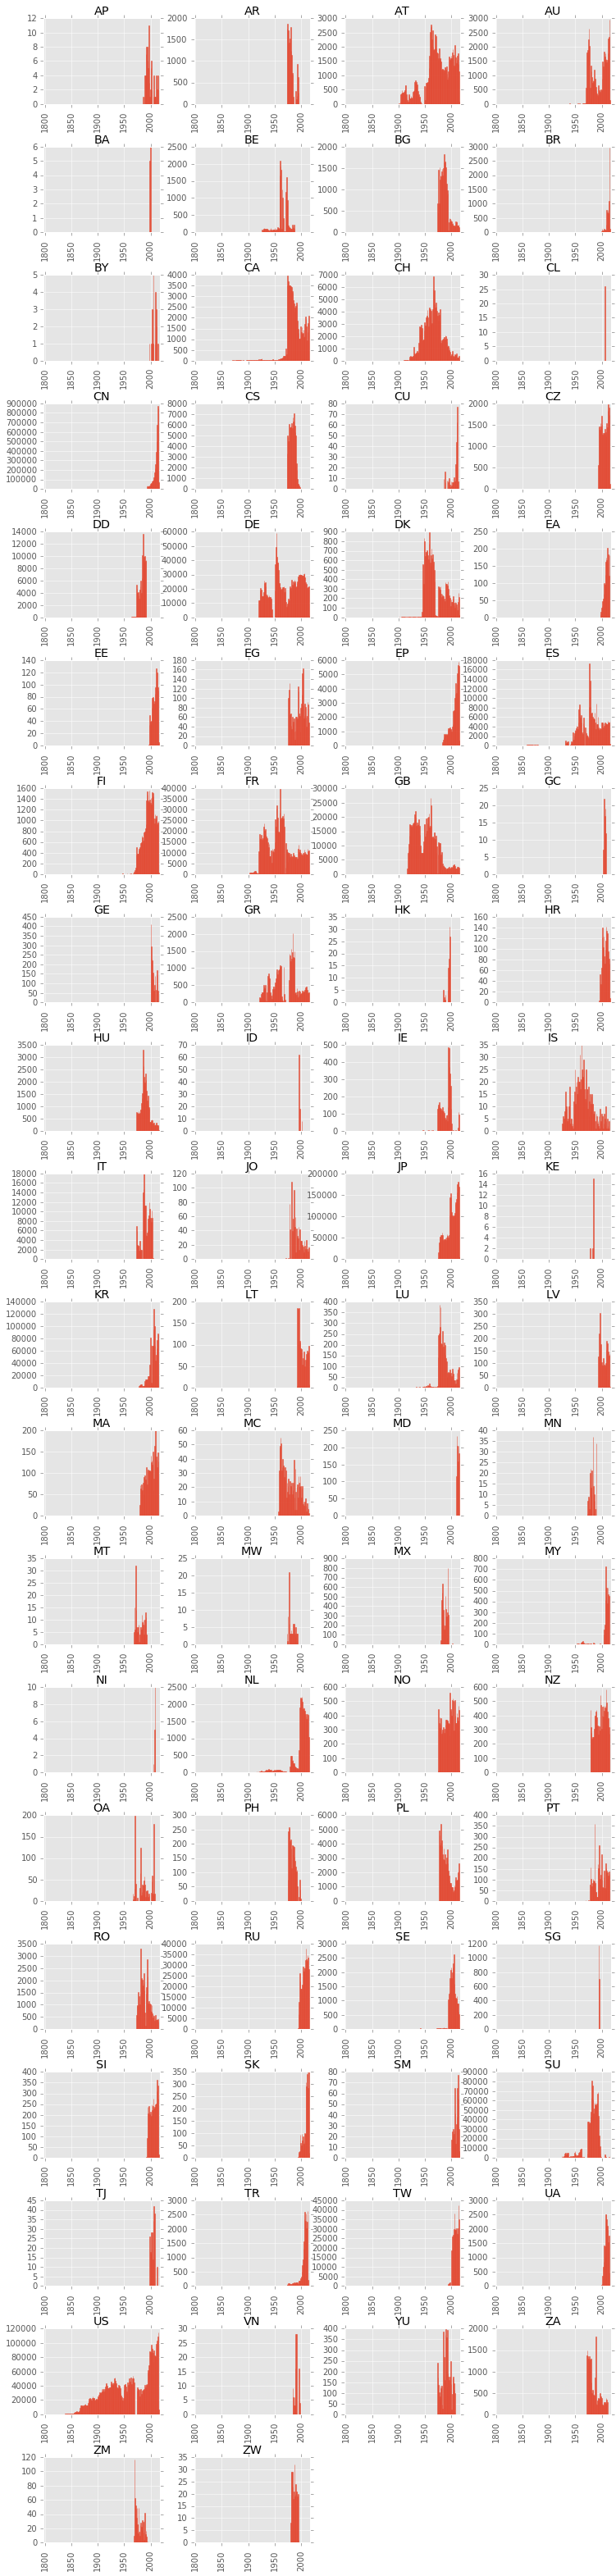

In [15]:
#Grouped by country LOG

axes = df['pub_year'].hist(by=df['appln_auth'], bins=yr_bins, log=False, edgecolor=clr1, 
                           figsize=((col * w),((auth_num / col) * h)), layout=((auth_num / col)+1,col))

for row in axes:
    for ax in row:
        ax.set_xlim(yr_min_max_plt)
#plt.subplots_adjust(wspace=0.5, hspace=1)
#plt.savefig('figures/bad_hist.pdf')

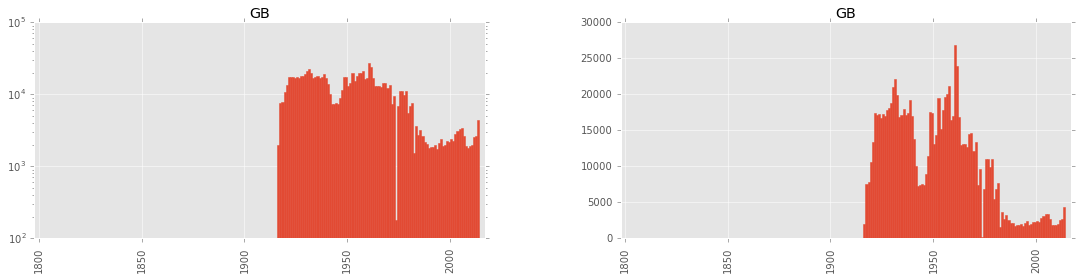

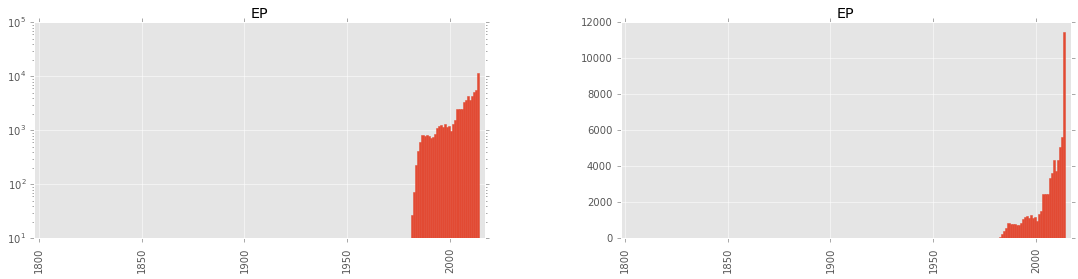

In [16]:
# For top 6

yr_min_max = [df.pub_year.min(), df.pub_year.max()]; #print yr_min_max
yr_bins = range(yr_min_max[0], yr_min_max[1]); #print yr_bins

for auth in ['GB', 'EP']:
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    df[df['appln_auth'] == auth]['pub_year'].hist(by=df['appln_auth'], ax=axes[0], log=True,
                                                  bins=yr_bins, edgecolor=clr1)
    df[df['appln_auth'] == auth]['pub_year'].hist(by=df['appln_auth'], ax=axes[1], log=False,
                                                  bins=yr_bins, edgecolor=clr1)
    for ax in axes:
        ax.set_xlim(yr_min_max_plt)
        #plt.subplots_adjust(wspace=0.5)
    
    fig.set_size_inches(18,4)

## Split-apply-combine On Publication Year
[to top](#Table-of-Contents)

##### Split

In [17]:
grp_pb_year = df.groupby('pub_year')

##### Apply

In [18]:
# Make Series with number of pubs per year
s_pub_num = grp_pb_year.size()
s_pub_num.name = 'num'
print s_pub_num

# Need to fill out missing years with 0s DONT THINK YOU NEED THIS BIT, just let the gaps be there
full_index = range(s_pub_num.index[0], s_pub_num.index[-1]+1)
s_pub_num = s_pub_num.reindex(full_index, fill_value=0)
s_pub_num.head()

pub_year
1800          1
1827          2
1828         14
1829          2
1830          4
1831         10
1832          8
1833         19
1834         12
1835         17
1836        121
1837        458
1838        530
1839        423
1840        470
1841        506
1842        508
1843        513
1844        496
1845        506
1846        620
1847        570
1848        655
1849       1042
1850        936
1851        841
1852        973
1853        935
1854       1863
1855       1986
         ...   
1986     234309
1987     237973
1988     226737
1989     238285
1990     236185
1991     248524
1992     242138
1993     239046
1994     257111
1995     273987
1996     315699
1997     369373
1998     408670
1999     462333
2000     435186
2001     386711
2002     376808
2003     471792
2004     468859
2005     505459
2006     585376
2007     613655
2008     629513
2009     660839
2010     819105
2011     960336
2012    1168699
2013    1389220
2014    1344466
2015      89593
Name: num, dtyp

pub_year
1800    1
1801    0
1802    0
1803    0
1804    0
Name: num, dtype: int64

In [19]:
# Make series with number of ipc/cpc/ per pub year
s_pub_ipc = grp_pb_year.has_ipc.sum() ; print s_pub_ipc.head()
s_pub_ipc.name = 'num_ipc'#; print s_pub_ipc.head()
s_pub_cpc = grp_pb_year.has_cpc.sum() 
s_pub_cpc.name ='num_cpc'#; print s_pub_cpc
s_pub_app = grp_pb_year.has_app_date.sum() 
s_pub_app.name = 'num_app'#; print s_pub_app

pub_year
1800    0
1827    0
1828    0
1829    0
1830    0
Name: has_ipc, dtype: int64


#### Combine

In [20]:
# Concate into new dataframe and replace NaN with 0s for completeness
pub_df = pd.concat([s_pub_num, s_pub_app, s_pub_ipc, s_pub_cpc], axis=1)
pub_df = pub_df.fillna(0); pub_df

num  num_app  num_ipc  num_cpc
pub_year                                    
1800            1        0        0        1
1801            0        0        0        0
1802            0        0        0        0
1803            0        0        0        0
1804            0        0        0        0
1805            0        0        0        0
1806            0        0        0        0
1807            0        0        0        0
1808            0        0        0        0
1809            0        0        0        0
1810            0        0        0        0
1811            0        0        0        0
1812            0        0        0        0
1813            0        0        0        0
1814            0        0        0        0
1815            0        0        0        0
1816            0        0        0        0
1817            0        0        0        0
1818            0        0        0        0
1819            0        0        0        0
1820            0        0        0        0
1821            0        0        0        0
1822            0        0        0        0
1823            0        0        0        0
1824            0        0        0        0
1825            0        0        0        0
1826            0        0        0        0
1827            2        2        0        0
1828           14       14        0        0
1829            2        2        0        0
...           ...      ...      ...      ...
1986       234309   233782   230626    84249
1987       237973   237562   234415    89808
1988       226737   226443   224706    84156
1989       238285   238092   234581    88960
1990       236185   235651   232165    84336
1991       248524   248066   246961    86698
1992       242138   241639   240653    86511
1993       239046   238693   237336    88829
1994       257111   256825   255283   114966
1995       273987   273602   272213   121123
1996       315699   315368   313177   138794
1997       369373   368939   367480   150923
1998       408670   408398   406730   171057
1999       462333   461976   459707   172415
2000       435186   434792   433263   164713
2001       386711   386132   370943   163388
2002       376808   376687   361918   160469
2003       471792   471792   454036   168977
2004       468859   468859   451571   163733
2005       505459   505459   492702   159103
2006       585376   585376   564018   184010
2007       613655   613655   591126   179262
2008       629513   629513   607692   172907
2009       660839   660839   640919   178073
2010       819105   819105   800142   207164
2011       960336   960336   943497   213209
2012      1168699  1168699  1151252   234693
2013      1389220  1389220  1370345   247568
2014      1344466  1344466  1323949   238860
2015        89593    89593    88512    10627

[216 rows x 4 columns]

In [21]:
# Process into new dataframe of fractional quantities ready to plot, for zero entries used 1

pub_frac_df = pub_df[['num_app', 'num_ipc', 'num_cpc']].div(pub_df['num'], axis='index')
pub_frac_df.fillna(0, inplace=True) 
pub_frac_df.rename(columns={key: key.replace("num", 'frac') for key in pub_frac_df.columns}, inplace=True)
pub_frac_df

frac_app  frac_ipc  frac_cpc
pub_year                              
1800      0.000000  0.000000  1.000000
1801      0.000000  0.000000  0.000000
1802      0.000000  0.000000  0.000000
1803      0.000000  0.000000  0.000000
1804      0.000000  0.000000  0.000000
1805      0.000000  0.000000  0.000000
1806      0.000000  0.000000  0.000000
1807      0.000000  0.000000  0.000000
1808      0.000000  0.000000  0.000000
1809      0.000000  0.000000  0.000000
1810      0.000000  0.000000  0.000000
1811      0.000000  0.000000  0.000000
1812      0.000000  0.000000  0.000000
1813      0.000000  0.000000  0.000000
1814      0.000000  0.000000  0.000000
1815      0.000000  0.000000  0.000000
1816      0.000000  0.000000  0.000000
1817      0.000000  0.000000  0.000000
1818      0.000000  0.000000  0.000000
1819      0.000000  0.000000  0.000000
1820      0.000000  0.000000  0.000000
1821      0.000000  0.000000  0.000000
1822      0.000000  0.000000  0.000000
1823      0.000000  0.000000  0.000000
1824      0.000000  0.000000  0.000000
1825      0.000000  0.000000  0.000000
1826      0.000000  0.000000  0.000000
1827      1.000000  0.000000  0.000000
1828      1.000000  0.000000  0.000000
1829      1.000000  0.000000  0.000000
...            ...       ...       ...
1986      0.997751  0.984281  0.359564
1987      0.998273  0.985049  0.377387
1988      0.998703  0.991042  0.371161
1989      0.999190  0.984456  0.373334
1990      0.997739  0.982979  0.357076
1991      0.998157  0.993711  0.348852
1992      0.997939  0.993867  0.357280
1993      0.998523  0.992847  0.371598
1994      0.998888  0.992890  0.447145
1995      0.998595  0.993525  0.442076
1996      0.998952  0.992011  0.439640
1997      0.998825  0.994875  0.408592
1998      0.999334  0.995253  0.418570
1999      0.999228  0.994320  0.372924
2000      0.999095  0.995581  0.378489
2001      0.998503  0.959225  0.422507
2002      0.999679  0.960484  0.425864
2003      1.000000  0.962365  0.358160
2004      1.000000  0.963128  0.349216
2005      1.000000  0.974762  0.314769
2006      1.000000  0.963514  0.314345
2007      1.000000  0.963287  0.292122
2008      1.000000  0.965337  0.274668
2009      1.000000  0.969857  0.269465
2010      1.000000  0.976849  0.252915
2011      1.000000  0.982466  0.222015
2012      1.000000  0.985071  0.200816
2013      1.000000  0.986413  0.178206
2014      1.000000  0.984740  0.177662
2015      1.000000  0.987934  0.118614

[216 rows x 3 columns]

### Distribution in Time by Pub Check/Practice
[to top](#Table-of-Contents)

(1798, 2017)

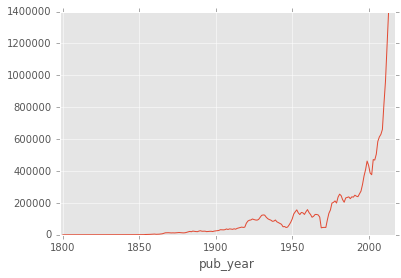

In [22]:
pub_df.num[:-2].plot()
plt.xlim(yr_min_max_plt)

## Checking Application Dates
[to top](#Table-of-Contents)

(-0.1, 1.1)

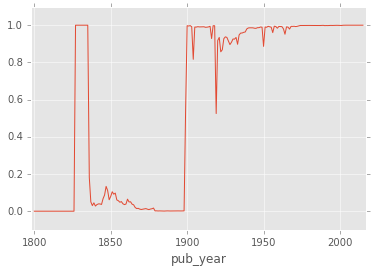

In [23]:
pub_frac_df.frac_app.plot()
plt.xlim(yr_min_max_plt)
plt.ylim(-0.1, 1.1)

## Checking Classfications 
[to top](#Table-of-Contents)

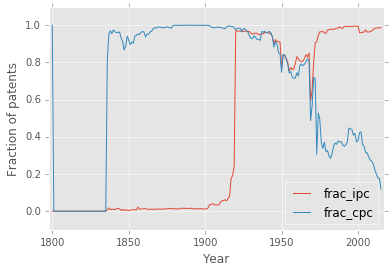

In [24]:
pub_frac_df[['frac_ipc','frac_cpc']].plot()
plt.xlim(yr_min_max_plt)
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

#plt.savefig('figures/frac_class_year.png')

# Split-apply-combine On Authority And Publication Year
[to top](#Table-of-Contents)

#### Split

In [25]:
grp_auth_year = df.groupby(['appln_auth', 'pub_year'])

#### Apply

In [26]:
s_au_year_num = grp_auth_year.size()
s_au_year_num.name = 'num'
s_au_year_app = grp_auth_year.has_app_date.sum()
s_au_year_app.name = 'num_app'
s_au_year_ipc = grp_auth_year.has_ipc.sum()
s_au_year_ipc.name = 'num_ipc'
s_au_year_cpc = grp_auth_year.has_cpc.sum()
s_au_year_cpc.name = 'num_cpc'

In [27]:
# pickle s_au_year_num
#pk.dump(s_au_year_num, open('pickles_and_munged_csv/s_au_year_num.pk', 'wb'))

## Quick number of patents authority-pub-year
[to top](#Table-of-Contents)

In [28]:
s_au_year_num_piv = s_au_year_num.reset_index(level=0).pivot(columns='appln_auth',values='num')

(1798, 2017)

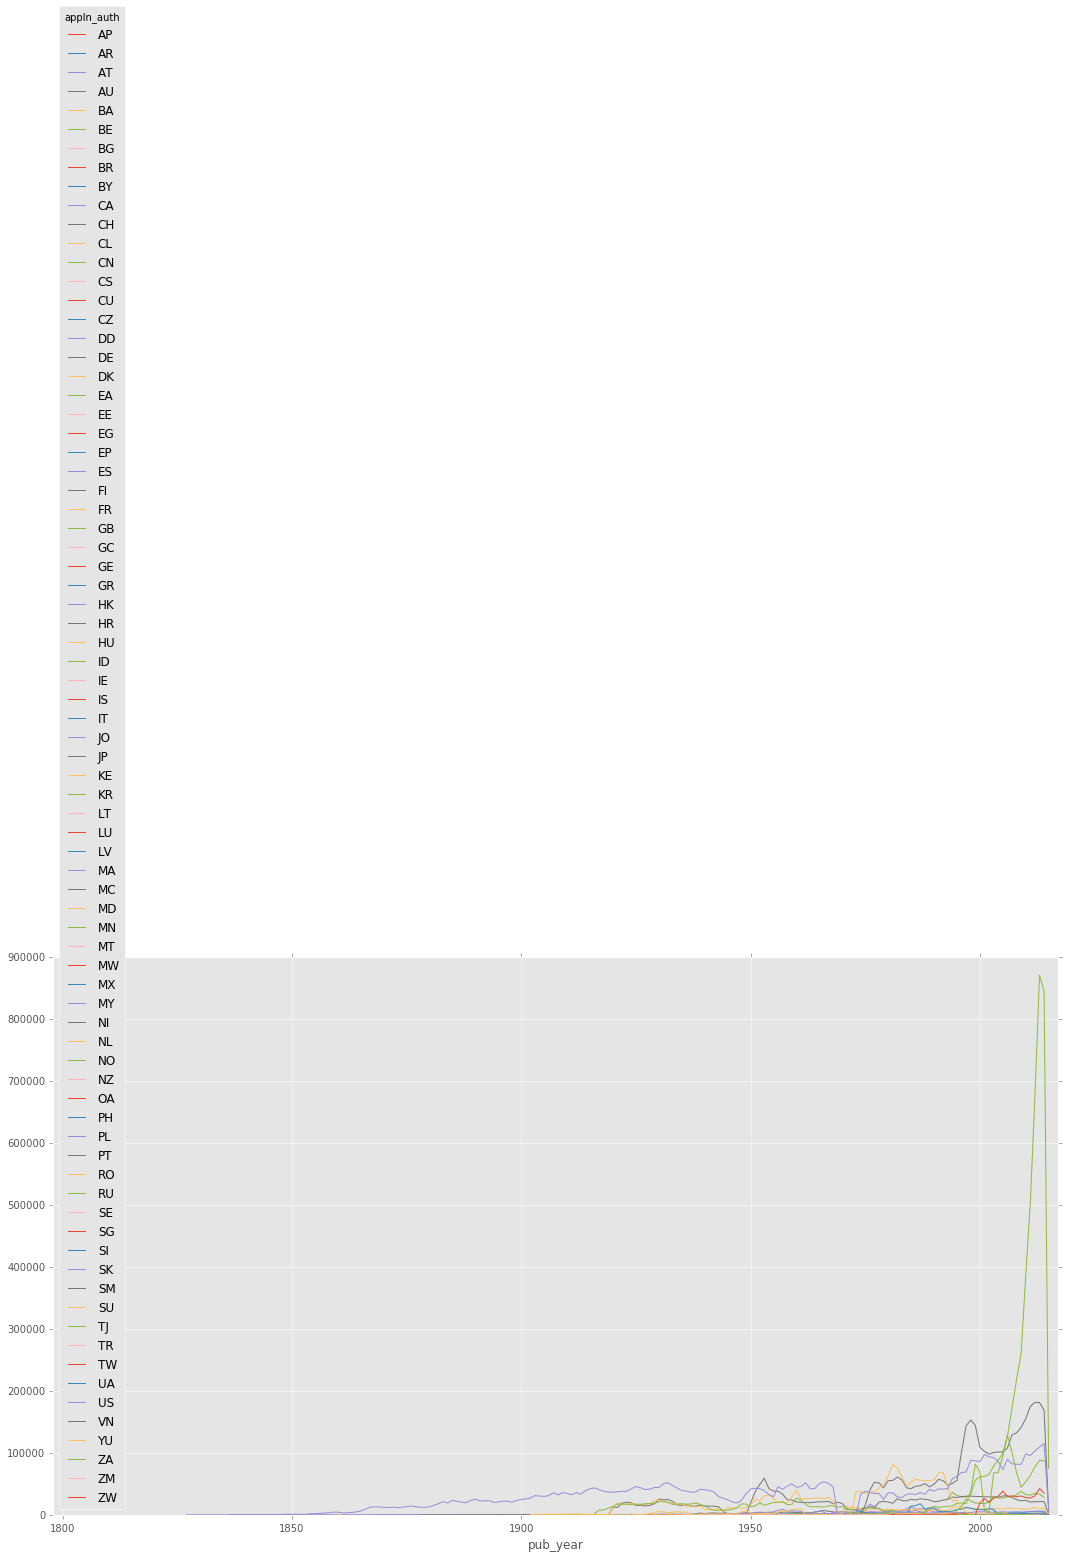

In [29]:
s_au_year_num_piv.plot(figsize=(18,10))
plt.xlim(yr_min_max_plt)

(1798, 2017)

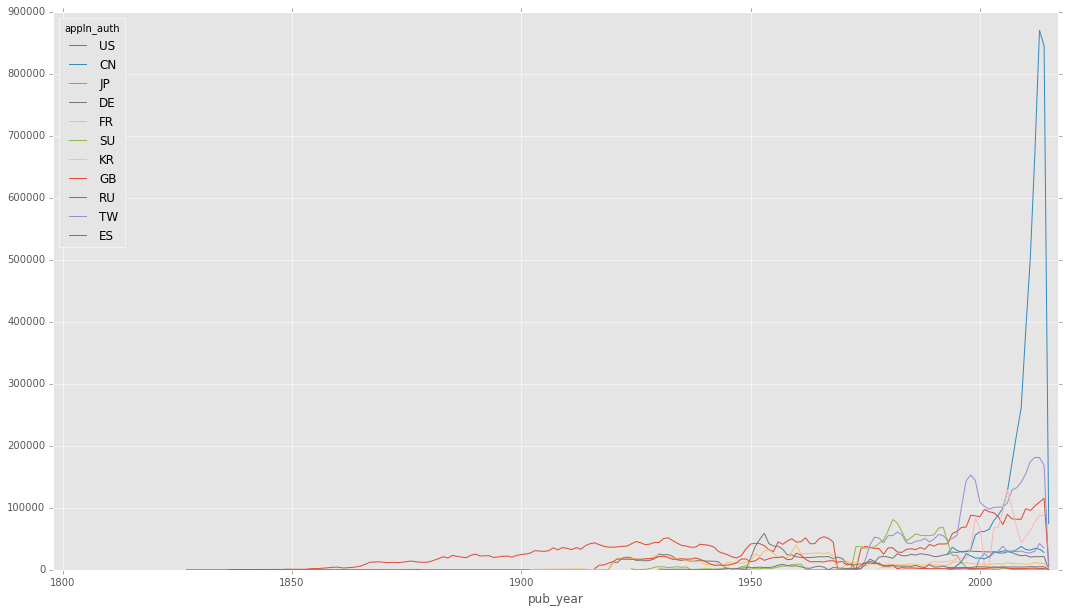

In [30]:
s_au_year_num_piv[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(yr_min_max_plt)

(1798, 2017)

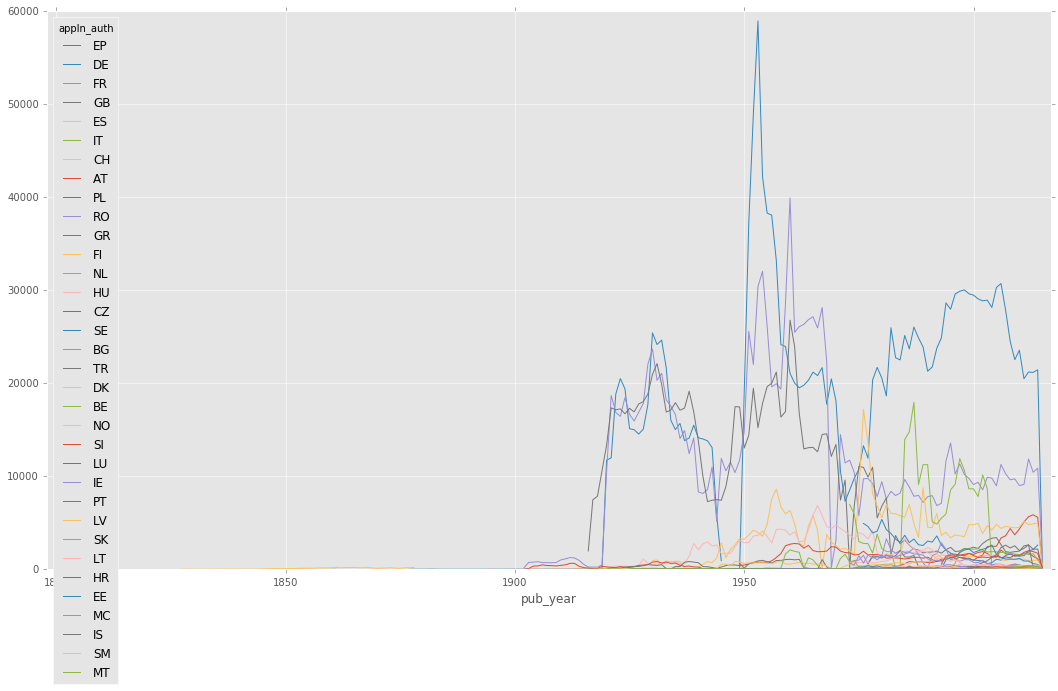

In [31]:
s_au_year_num_piv[eu_auths].plot(figsize=(18,10))
plt.xlim(yr_min_max_plt)

### Combine

In [32]:
# Concate into new dataframe
df_au_year_num = pd.concat([s_au_year_num,s_au_year_app,s_au_year_ipc,s_au_year_cpc], axis=1)
df_au_year_num.fillna(0, inplace=True); df_au_year_num.head()

num  num_app  num_ipc  num_cpc
appln_auth pub_year                                
AP         1985        1        1        1        1
           1988        1        1        1        1
           1989        4        4        4        4
           1990        4        4        4        4
           1991        7        7        7        7

In [33]:
df_au_year_num_10 = df_au_year_num[df_au_year_num > 10]; df_au_year_num_10

num  num_app  num_ipc  num_cpc
appln_auth pub_year                                 
AP         1985       NaN      NaN      NaN      NaN
           1988       NaN      NaN      NaN      NaN
           1989       NaN      NaN      NaN      NaN
           1990       NaN      NaN      NaN      NaN
           1991       NaN      NaN      NaN      NaN
           1992       NaN      NaN      NaN      NaN
           1993       NaN      NaN      NaN      NaN
           1994       NaN      NaN      NaN      NaN
           1995       NaN      NaN      NaN      NaN
           1996        11       11       11       11
           1997       NaN      NaN      NaN      NaN
           1998       NaN      NaN      NaN      NaN
           1999       NaN      NaN      NaN      NaN
           2000       NaN      NaN      NaN      NaN
           2001       NaN      NaN      NaN      NaN
           2002       NaN      NaN      NaN      NaN
           2005       NaN      NaN      NaN      NaN
           2006       NaN      NaN      NaN      NaN
           2007       NaN      NaN      NaN      NaN
           2008       NaN      NaN      NaN      NaN
           2009       NaN      NaN      NaN      NaN
           2010       NaN      NaN      NaN      NaN
           2012       NaN      NaN      NaN      NaN
           2013       NaN      NaN      NaN      NaN
           2014       NaN      NaN      NaN      NaN
AR         1965       NaN      NaN      NaN      NaN
           1973      1748     1748       43       25
           1974      1862     1862      141       29
           1975      1408     1408     1245       20
           1976      1712     1712     1381       29
...                   ...      ...      ...      ...
ZM         1980        24       24       22      NaN
           1981        28       28       21      NaN
           1982        22       22       17      NaN
           1983        18       18       16      NaN
           1984        31       31       28      NaN
           1985        29       29       27      NaN
           1986        14       14       12      NaN
           1987       NaN      NaN      NaN      NaN
           1988        31       31       30      NaN
           1989        42       42       37      NaN
           1990        12       12       12      NaN
           1991        17       17       16      NaN
           1992       NaN      NaN      NaN      NaN
           1994       NaN      NaN      NaN      NaN
ZW         1980       NaN      NaN      NaN      NaN
           1981        29       29       27      NaN
           1982        29       29       28      NaN
           1983        29       29       26      NaN
           1984        23       23       23      NaN
           1985        18       18       18      NaN
           1986        21       21       21      NaN
           1987        32       32       32      NaN
           1988        19       19       19      NaN
           1989        20       20       20      NaN
           1990        24       24       23      NaN
           1991        21       21       21      NaN
           1992        21       21       20      NaN
           1993        19       19       19      NaN
           1994        20       20       19      NaN
           1995       NaN      NaN      NaN      NaN

[3488 rows x 4 columns]

In [34]:
# Process into new dataframe of fractional quantities ready to plot, for zero entries used 1

df_au_year_frac = df_au_year_num[['num_app', 'num_ipc', 'num_cpc']].div(df_au_year_num['num'], axis='index')
df_au_year_frac.fillna(0, inplace=True) 
df_au_year_frac.rename(columns={key: key.replace("num", 'frac') for key in df_au_year_frac.columns}, inplace=True)
df_au_year_frac.head()

frac_app  frac_ipc  frac_cpc
appln_auth pub_year                              
AP         1985             1         1         1
           1988             1         1         1
           1989             1         1         1
           1990             1         1         1
           1991             1         1         1

In [35]:
# Process into new dataframe of fractional quantities ready to plot, for zero entries used 1

df_au_year_frac_10 = df_au_year_num_10[['num_app', 'num_ipc', 'num_cpc']].div(df_au_year_num_10['num'], axis='index')
df_au_year_frac_10.fillna(0, inplace=True) 
df_au_year_frac_10.rename(columns={key: key.replace("num", 'frac') for key in df_au_year_frac_10.columns}, inplace=True)
df_au_year_frac_10

frac_app  frac_ipc  frac_cpc
appln_auth pub_year                              
AP         1985             0  0.000000  0.000000
           1988             0  0.000000  0.000000
           1989             0  0.000000  0.000000
           1990             0  0.000000  0.000000
           1991             0  0.000000  0.000000
           1992             0  0.000000  0.000000
           1993             0  0.000000  0.000000
           1994             0  0.000000  0.000000
           1995             0  0.000000  0.000000
           1996             1  1.000000  1.000000
           1997             0  0.000000  0.000000
           1998             0  0.000000  0.000000
           1999             0  0.000000  0.000000
           2000             0  0.000000  0.000000
           2001             0  0.000000  0.000000
           2002             0  0.000000  0.000000
           2005             0  0.000000  0.000000
           2006             0  0.000000  0.000000
           2007             0  0.000000  0.000000
           2008             0  0.000000  0.000000
           2009             0  0.000000  0.000000
           2010             0  0.000000  0.000000
           2012             0  0.000000  0.000000
           2013             0  0.000000  0.000000
           2014             0  0.000000  0.000000
AR         1965             0  0.000000  0.000000
           1973             1  0.024600  0.014302
           1974             1  0.075725  0.015575
           1975             1  0.884233  0.014205
           1976             1  0.806659  0.016939
...                       ...       ...       ...
ZM         1980             1  0.916667  0.000000
           1981             1  0.750000  0.000000
           1982             1  0.772727  0.000000
           1983             1  0.888889  0.000000
           1984             1  0.903226  0.000000
           1985             1  0.931034  0.000000
           1986             1  0.857143  0.000000
           1987             0  0.000000  0.000000
           1988             1  0.967742  0.000000
           1989             1  0.880952  0.000000
           1990             1  1.000000  0.000000
           1991             1  0.941176  0.000000
           1992             0  0.000000  0.000000
           1994             0  0.000000  0.000000
ZW         1980             0  0.000000  0.000000
           1981             1  0.931034  0.000000
           1982             1  0.965517  0.000000
           1983             1  0.896552  0.000000
           1984             1  1.000000  0.000000
           1985             1  1.000000  0.000000
           1986             1  1.000000  0.000000
           1987             1  1.000000  0.000000
           1988             1  1.000000  0.000000
           1989             1  1.000000  0.000000
           1990             1  0.958333  0.000000
           1991             1  1.000000  0.000000
           1992             1  0.952381  0.000000
           1993             1  1.000000  0.000000
           1994             1  0.950000  0.000000
           1995             0  0.000000  0.000000

[3488 rows x 3 columns]

In [36]:
# Pivot on authorieties (need to unindex it first)
df_au_year_frac_pv = df_au_year_frac.reset_index(level=0).pivot(columns='appln_auth')
df_au_year_frac_pv.fillna(1, inplace=True) # made value for year with no patents equal to 1 i.e non are missing
df_au_year_frac_pv

frac_app                                      ...     frac_cpc  \
appln_auth       AP AR AT AU BA BE BG BR BY        CA    ...           TJ   
pub_year                                                 ...                
1800              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1827              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1828              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1829              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1830              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1831              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1832              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1833              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1834              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1835              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1836              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1837              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1838              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1839              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1840              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1841              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1842              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1843              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1844              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1845              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1846              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1847              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1848              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1849              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1850              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1851              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1852              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1853              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1854              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
1855              1  1  1  1  1  1  1  1  1  1.000000    ...     1.000000   
...             ... .. .. .. .. .. .. .. ..       ...    ...          ...   
1986              1  1  1  1  1  1  1  1  1  0.802103    ...     1.000000   
1987              1  1  1  1  1  1  1  1  1  0.819182    ...     1.000000   
1988              1  1  1  1  1  1  1  1  1  0.881232    ...     1.000000   
1989              1  1  1  1  1  1  1  1  1  0.920934    ...     1.000000   
1990              1  1  1  1  1  1  1  1  1  0.789598    ...     1.000000   
1991              1  1  1  1  1  1  1  1  1  0.830871    ...     1.000000   
1992              1  1  1  1  1  1  1  1  1  0.811413    ...     1.000000   
1993              1  1  1  1  1  1  1  1  1  0.811633    ...     1.000000   
1994              1  1  1  1  1  1  1  1  1  0.806364    ...     1.000000   
1995              1  1  1  1  1  1  1  1  1  0.703390    ...     1.000000   
1996              1  1  1  1  1  1  1  1  1  0.678952    ...     1.000000   
1997              1  1  1  1  1  1  1  1  1  0.578641    ...     1.000000   
1998              1  1  1  1  1  1  1  1  1  0.747212    ...     0.038462   
1999              1  1  1  1  1  1  1  1  1  0.773764    ...     0.000000   
2000              1  1  1  1  1  1  1  1  1  0.705751    ...     0.000000   
2001              1  1  1  1  1  1  1  1  1  0.632614    ...     0.000000   
2002              1  1  1  1  1  1  1  1  1  0.903432    ...     0.000000   
2003              1  1  1  1  1  1  1  1  1  1.000000    ...     0.035714   
2004   

In [37]:
# Pivot on authorieties (need to unindex it first)
df_au_year_frac_10_pv = df_au_year_frac_10.reset_index(level=0).pivot(columns='appln_auth')
df_au_year_frac_10_pv.fillna(0, inplace=True) # made value for year with no patents equal to 1 i.e non are missing
df_au_year_frac_10_pv

frac_app                                   ... frac_cpc            \
appln_auth       AP AR AT AU BA BE BG BR BY        CA ...       TJ        TR   
pub_year                                              ...                      
1800              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1827              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1828              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1829              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1830              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1831              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1832              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1833              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1834              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1835              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1836              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1837              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1838              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1839              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1840              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1841              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1842              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1843              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1844              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1845              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1846              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1847              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1848              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1849              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1850              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1851              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1852              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1853              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1854              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
1855              0  0  0  0  0  0  0  0  0  0.000000 ...        0  0.000000   
...             ... .. .. .. .. .. .. .. ..       ... ...      ...       ...   
1986              0  0  1  1  0  1  1  0  0  0.802103 ...        0  0.000000   
1987              0  0  1  1  0  1  1  0  0  0.819182 ...        0  0.000000   
1988              0  0  1  1  0  0  1  0  0  0.881232 ...        0  0.000000   
1989              0  0  1  1  0  0  1  0  0  0.920934 ...        0  0.000000   
1990              0  1  1  1  0  0  1  0  0  0.789598 ...        0  0.000000   
1991              0  1  1  1  0  0  1  0  0  0.830871 ...        0  0.000000   
1992              0  1  1  1  0  0  1  0  0  0.811413 ...        0  0.000000   
1993              0  1  1  1  0  0  1  0  0  0.811633 ...        0  0.000000   
1994              0  1  1  1  0  0  1  0  0  0.806364 ...        0  0.000000   
1995              0  1  1  1  0  0  1  0  0  0.703390 ...        0  0.000000   
1996              1  0  1  1  0  0  1  0  0  0.678952 ...        0  0.000000   
1997              0  0  1  1  0  0  1  0  0  0.578641 ...        0  0.000000   
1998              0  0  1  1  0  0  1  0  0  0.747212 ...        0  0.000000   
1999              0  0  1  1  0  0  1  1  0  0.773764 ...        0  0.000000   
2000              0  0  1  1  0  0  1  1  0  0.705751 ...        0  0.000000   
2001              0  0  1  1  0  0  1  1  0  0.632614 ...        0  0.000000   
2002       

## Checking Application Dates By Auth-Year
[to top](#Table-of-Contents)

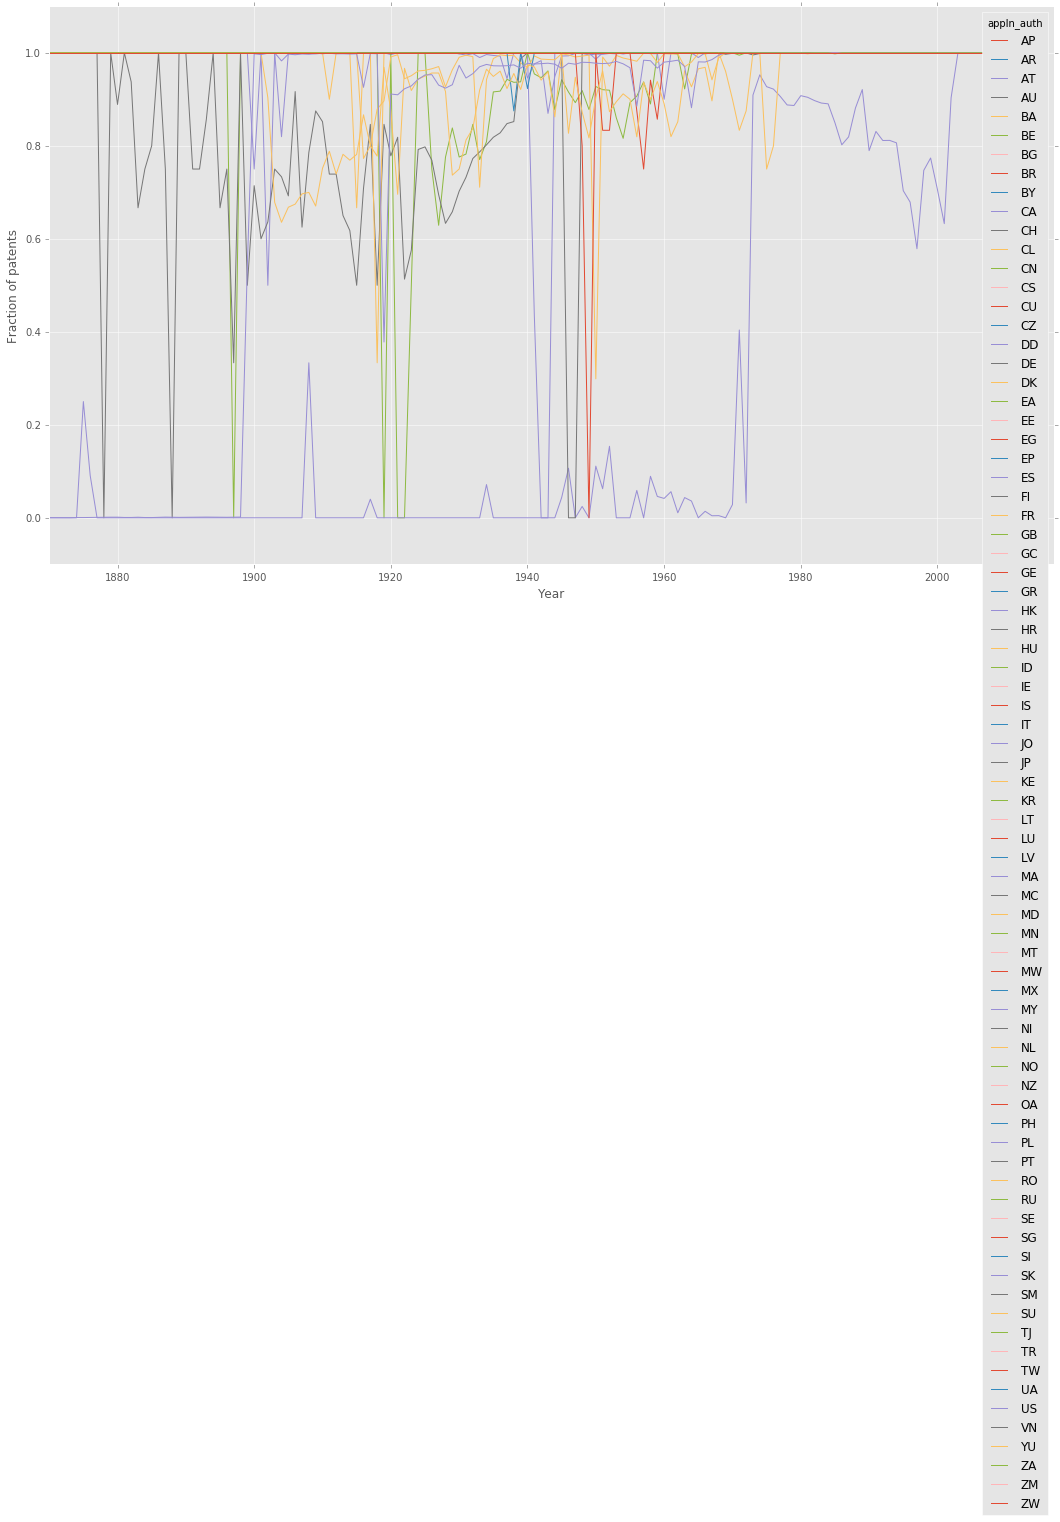

In [38]:
# For all Auths

df_au_year_frac_pv.frac_app.plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

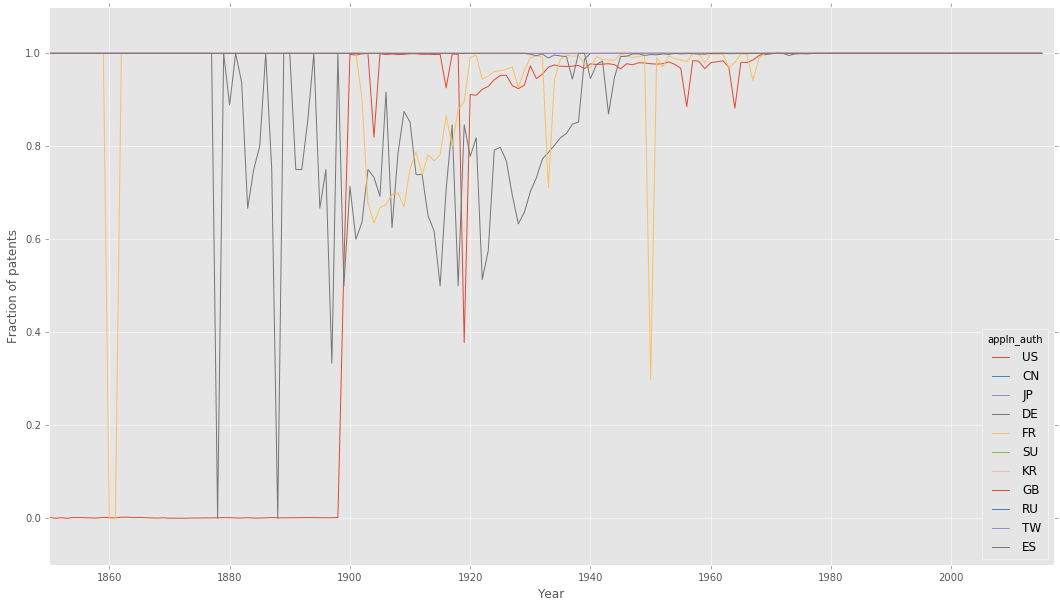

In [39]:
# For top 10

df_au_year_frac_pv.frac_app[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(1850,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

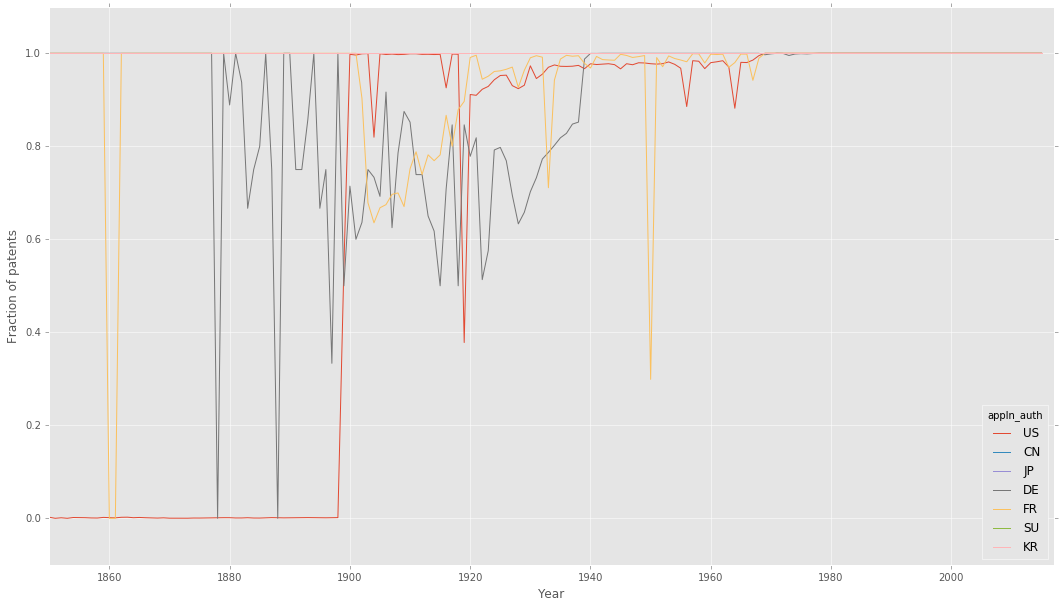

In [40]:
# For top 6

df_au_year_frac_pv.frac_app[auth_by_size[0:7]].plot(figsize=(18,10))
plt.xlim(1850,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

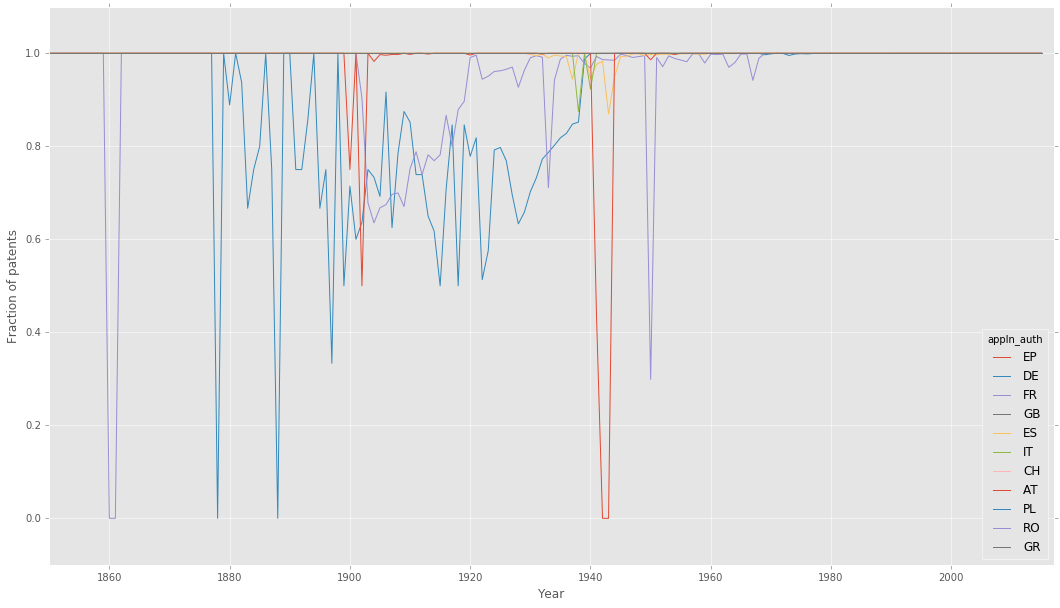

In [41]:
# For European Top 10 Auths

df_au_year_frac_pv.frac_app[eu_auths[0:11]].plot(figsize=(18,10))
plt.xlim(1850,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

## Checking IPC Classfications By Auth
[to top](#Table-of-Contents)

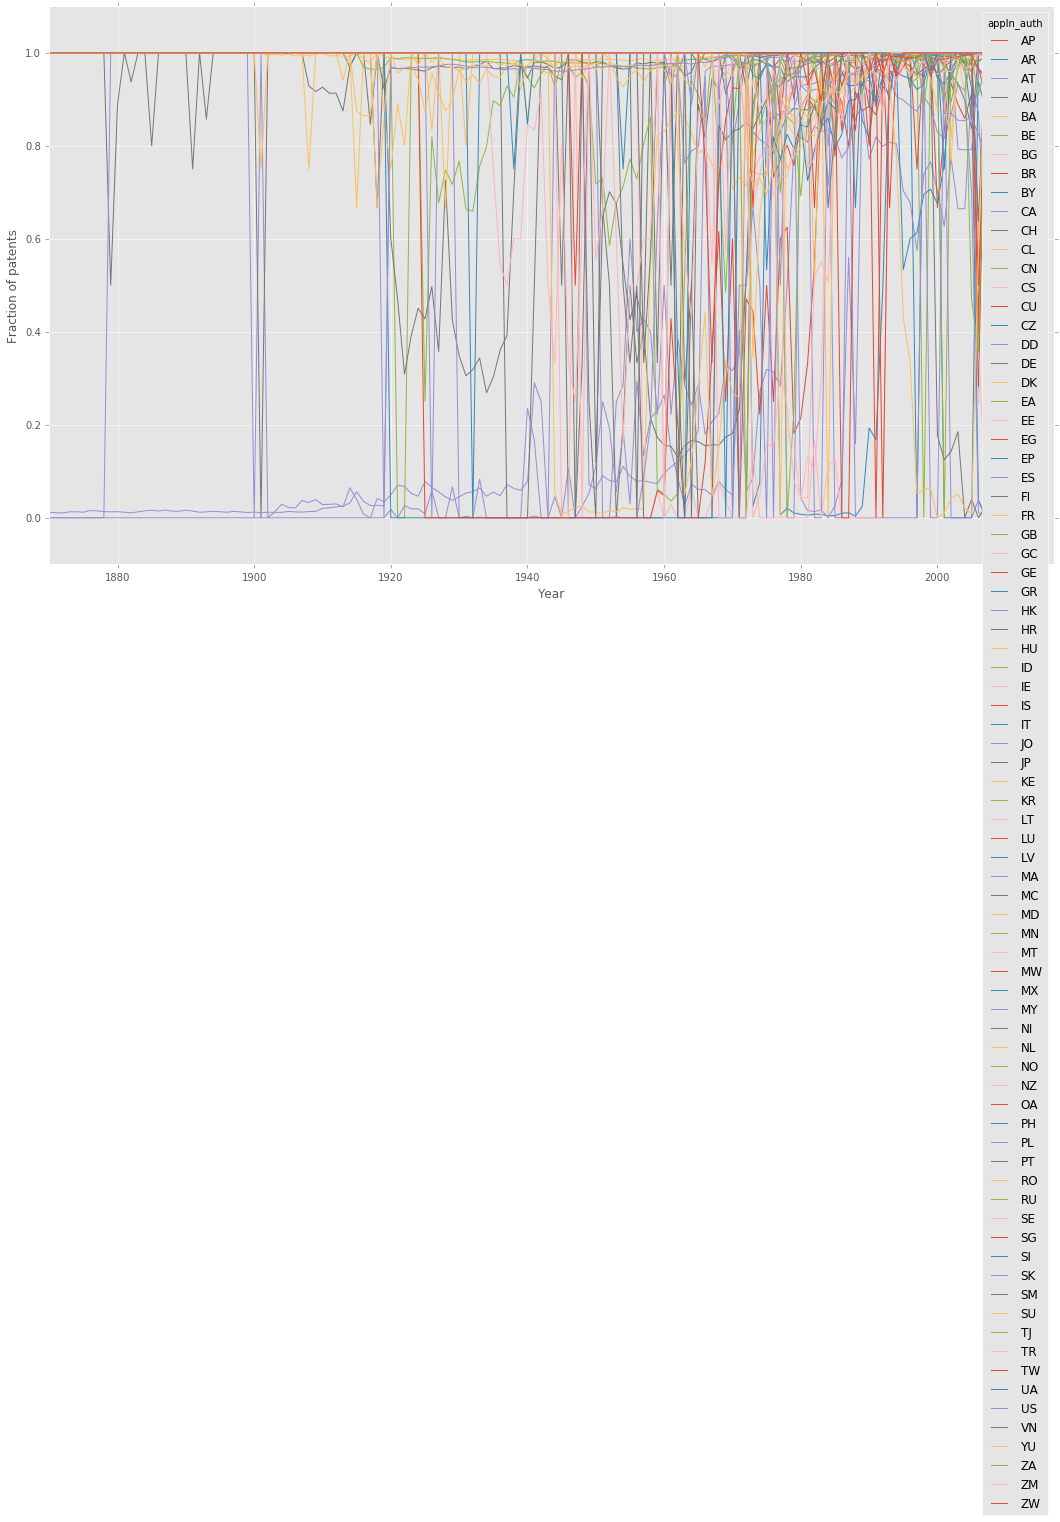

In [42]:
# For all Auths

df_au_year_frac_pv.frac_ipc.plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

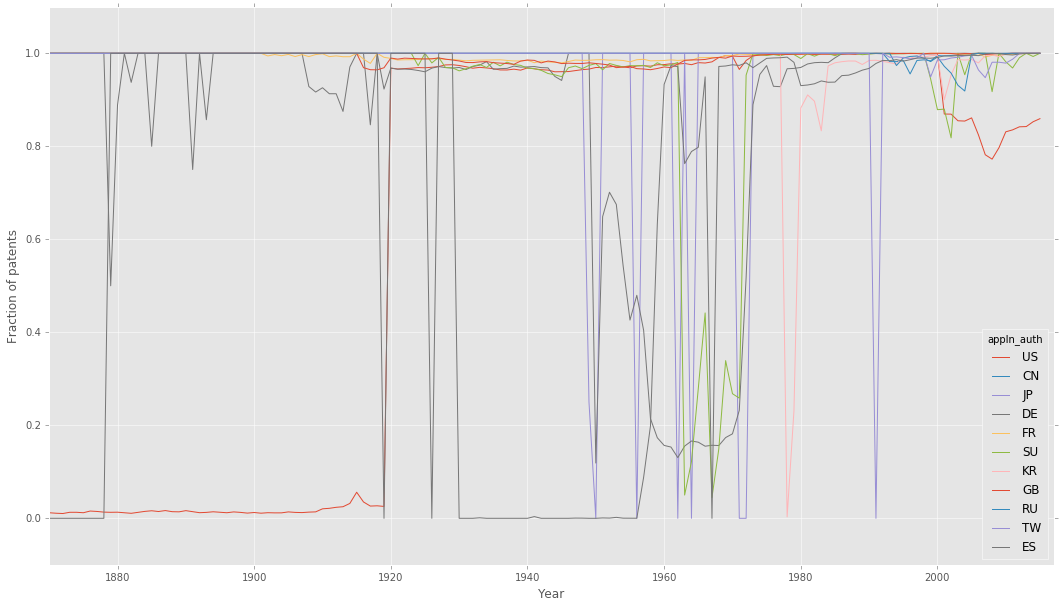

In [43]:
# For top 10

df_au_year_frac_pv.frac_ipc[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

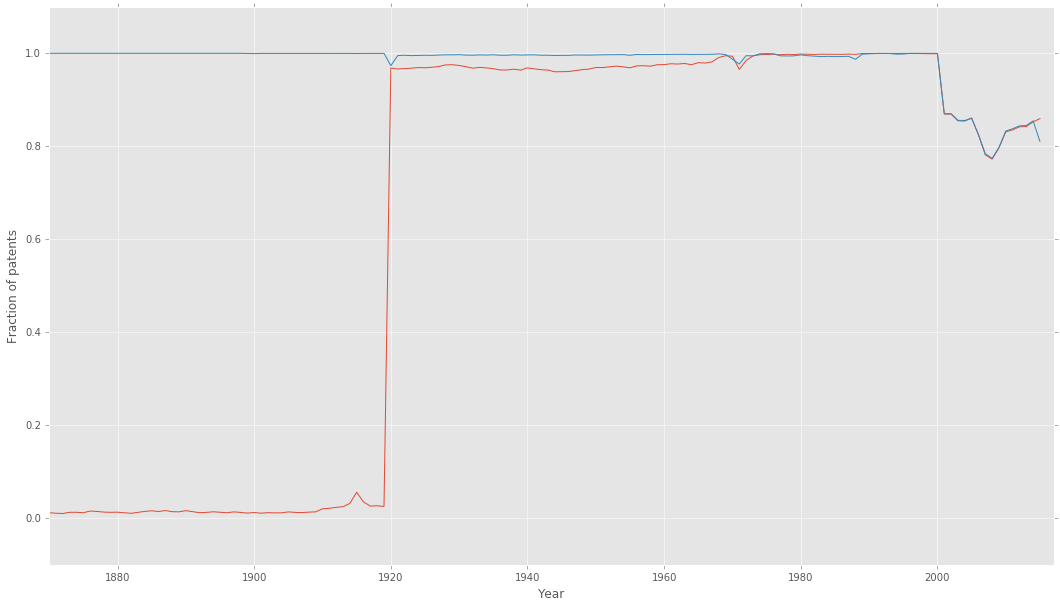

US


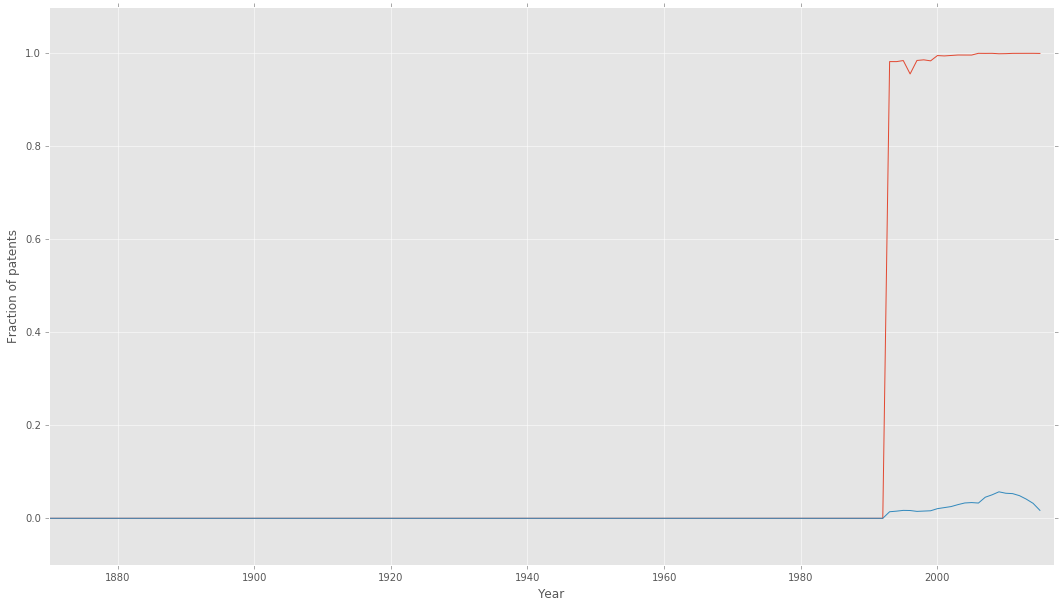

CN


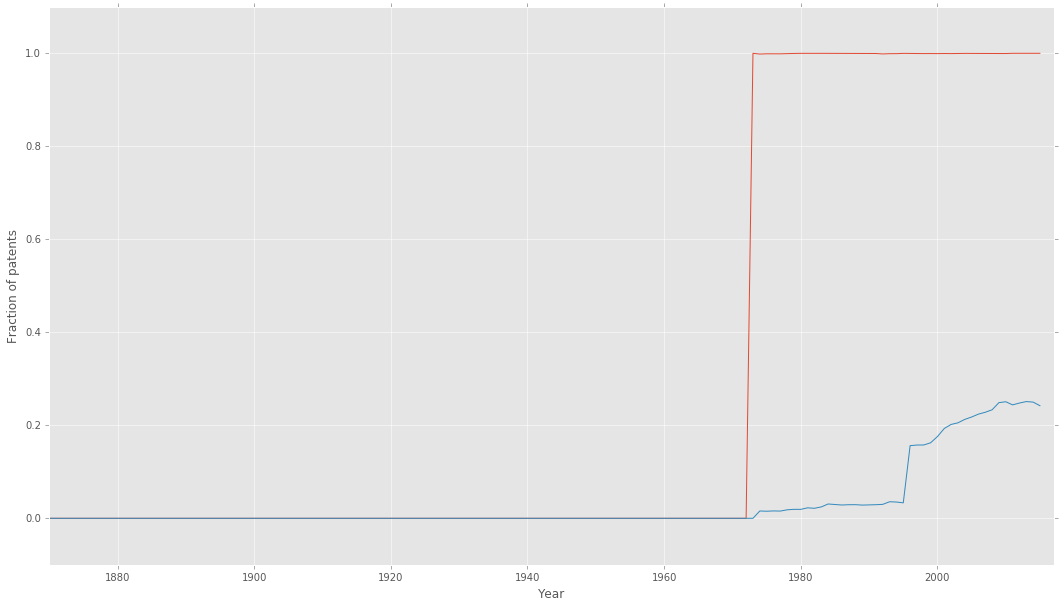

JP


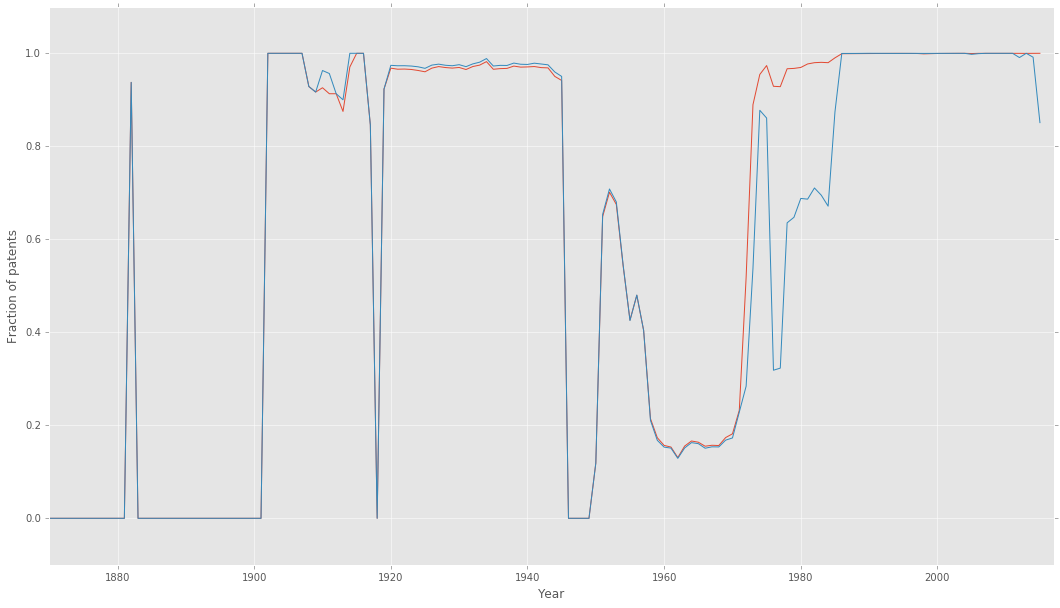

DE


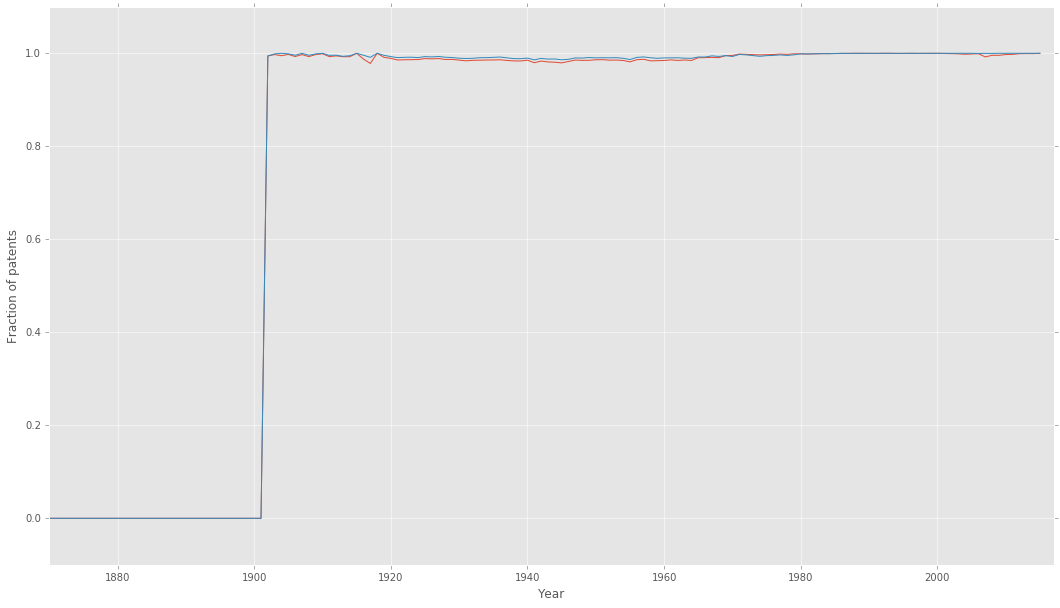

FR


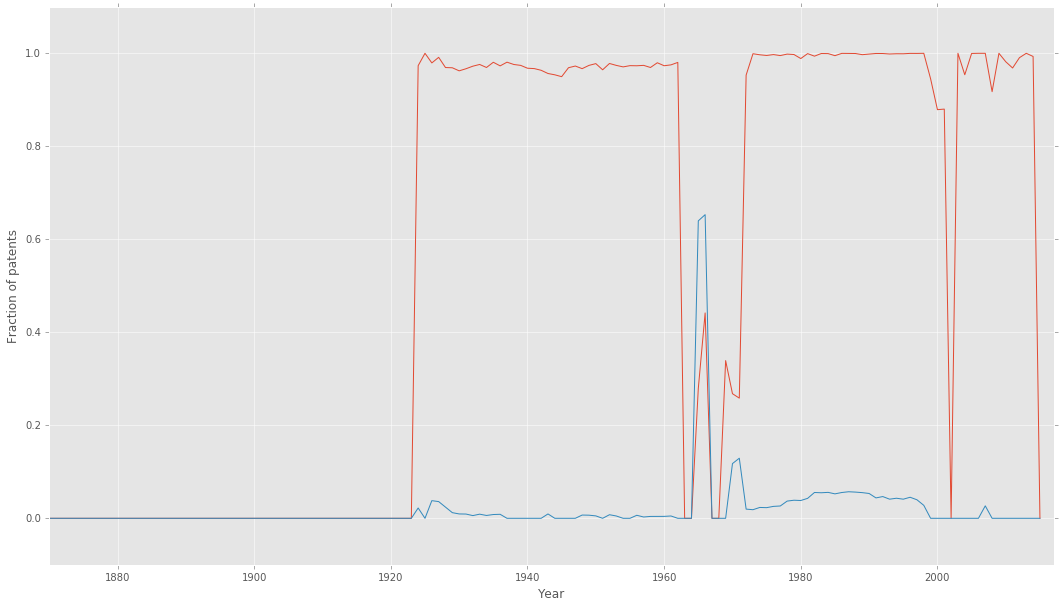

SU


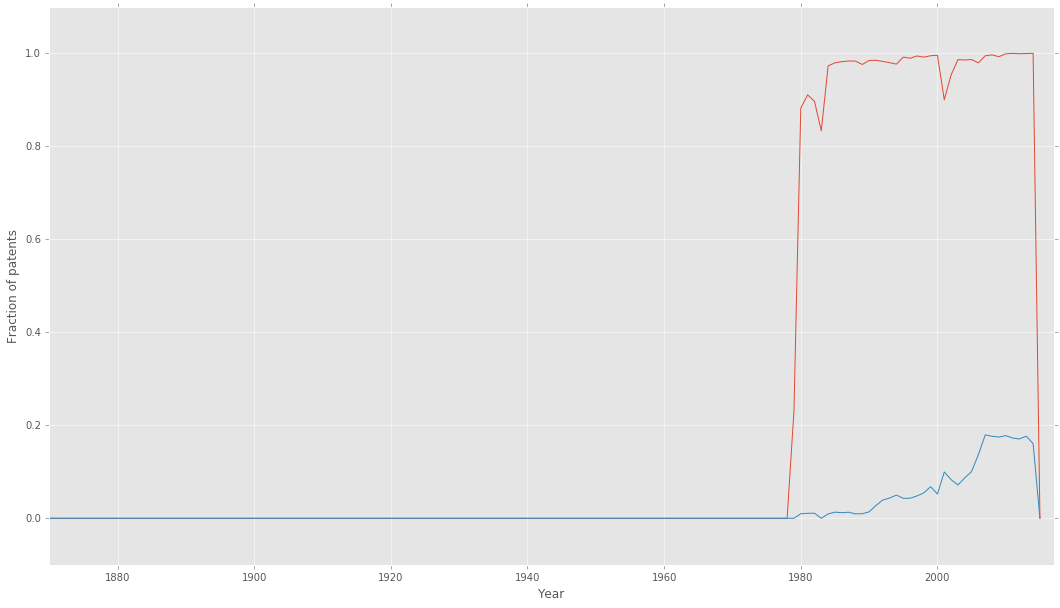

KR


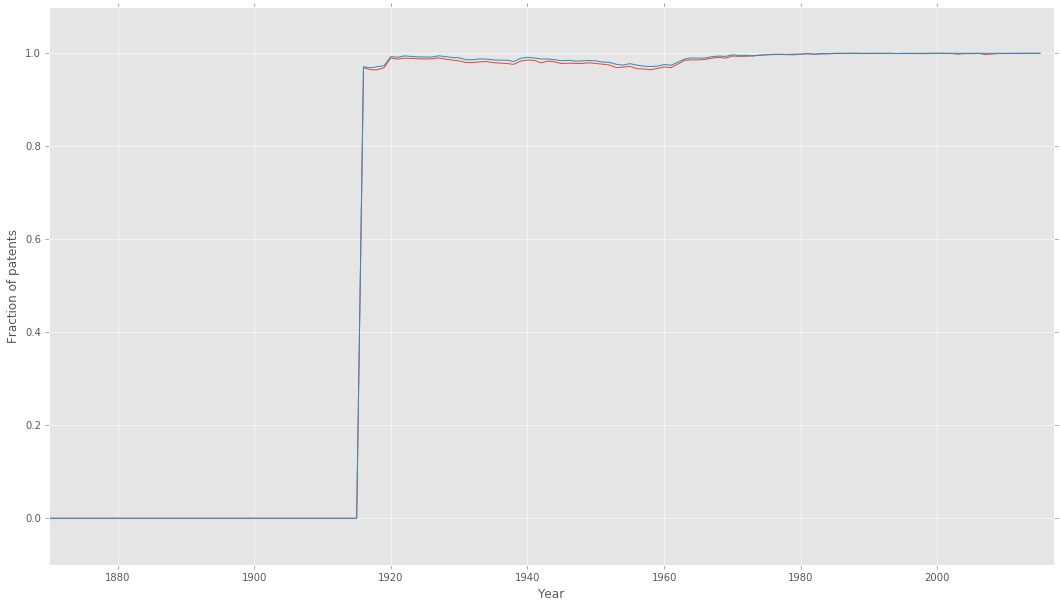

GB


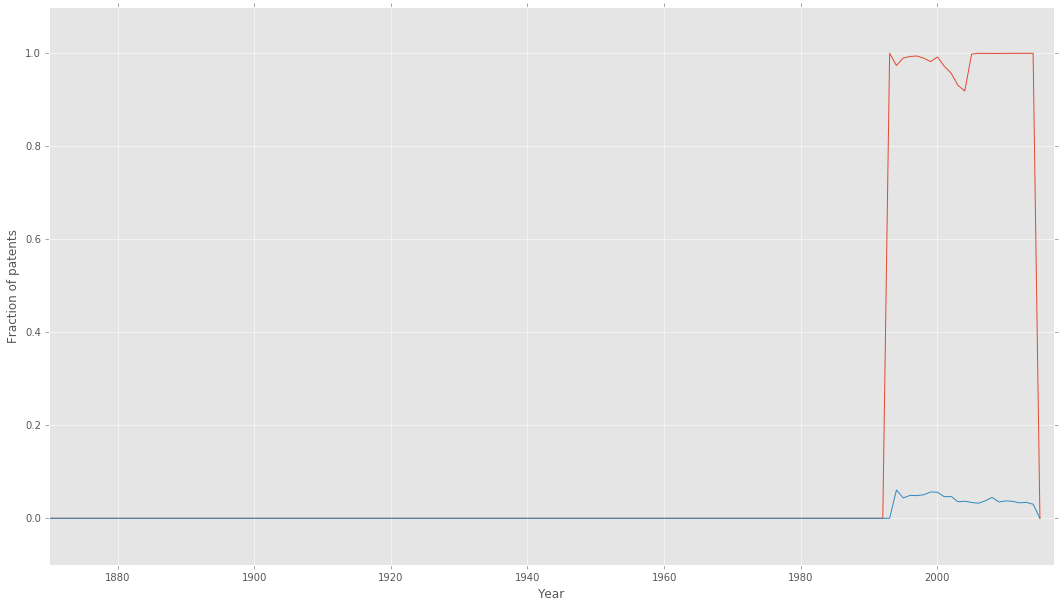

RU


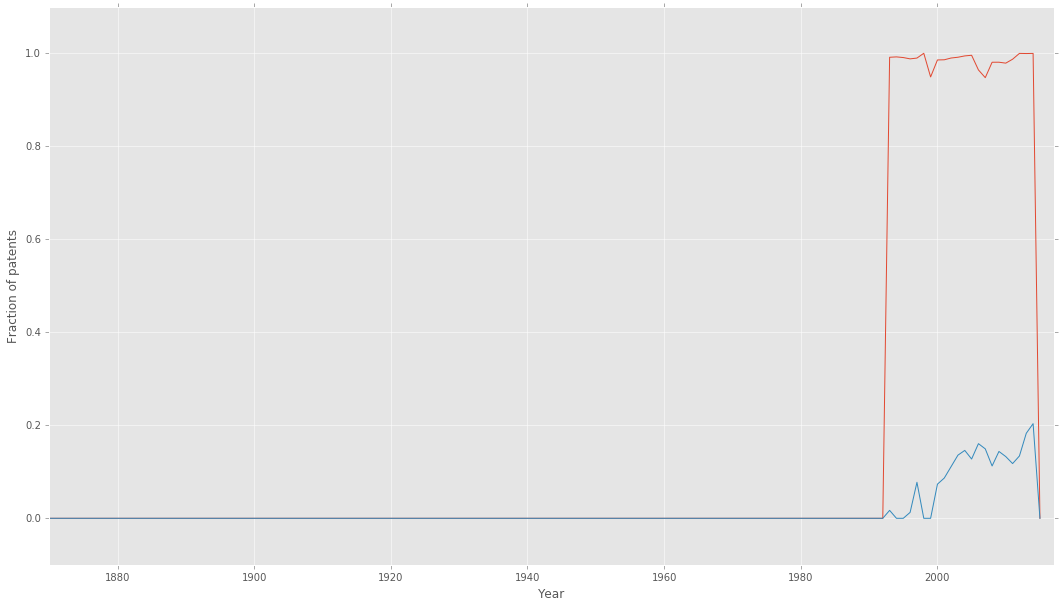

TW


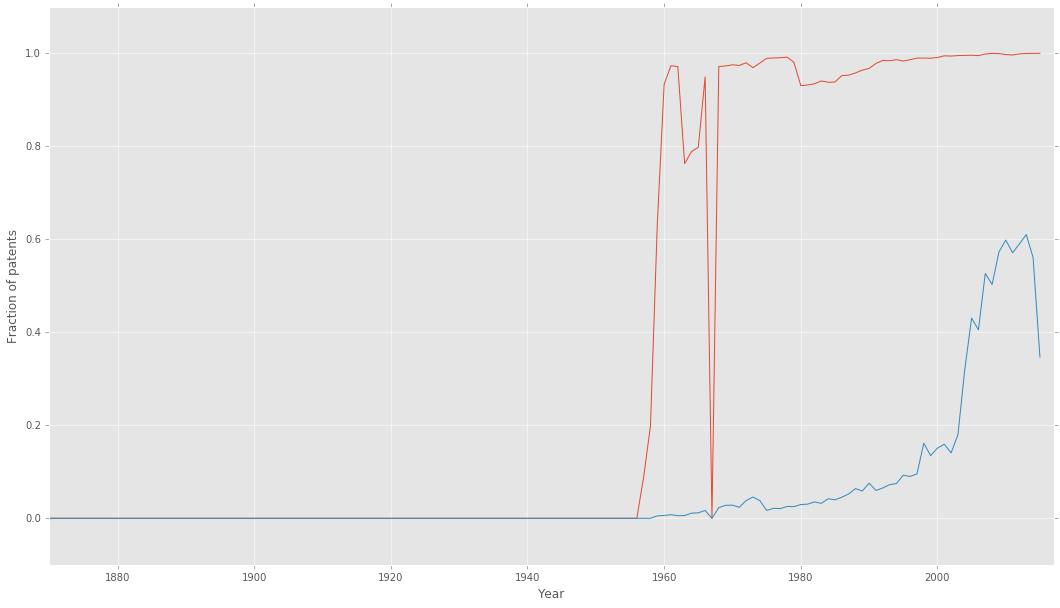

ES


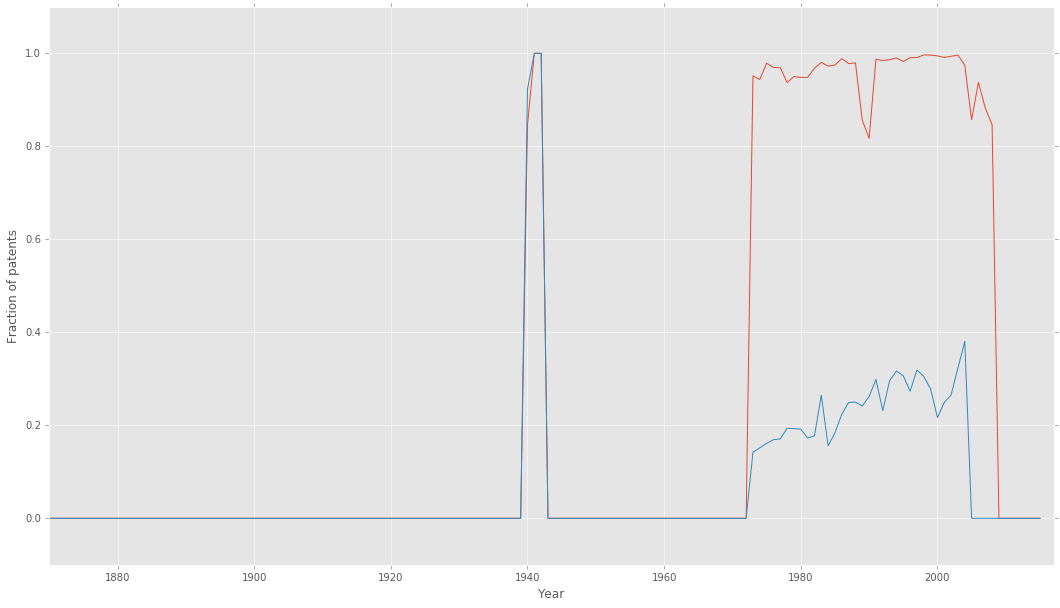

IT


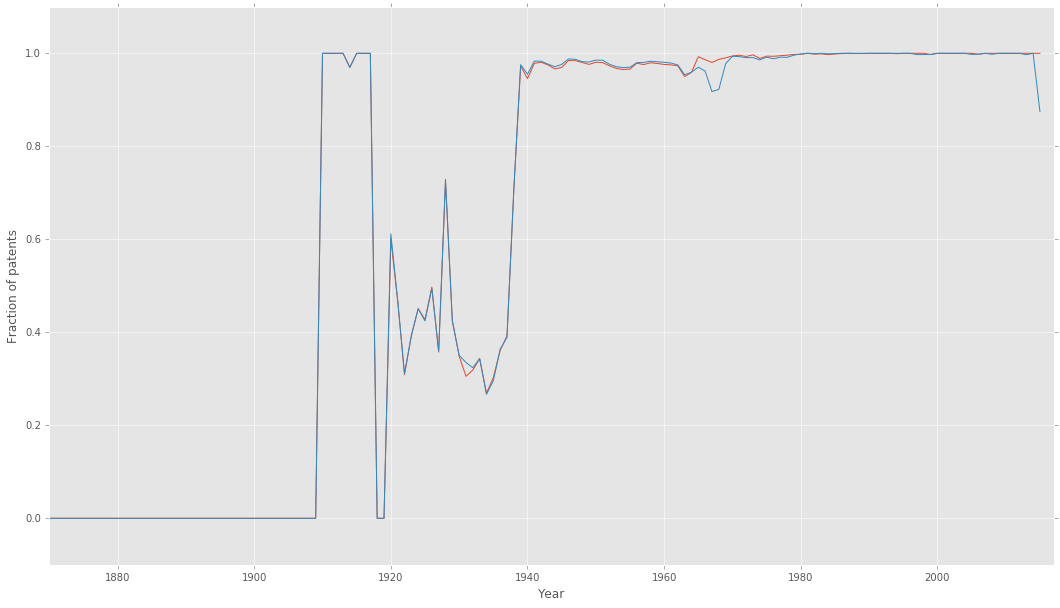

CH


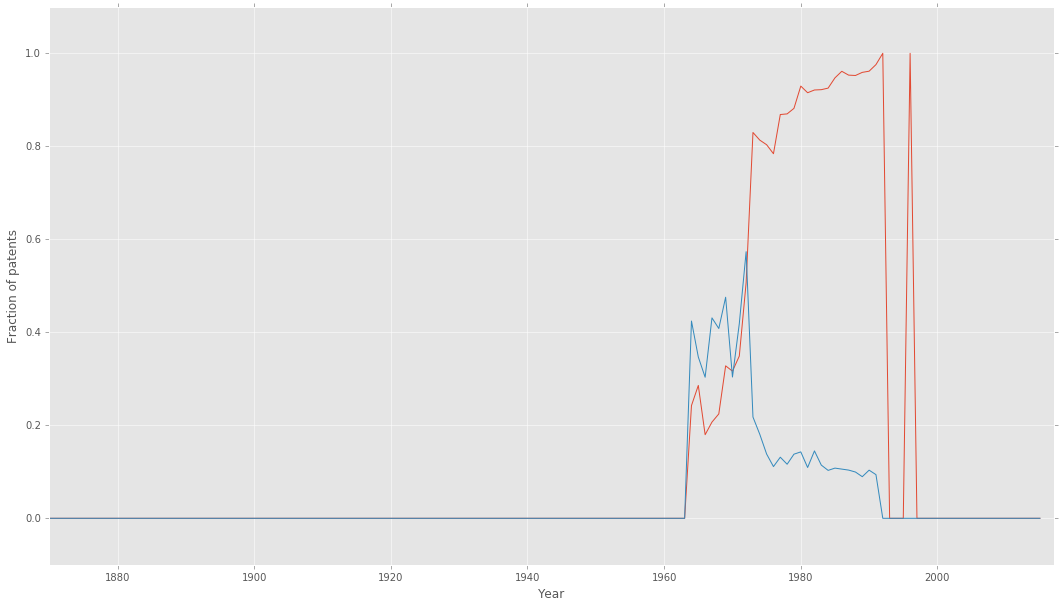

DD


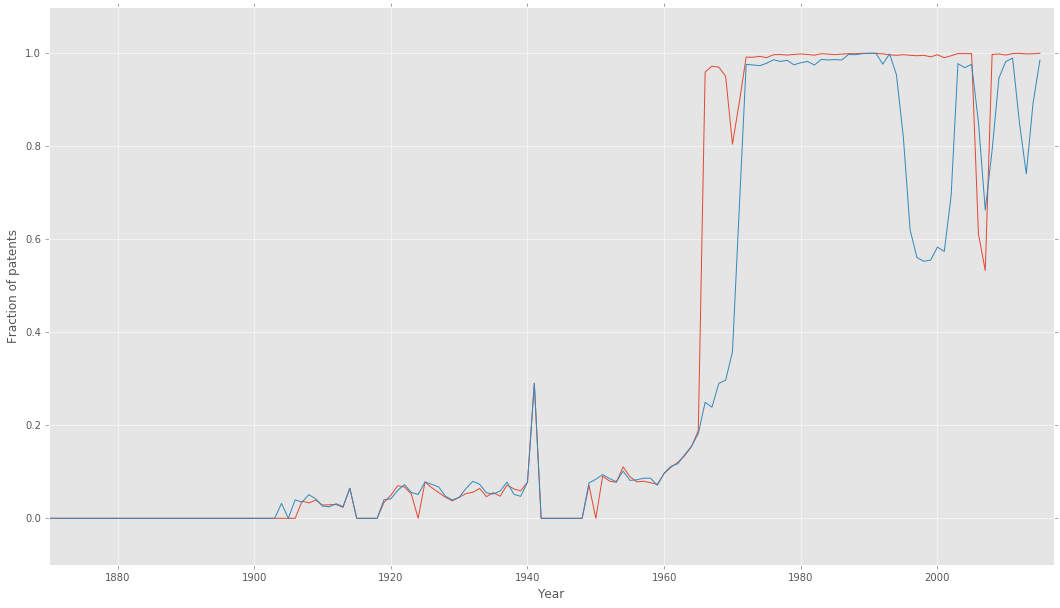

AT


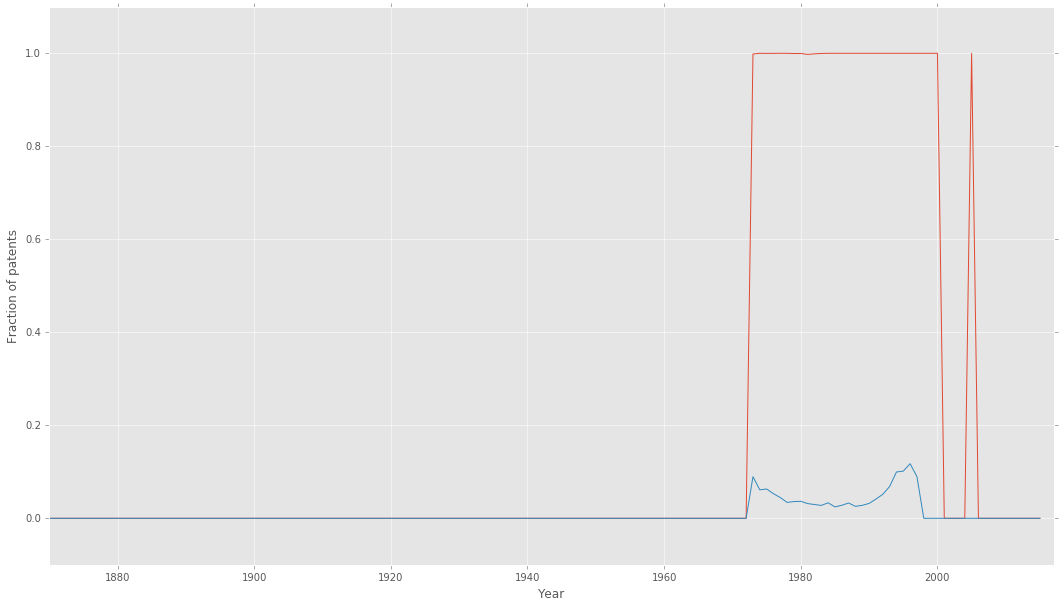

CS


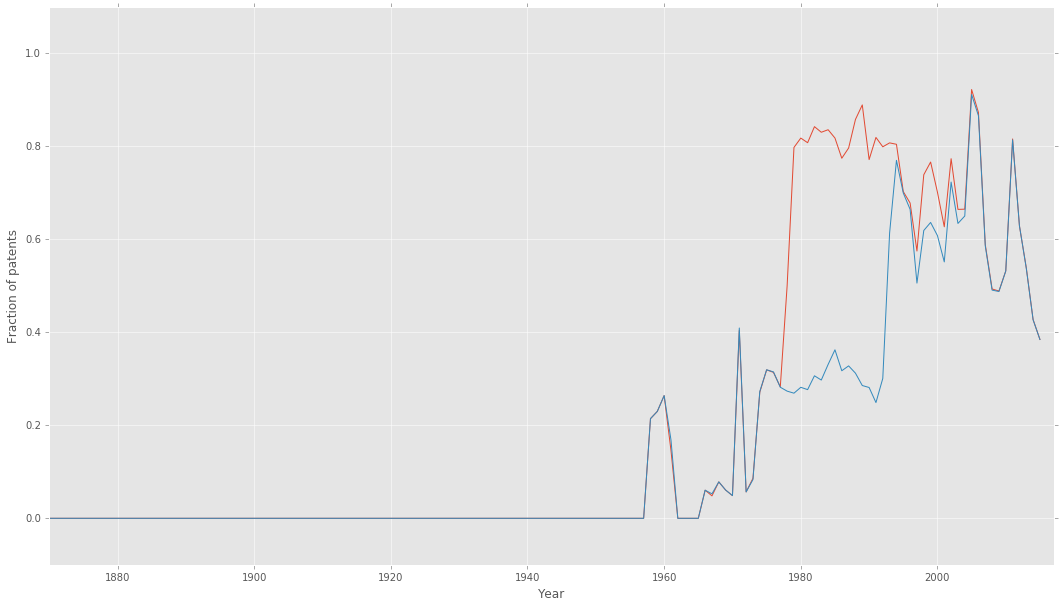

CA


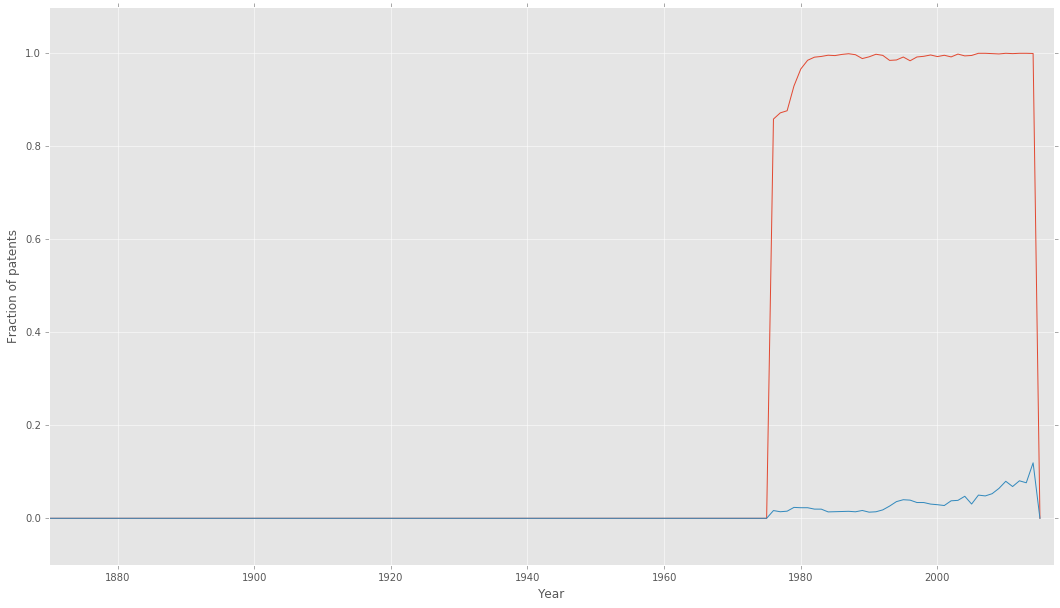

PL


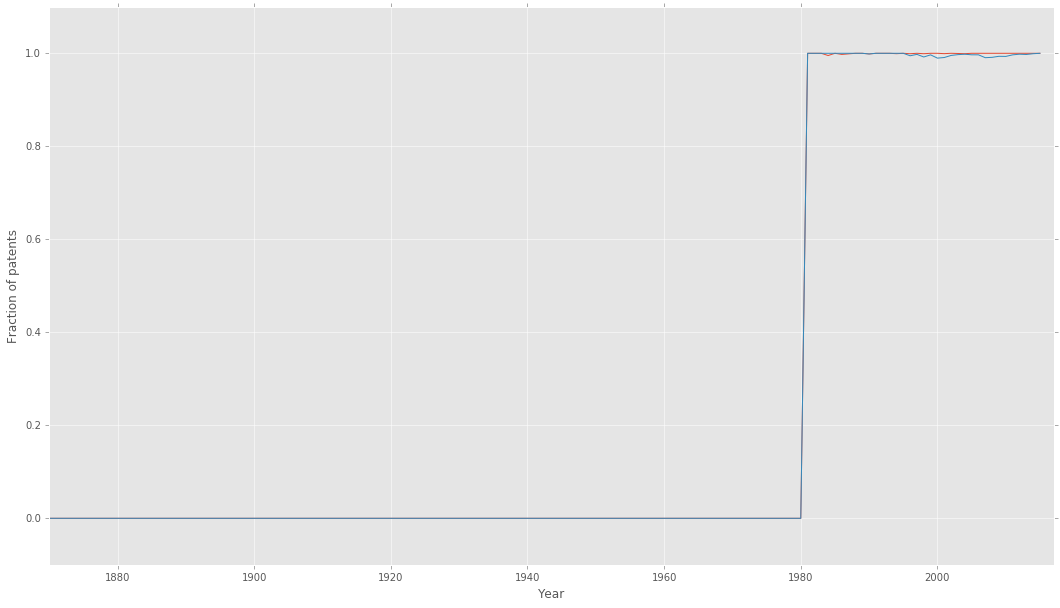

EP


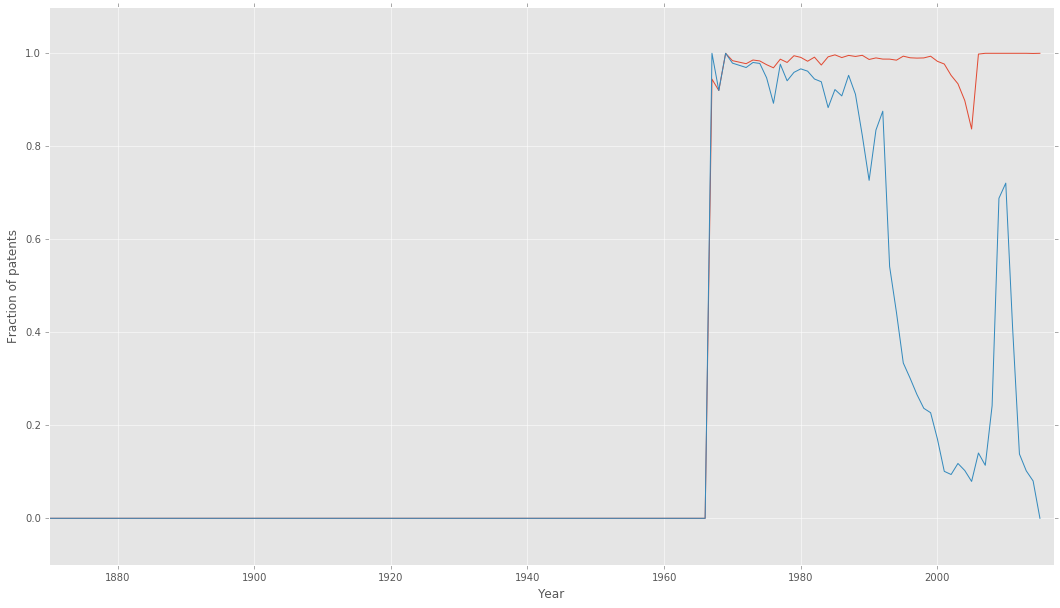

AU


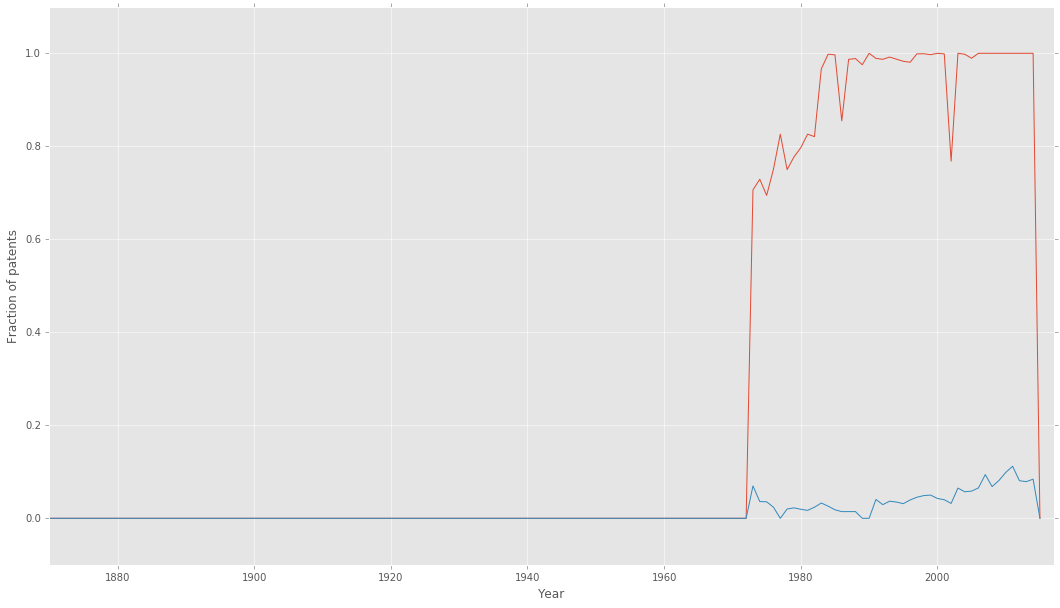

RO


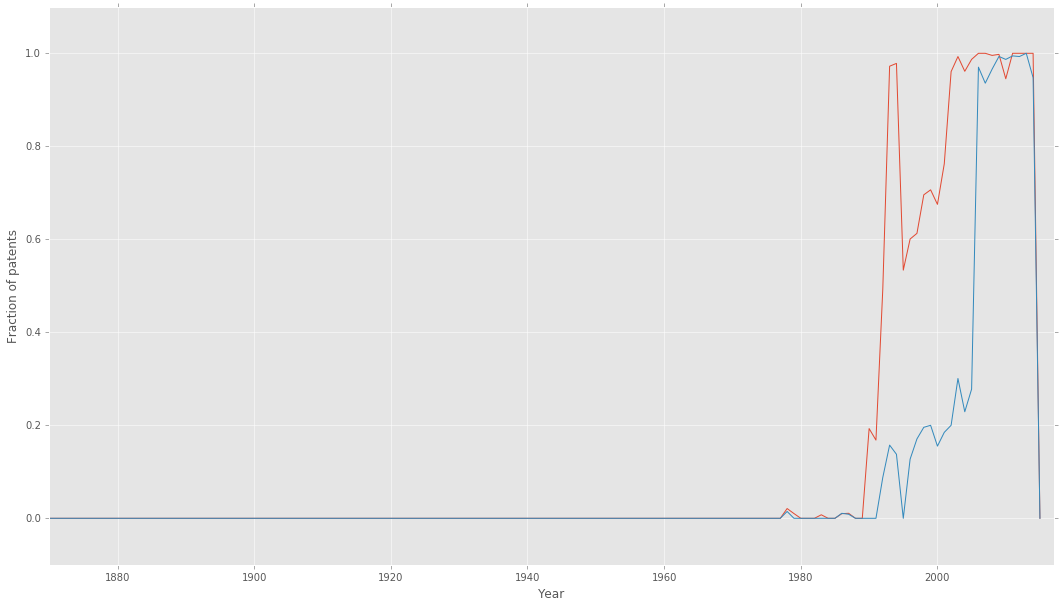

GR


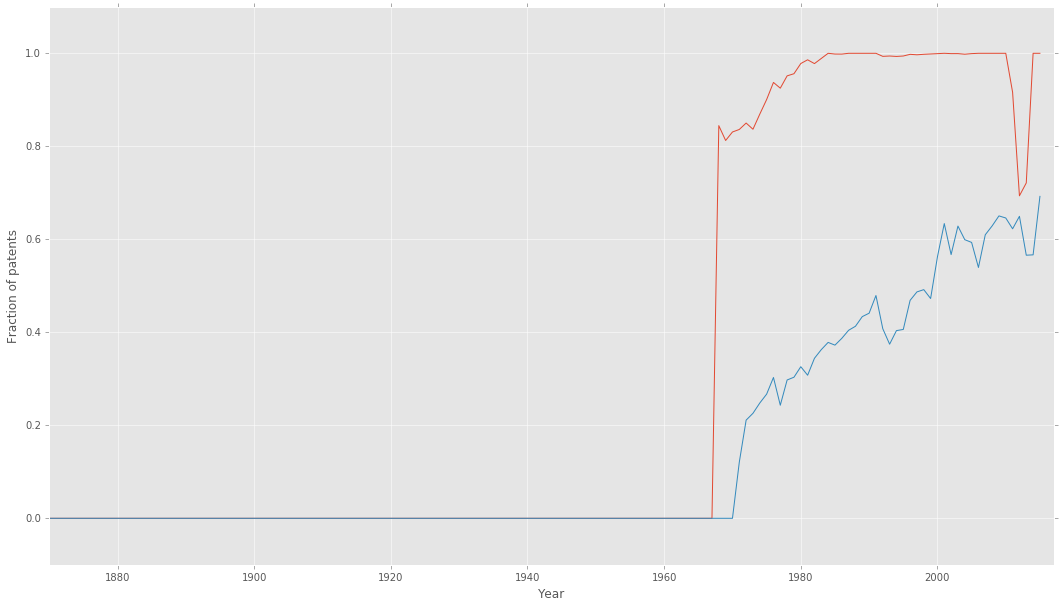

FI


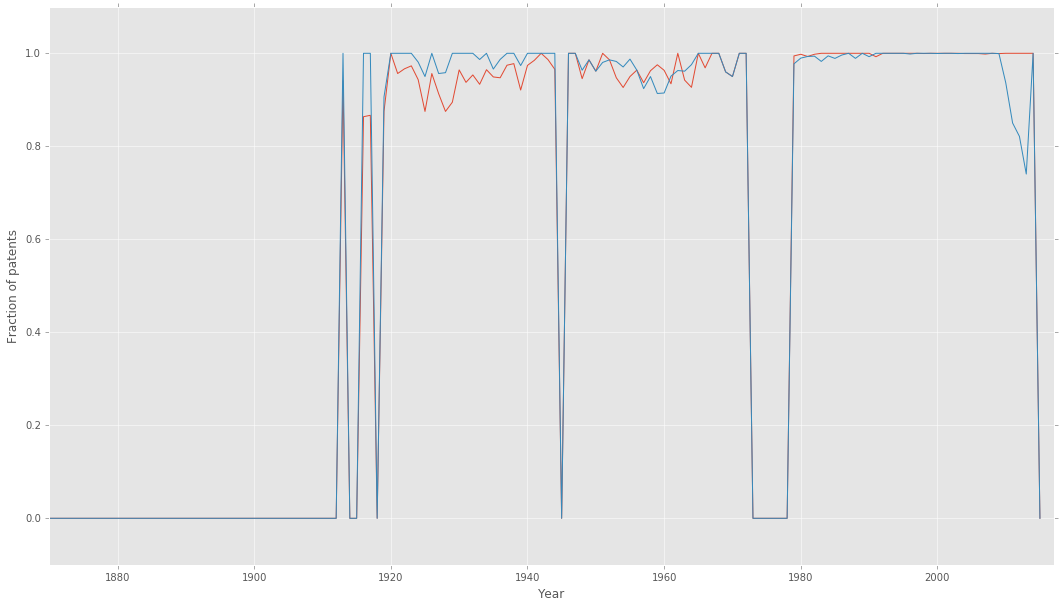

NL


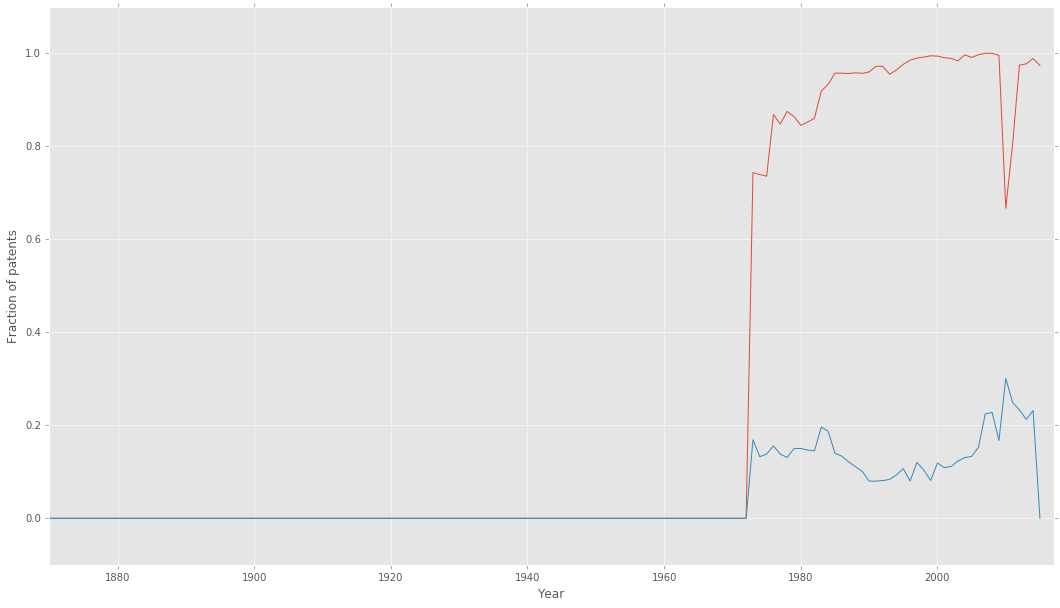

HU


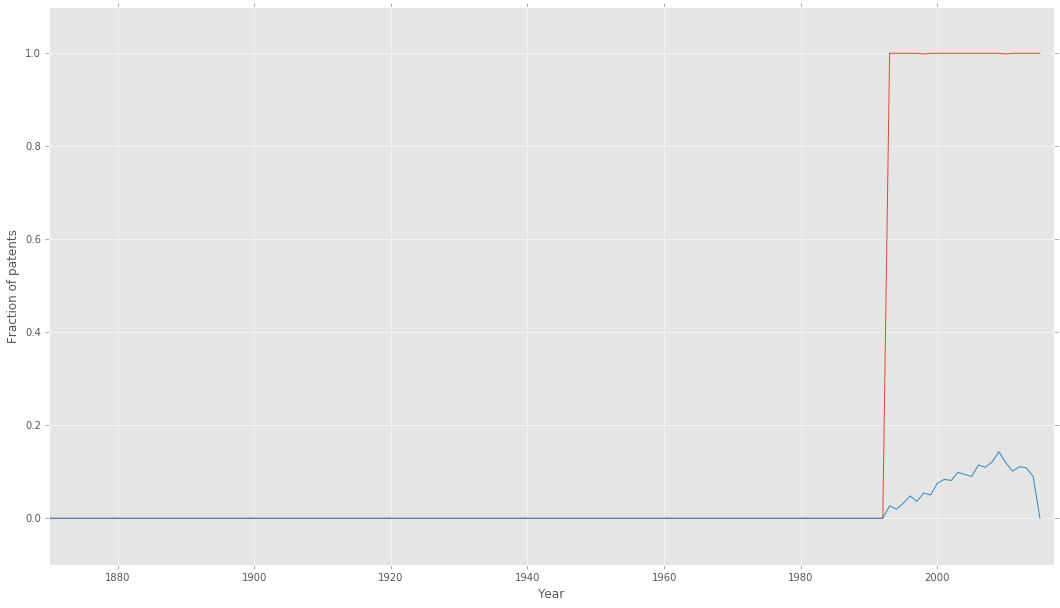

CZ


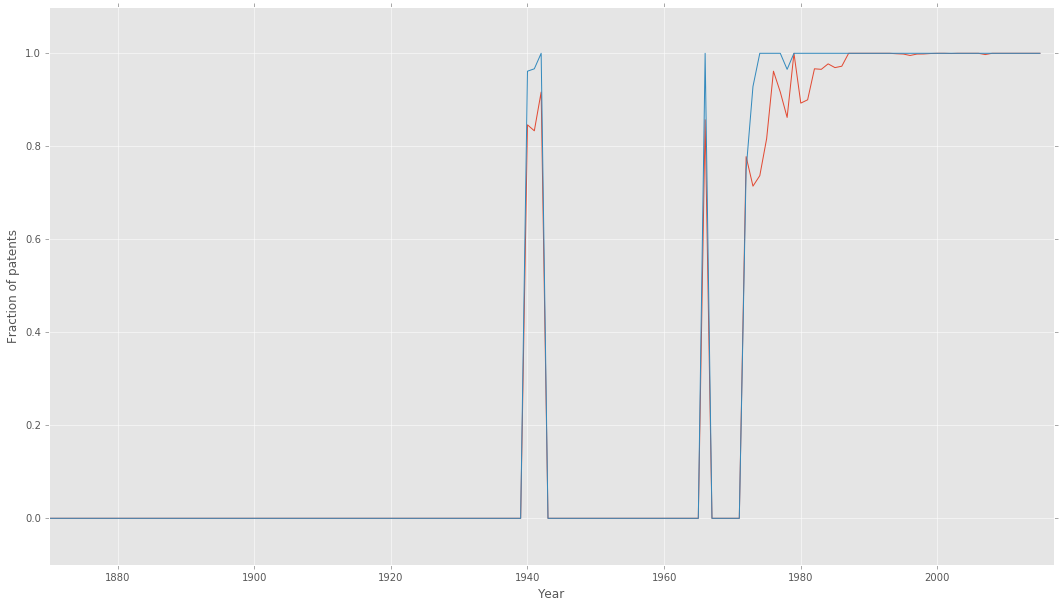

SE


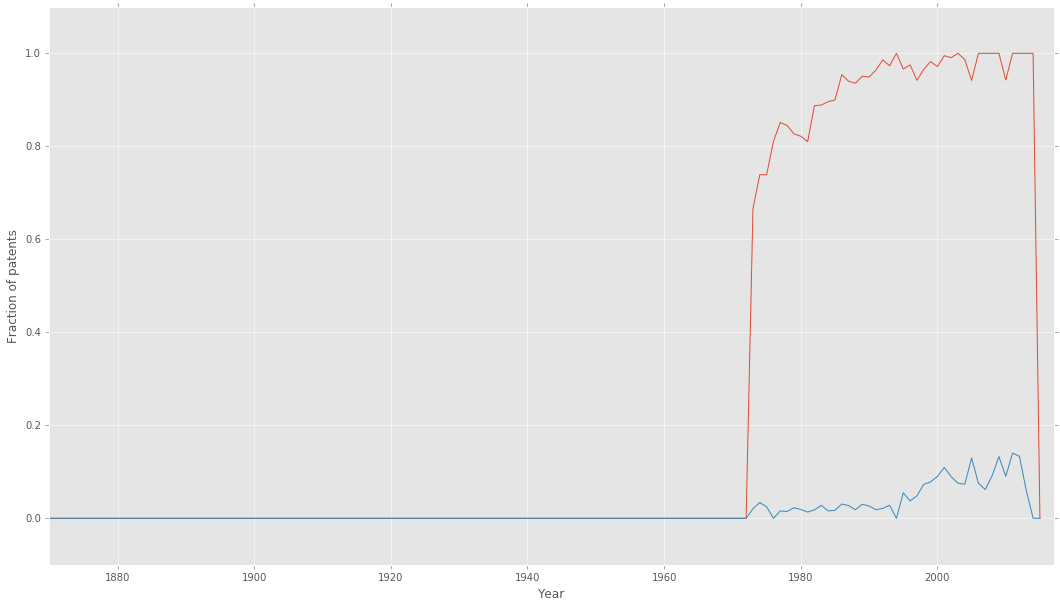

BG


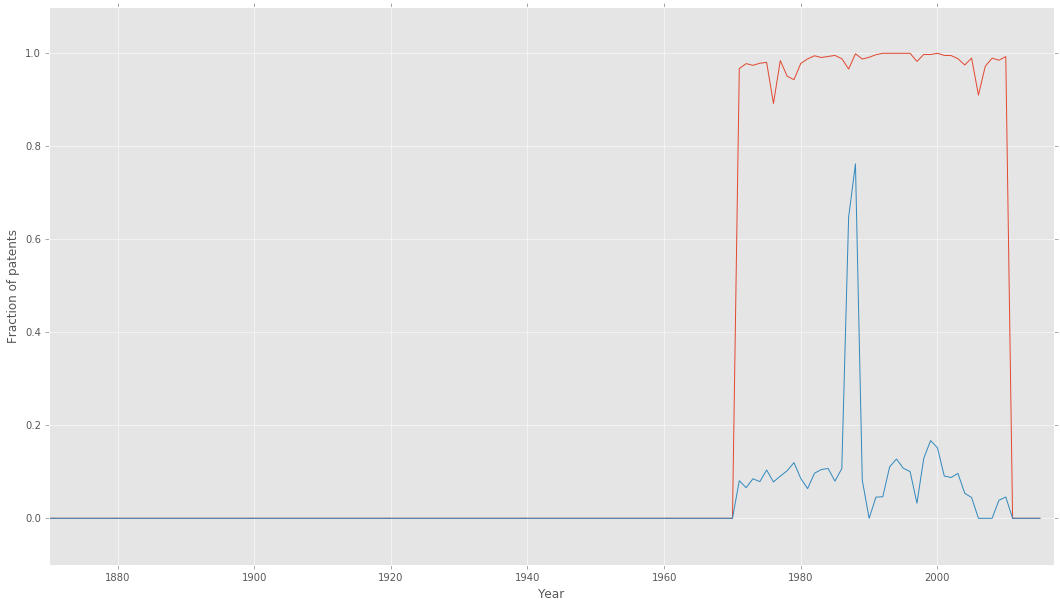

ZA


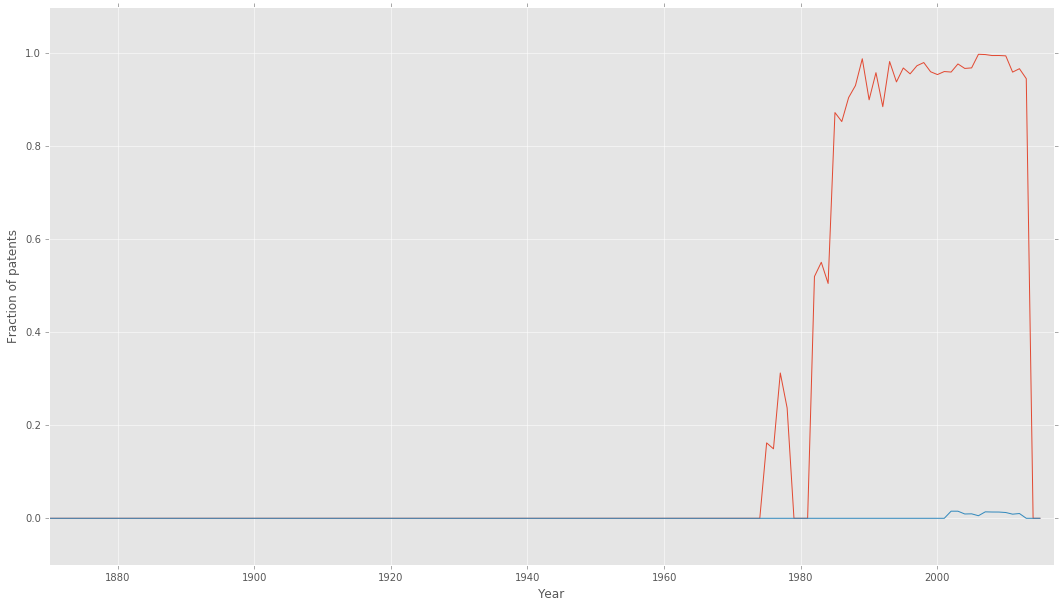

TR


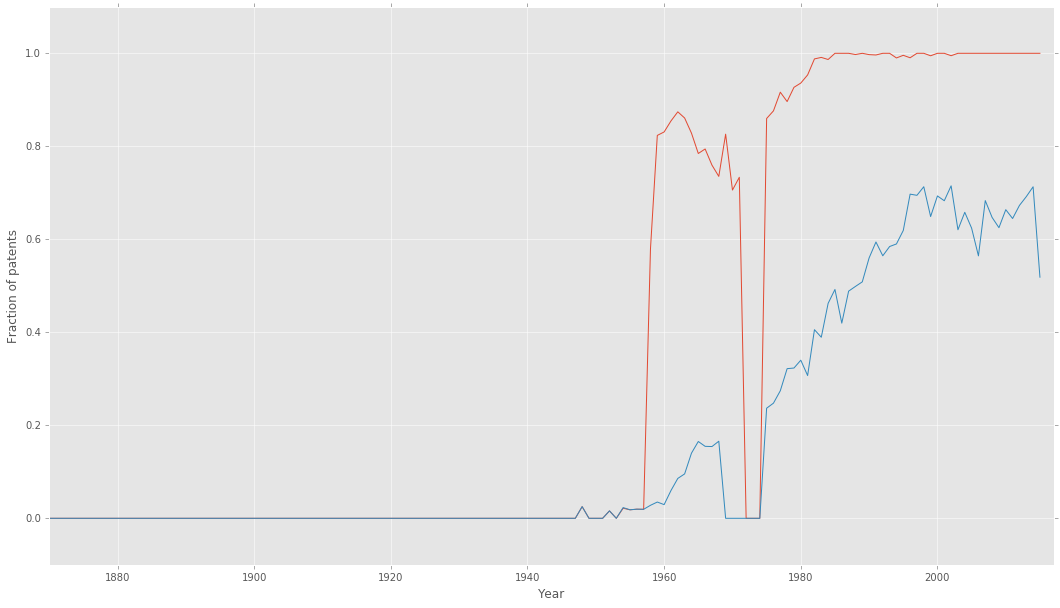

DK


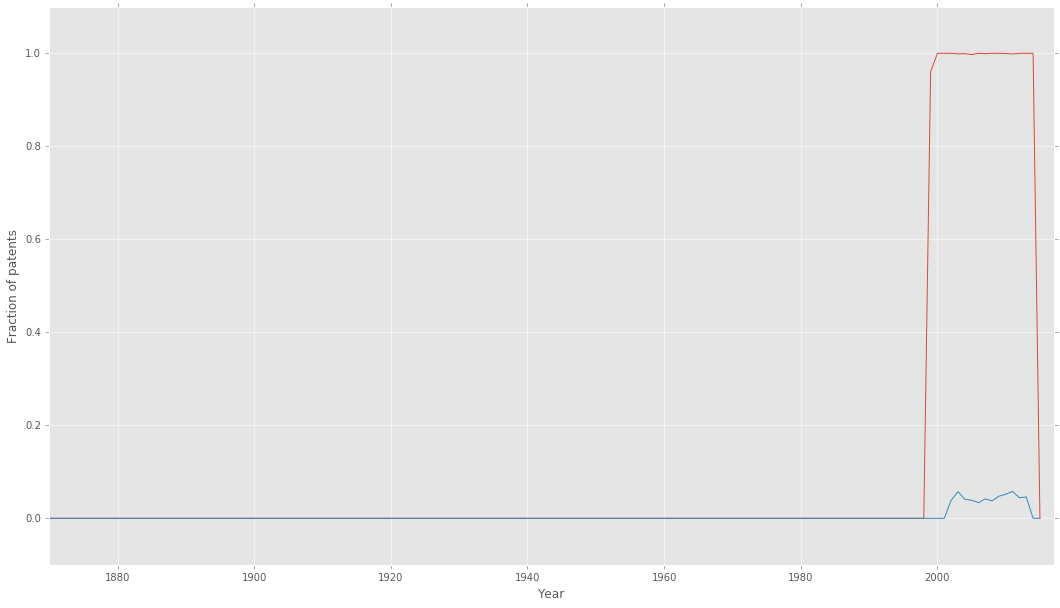

UA


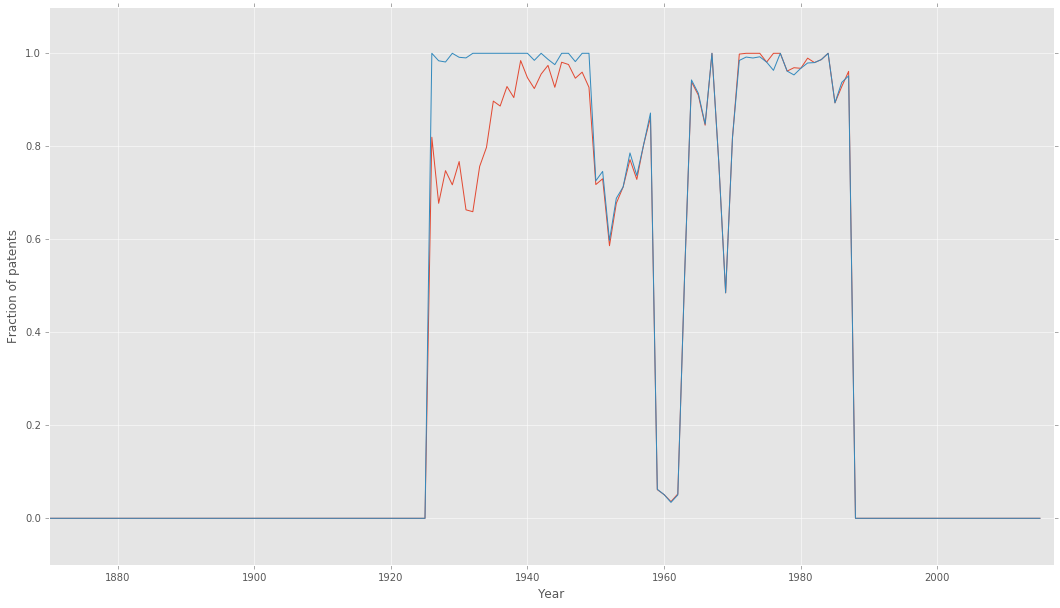

BE


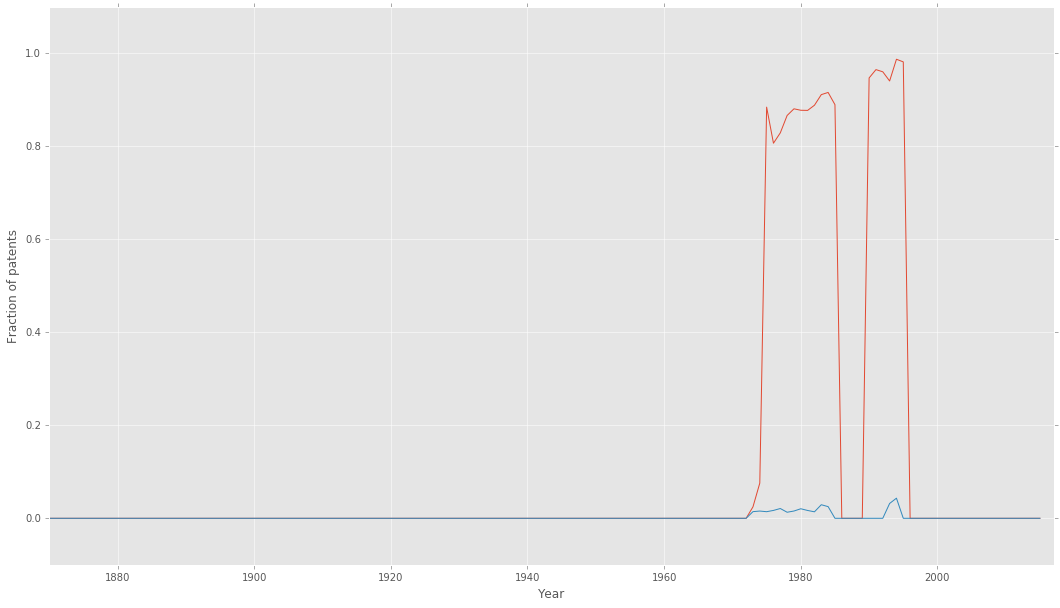

AR


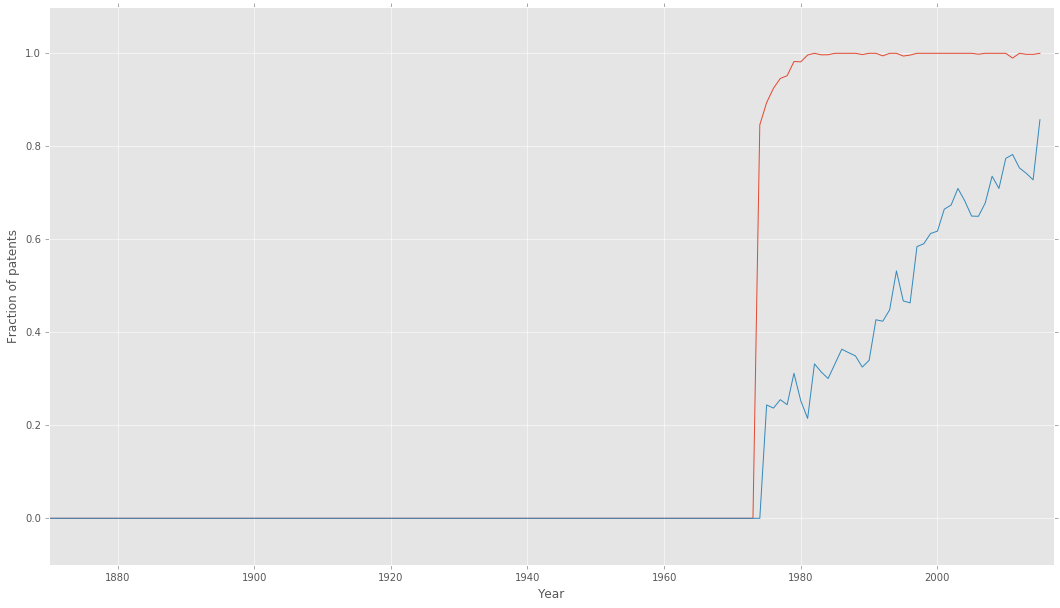

NO


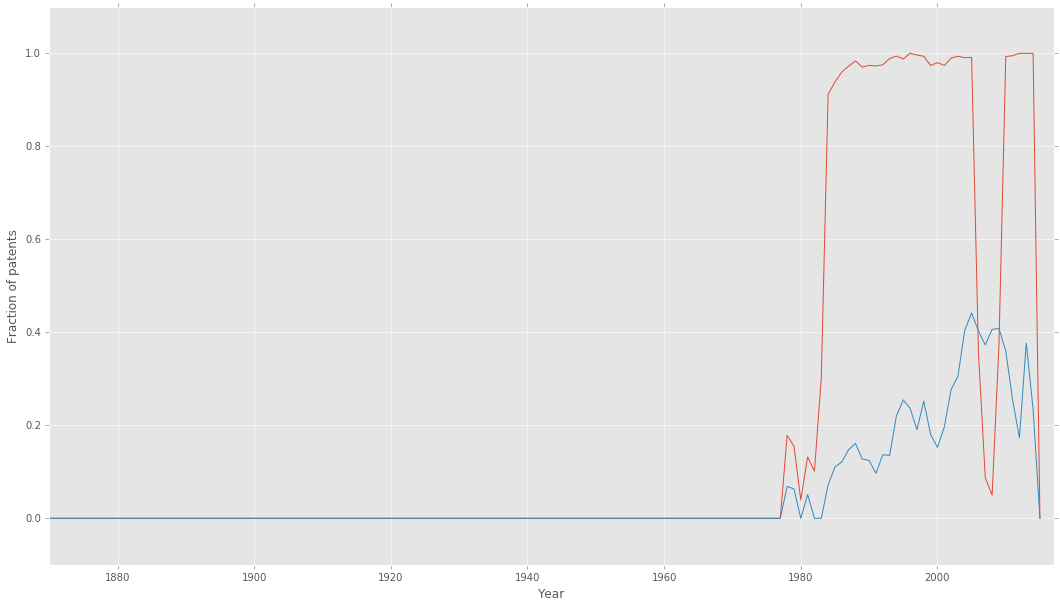

NZ


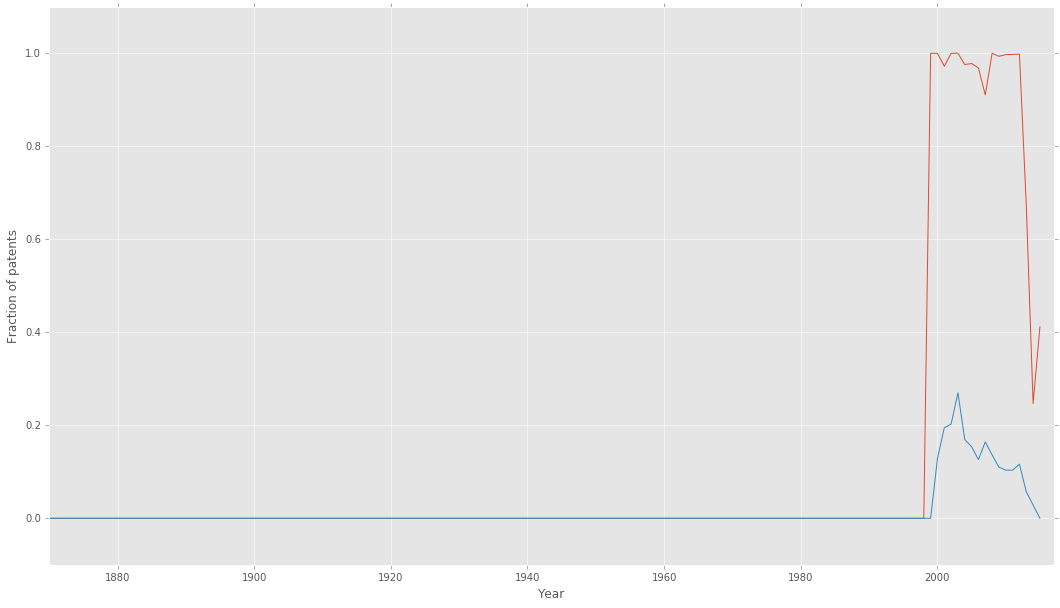

BR


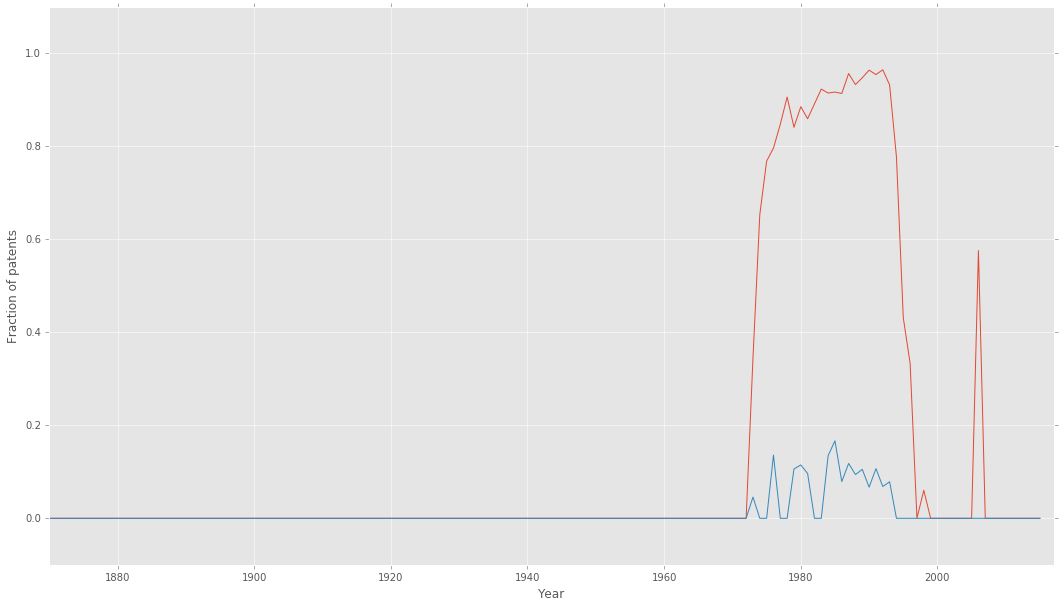

YU


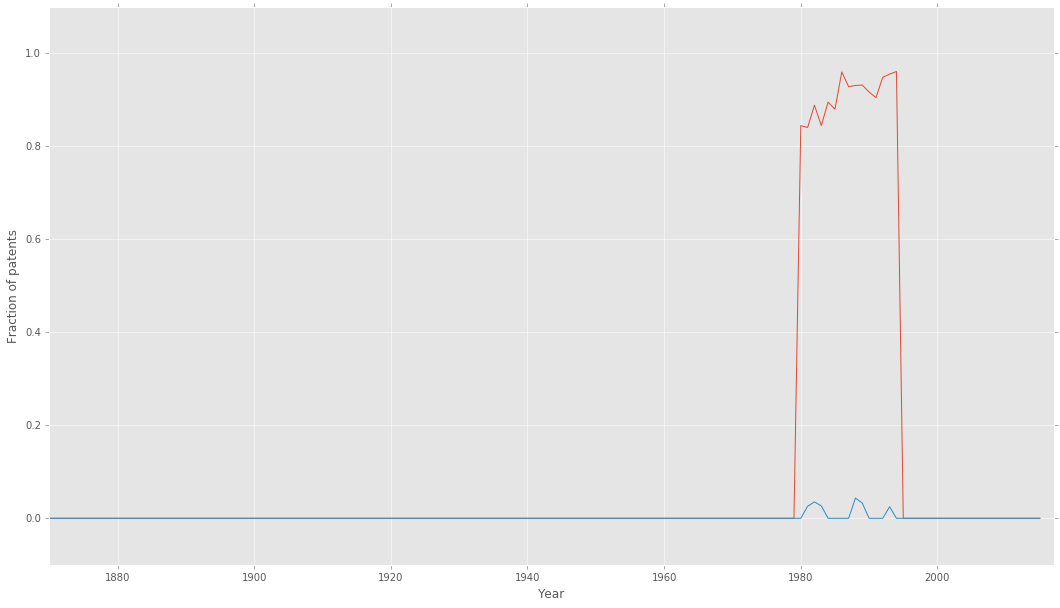

MX


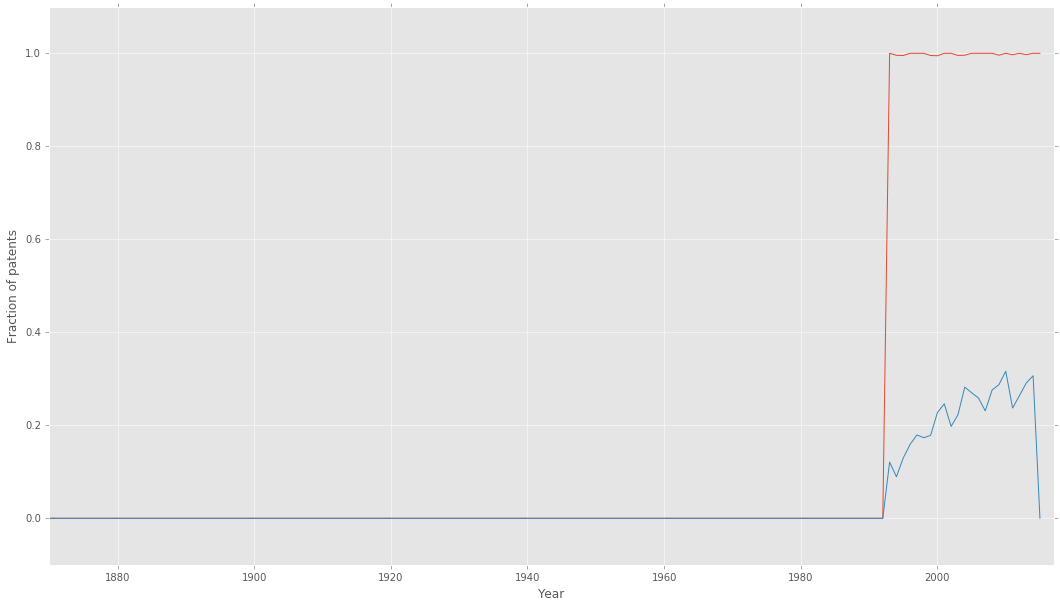

SI


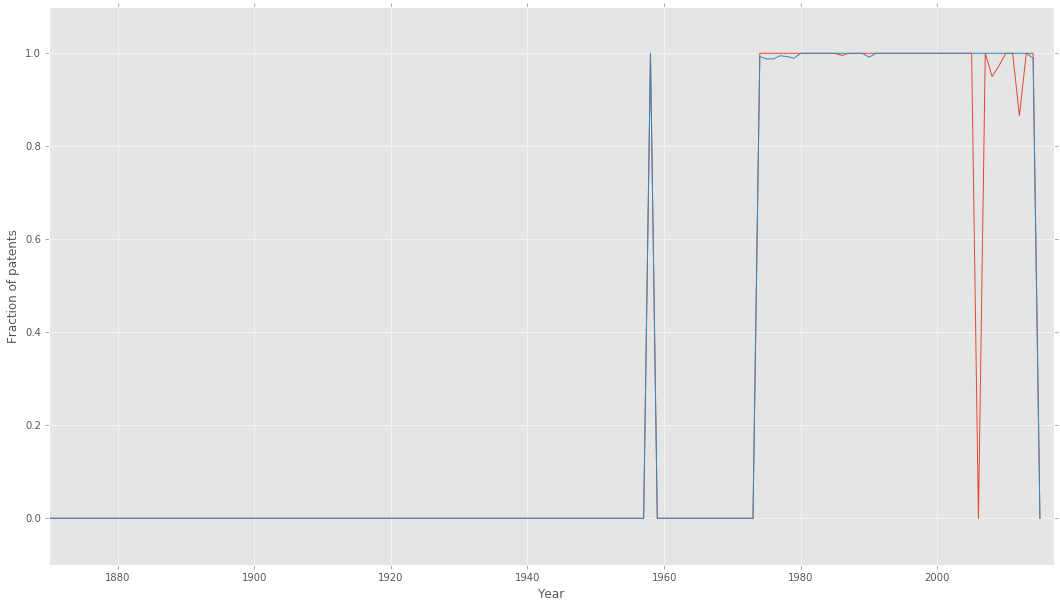

LU


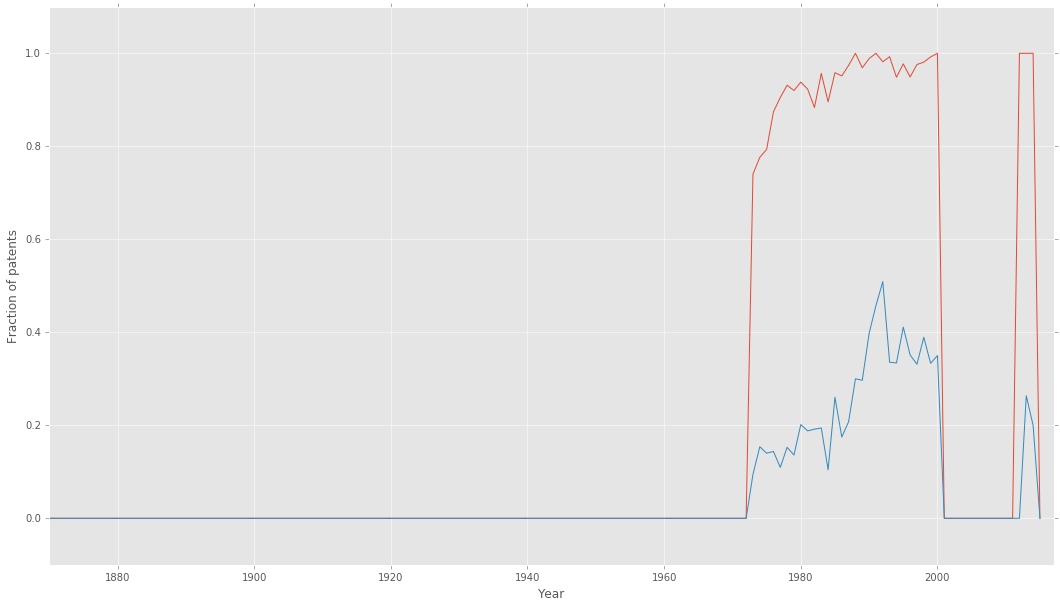

IE


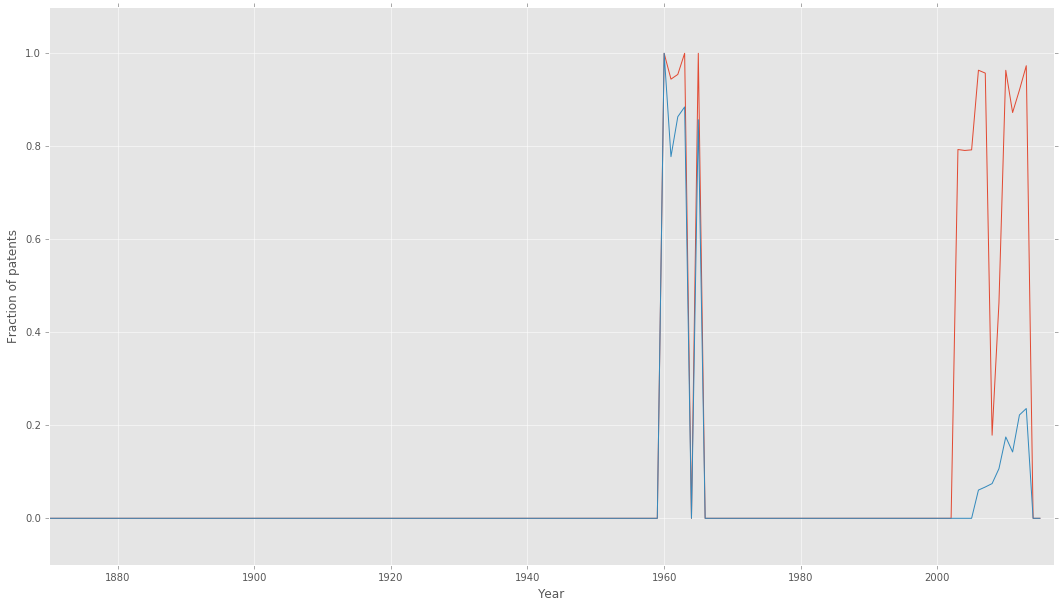

MY


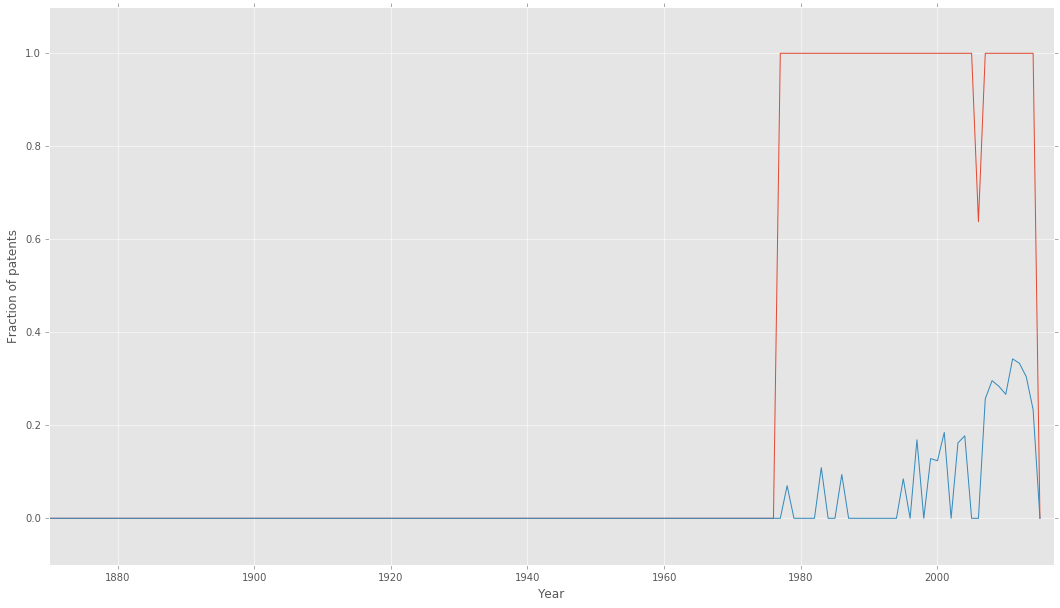

PT


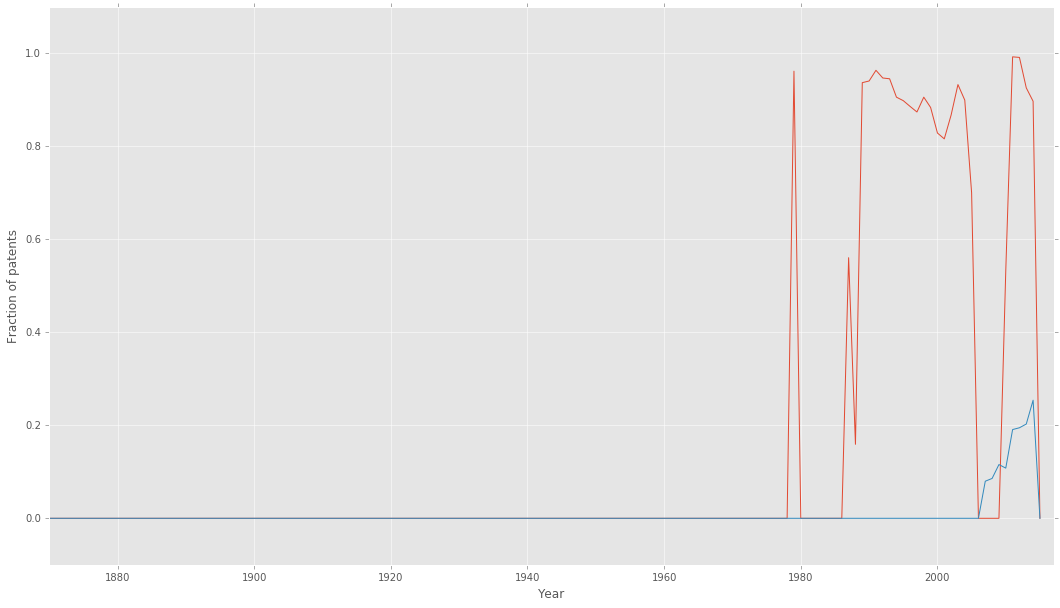

MA


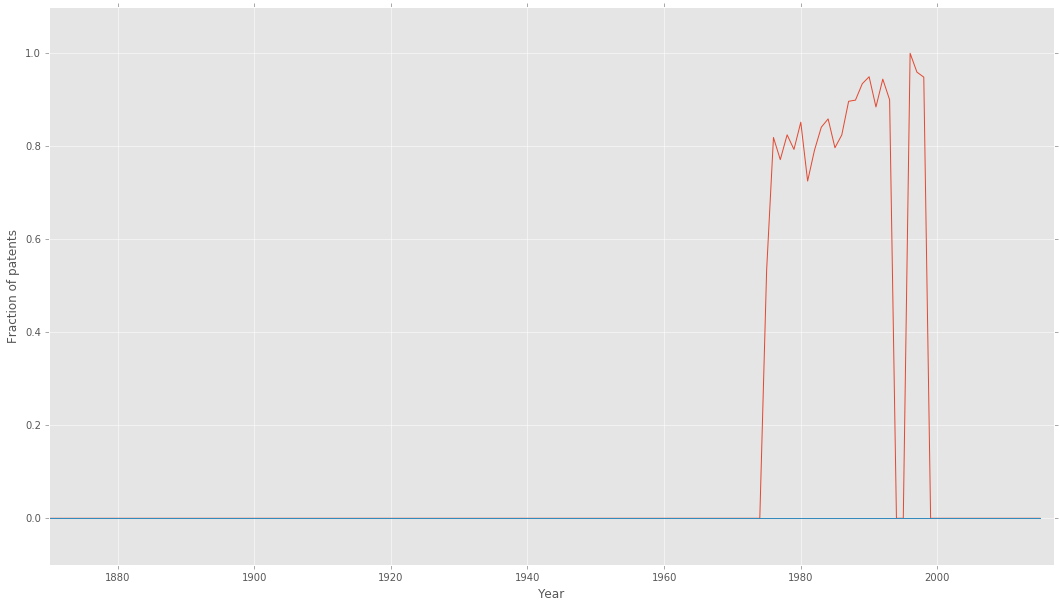

PH


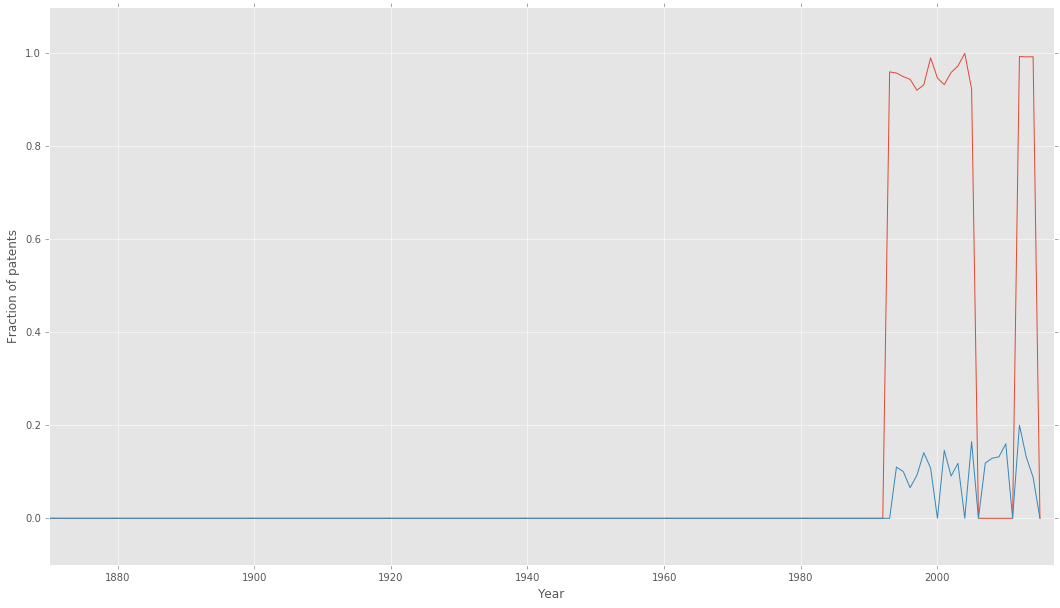

LV


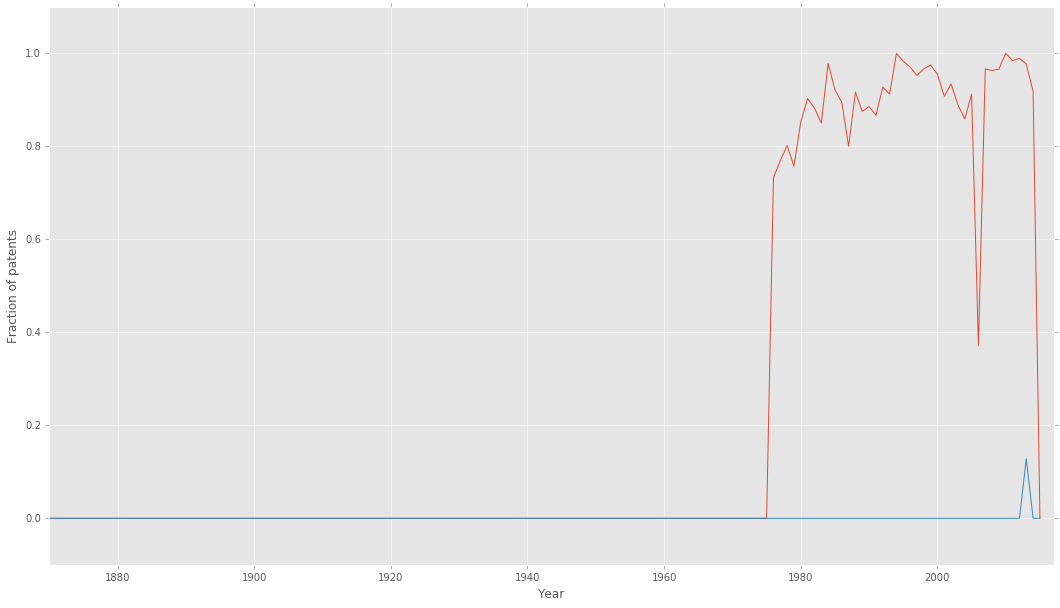

EG


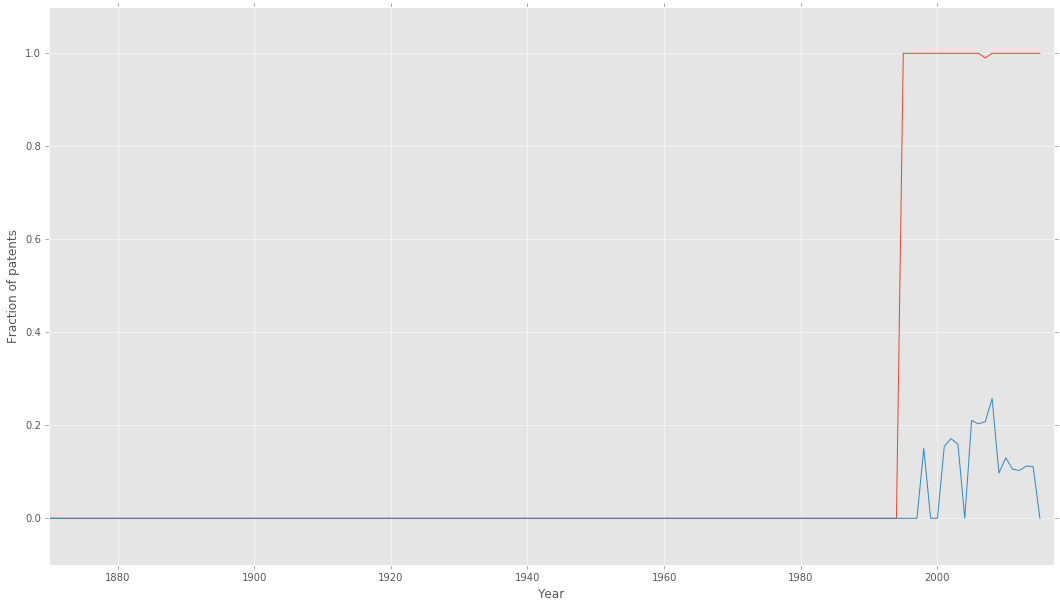

SK


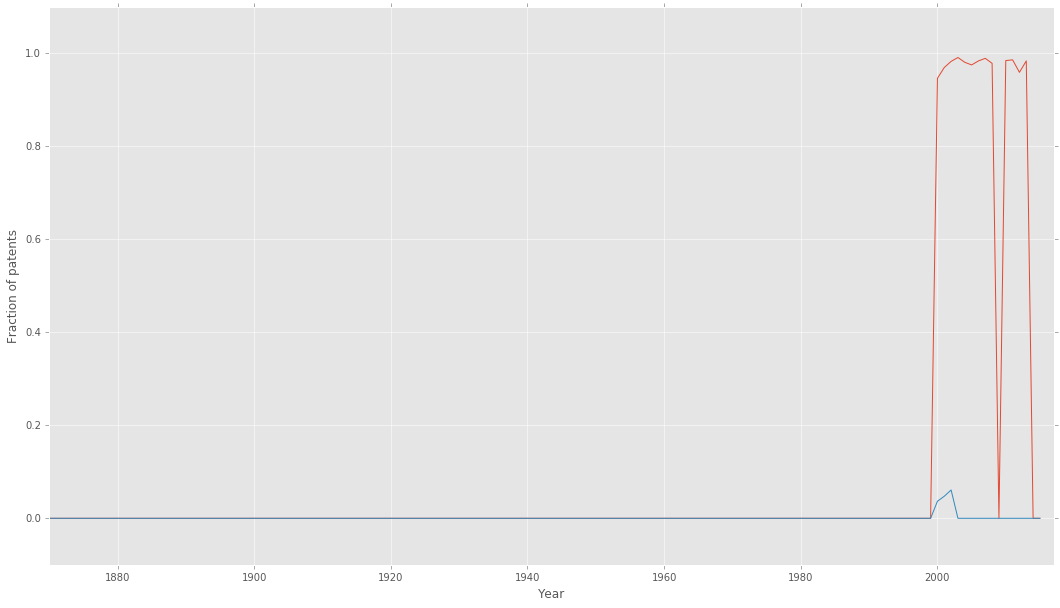

GE


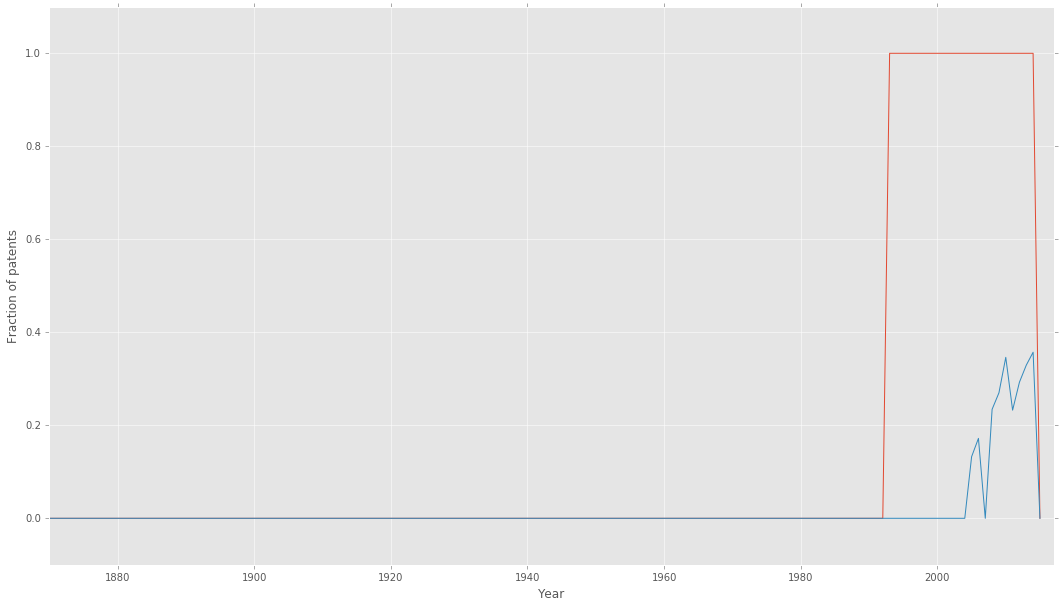

LT


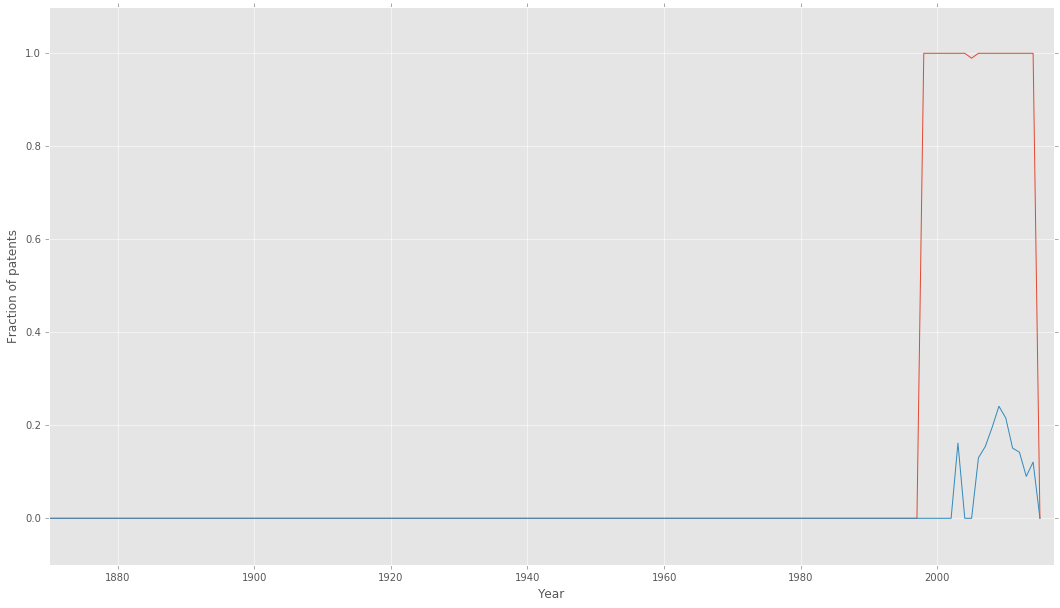

EA


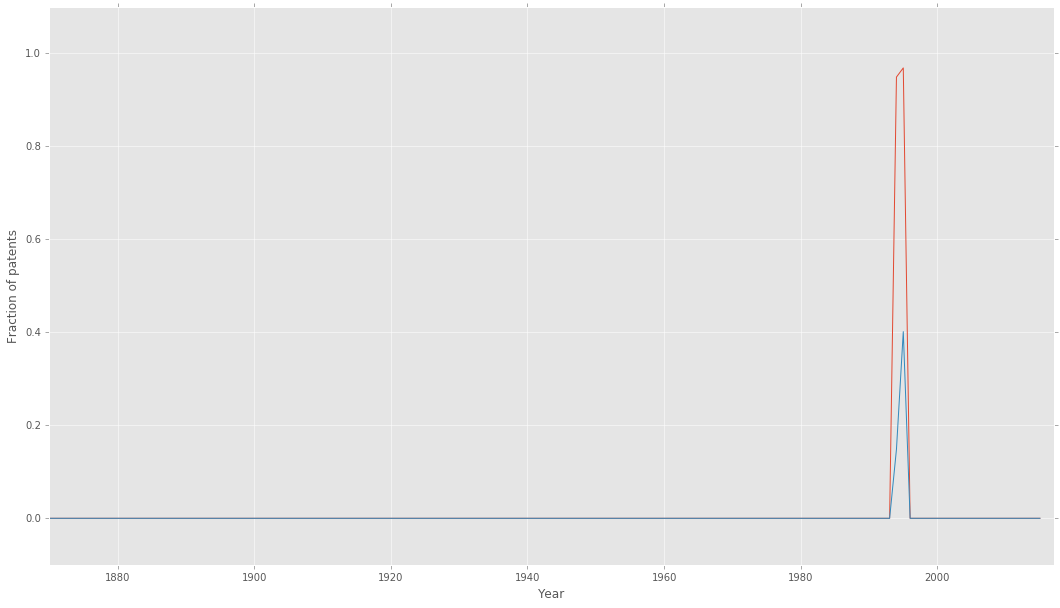

SG


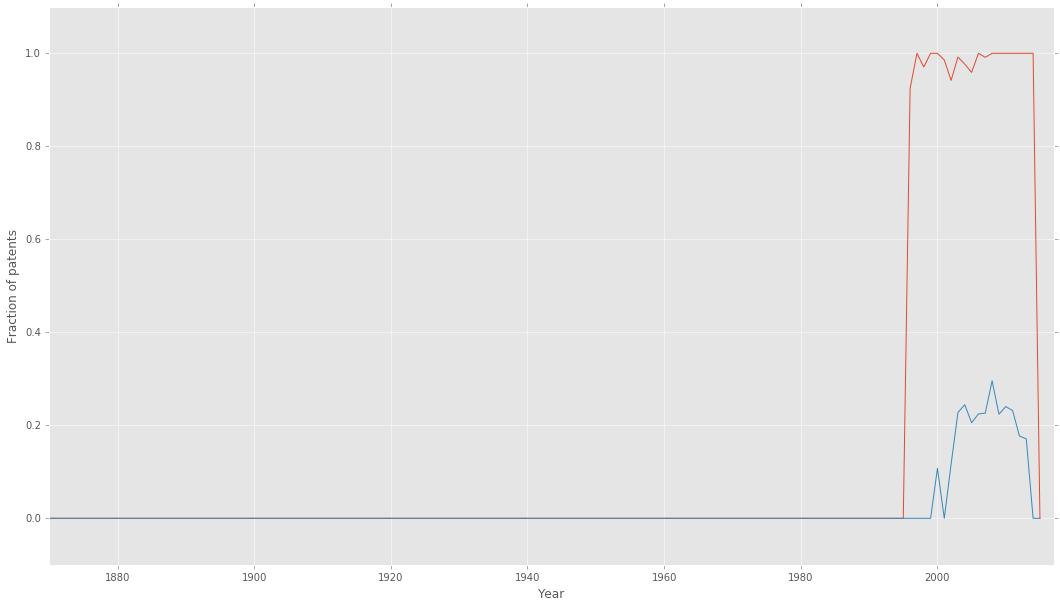

HR


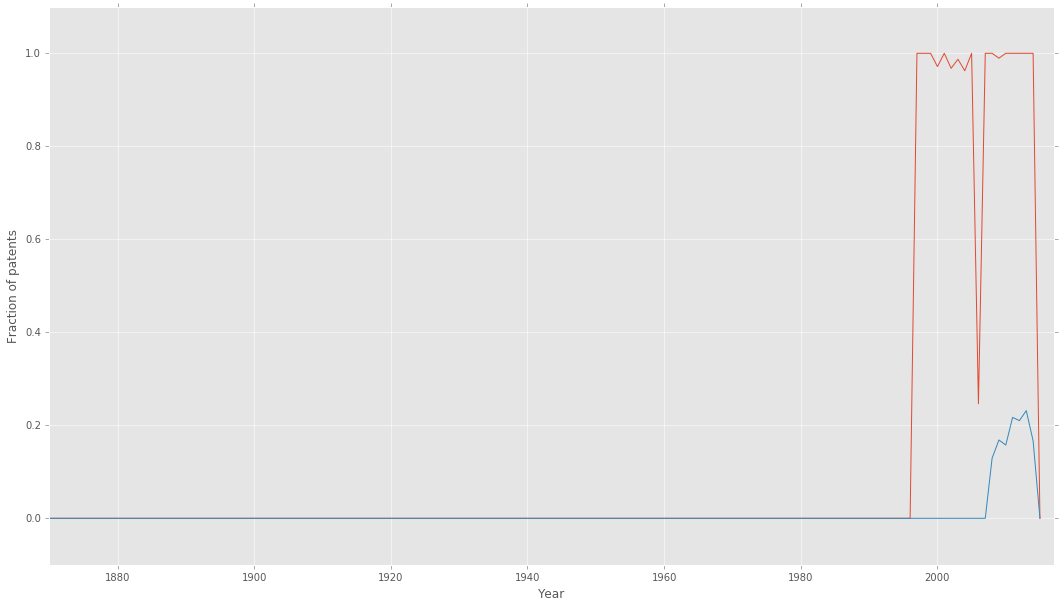

EE


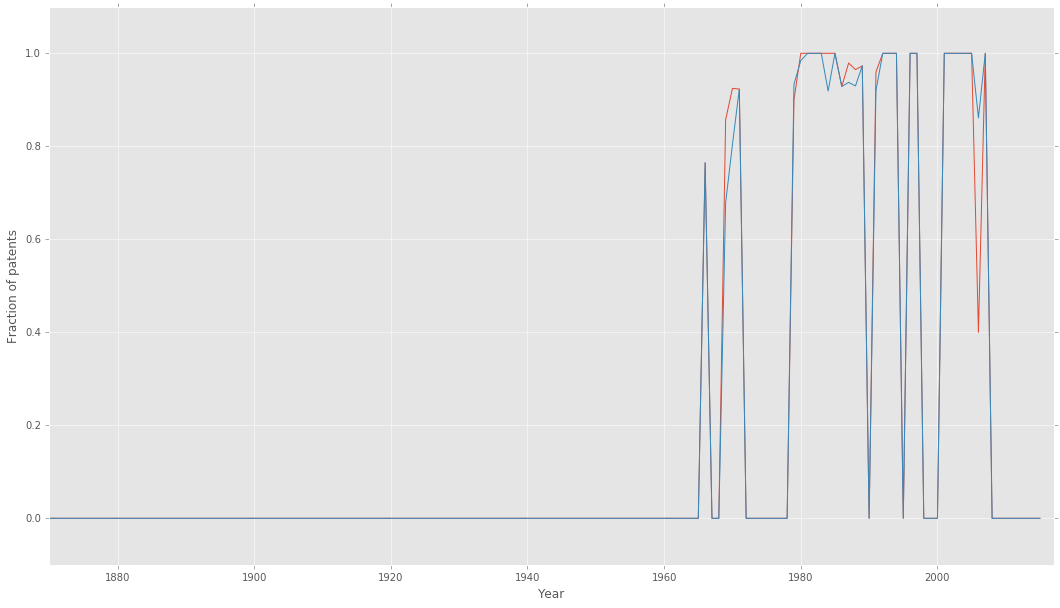

OA


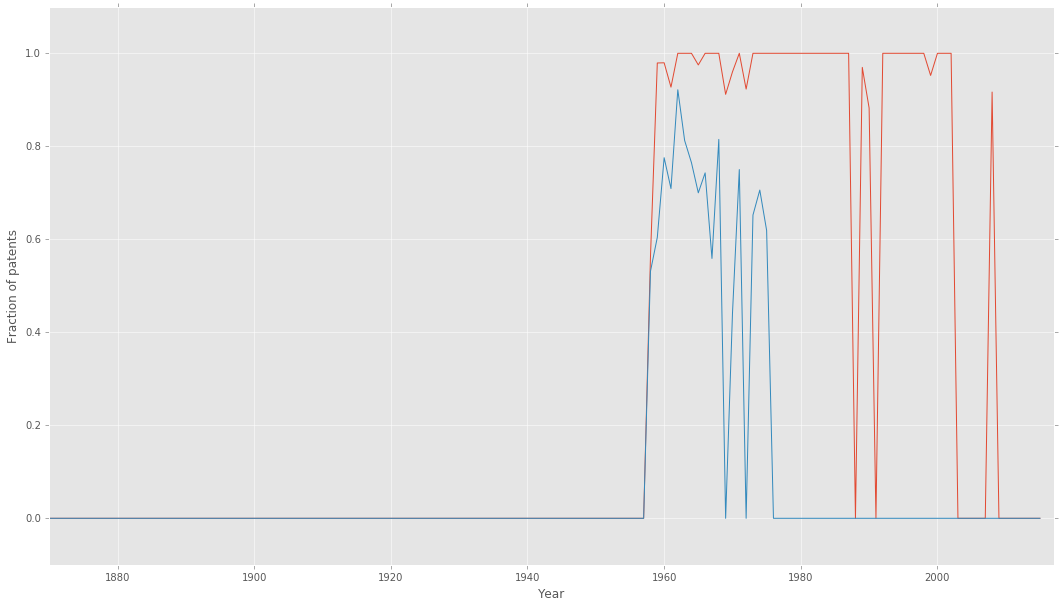

MC


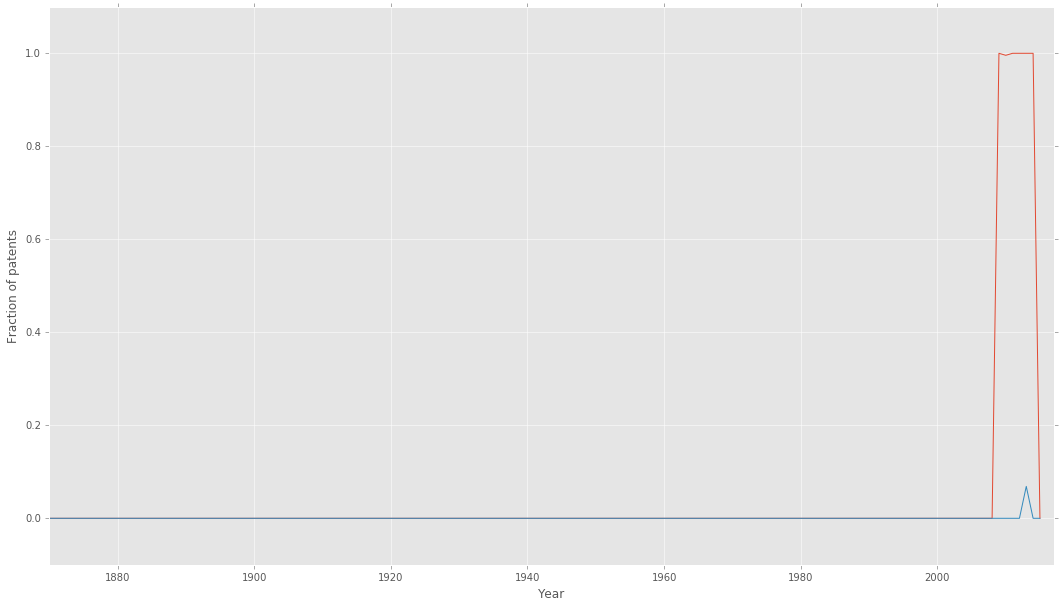

MD


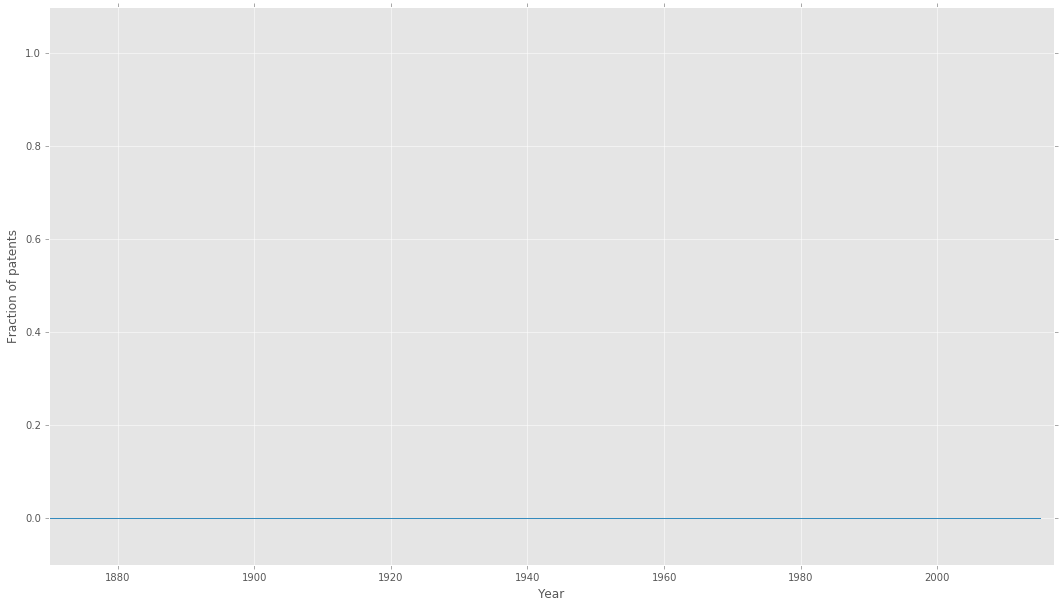

JO


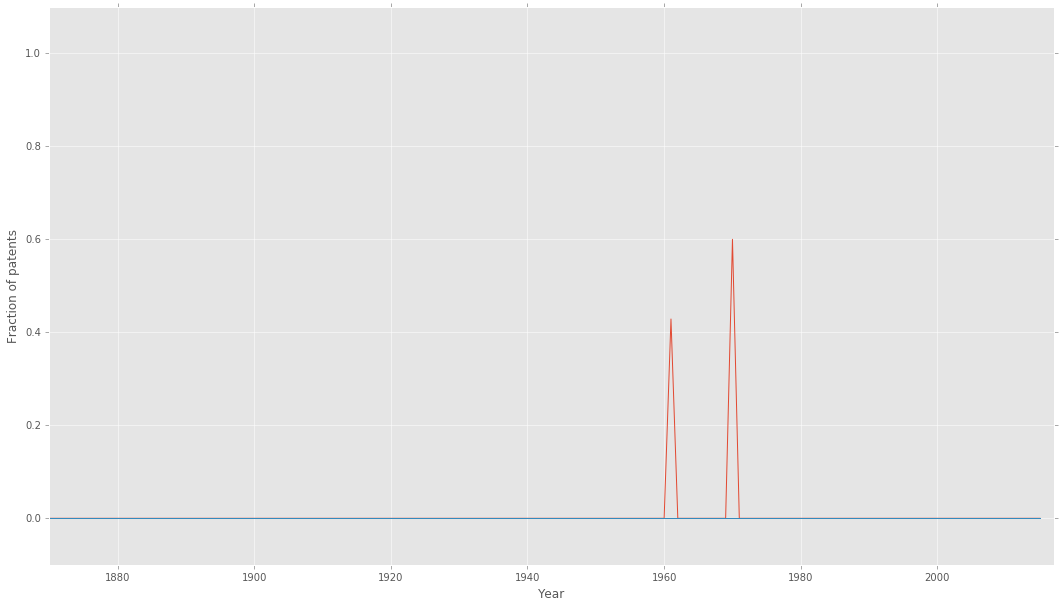

IS


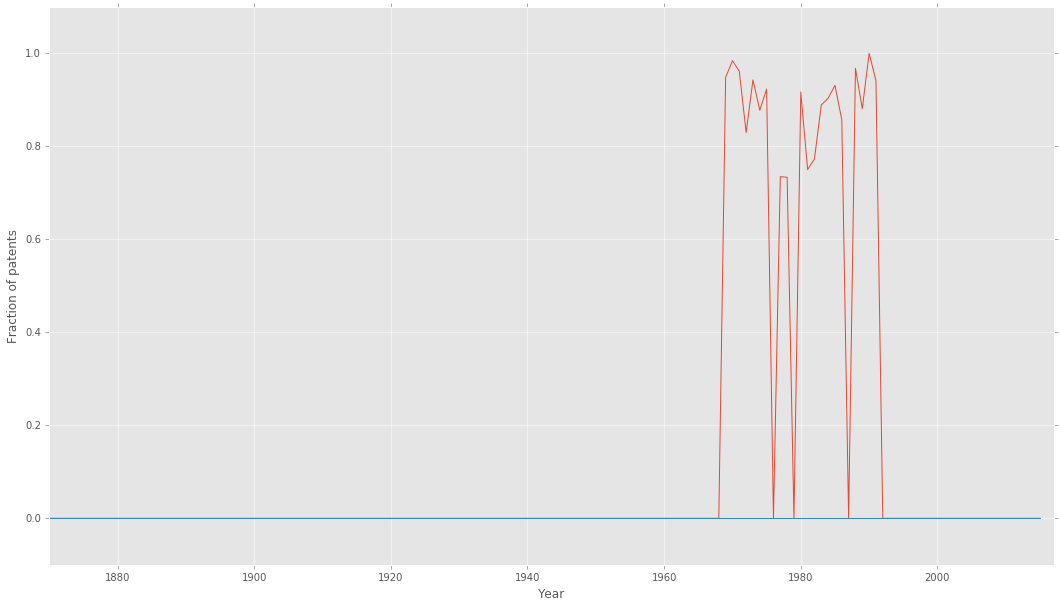

ZM


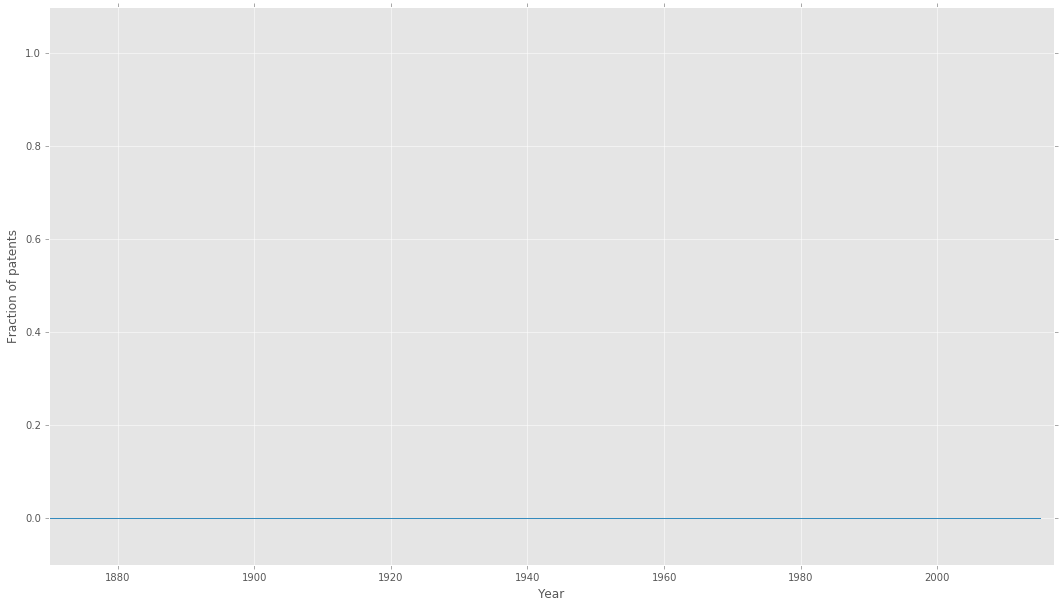

SM


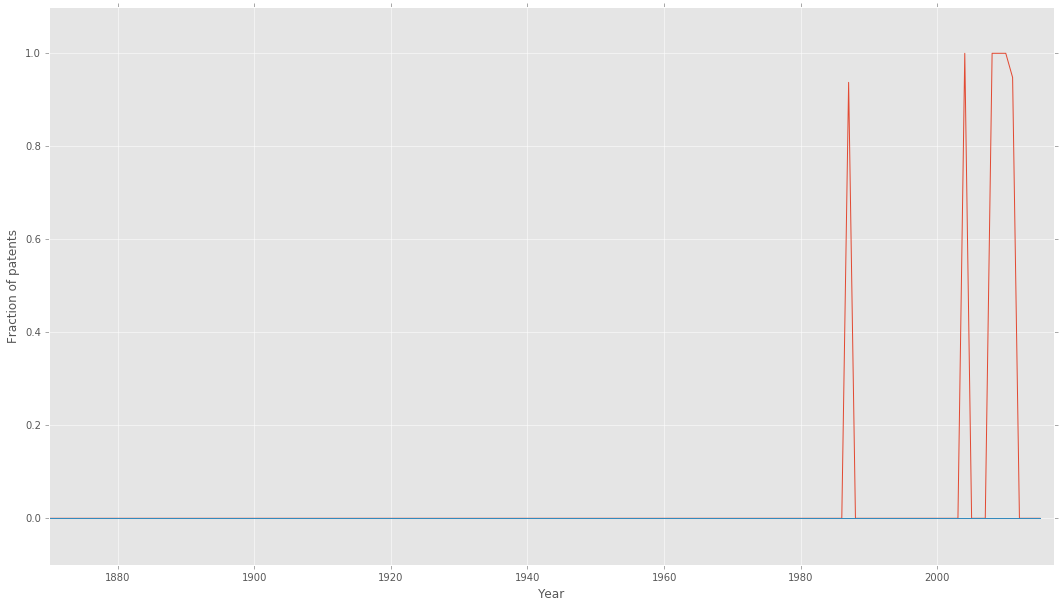

CU


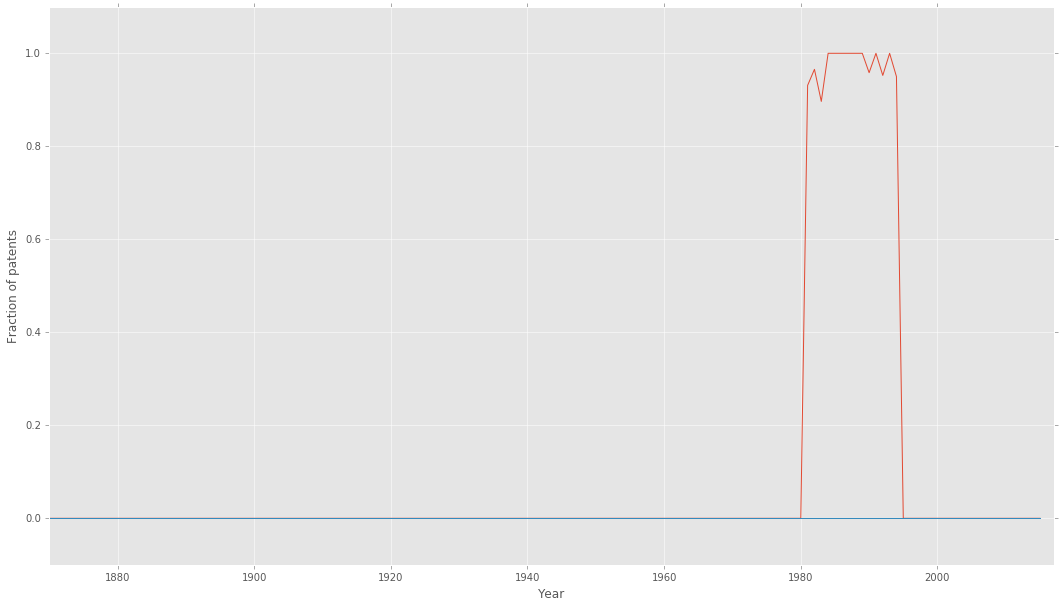

ZW


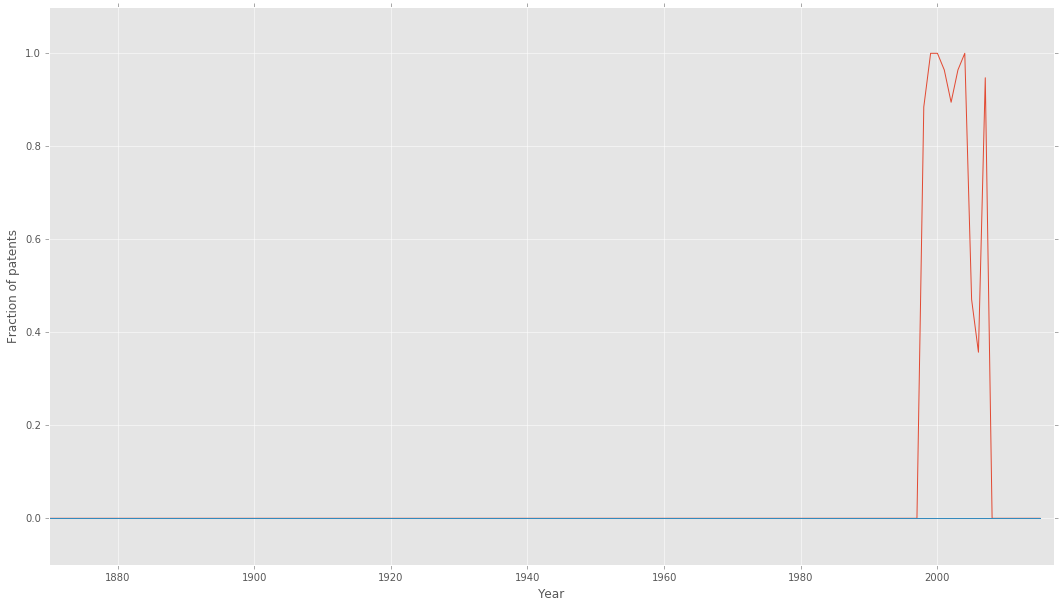

TJ


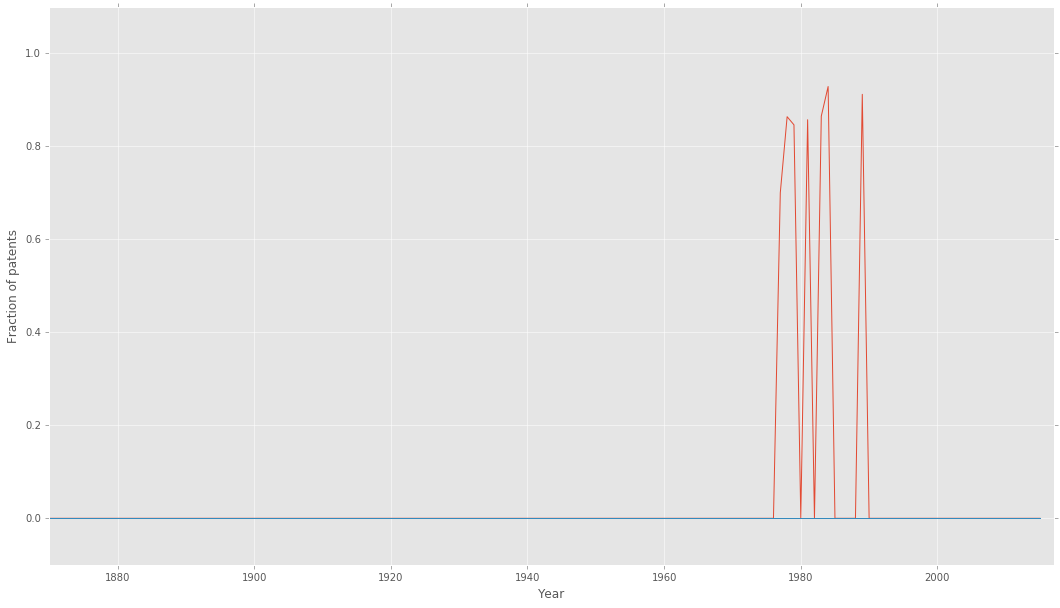

MN


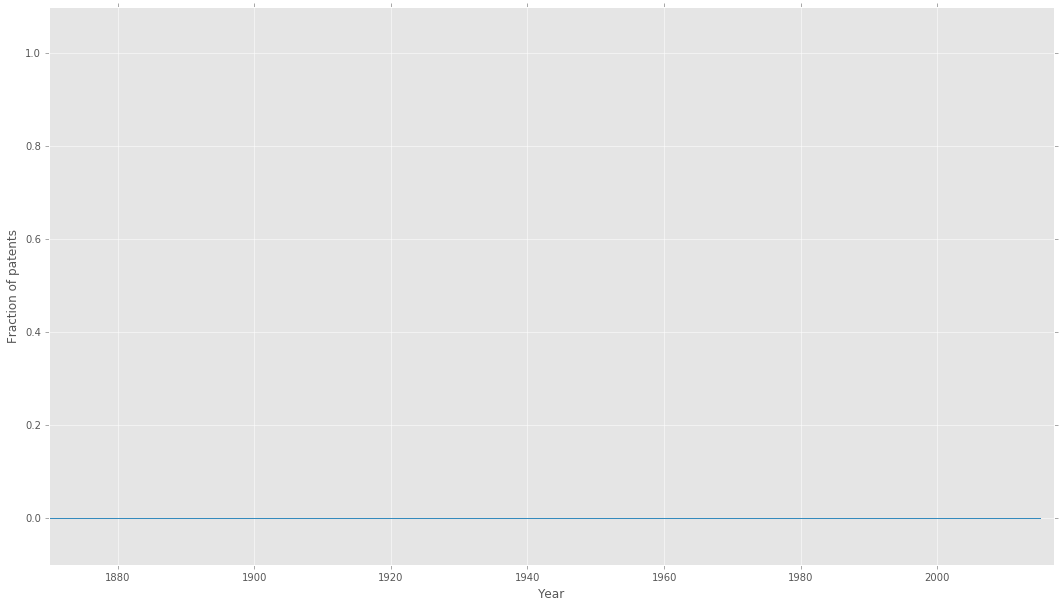

MT


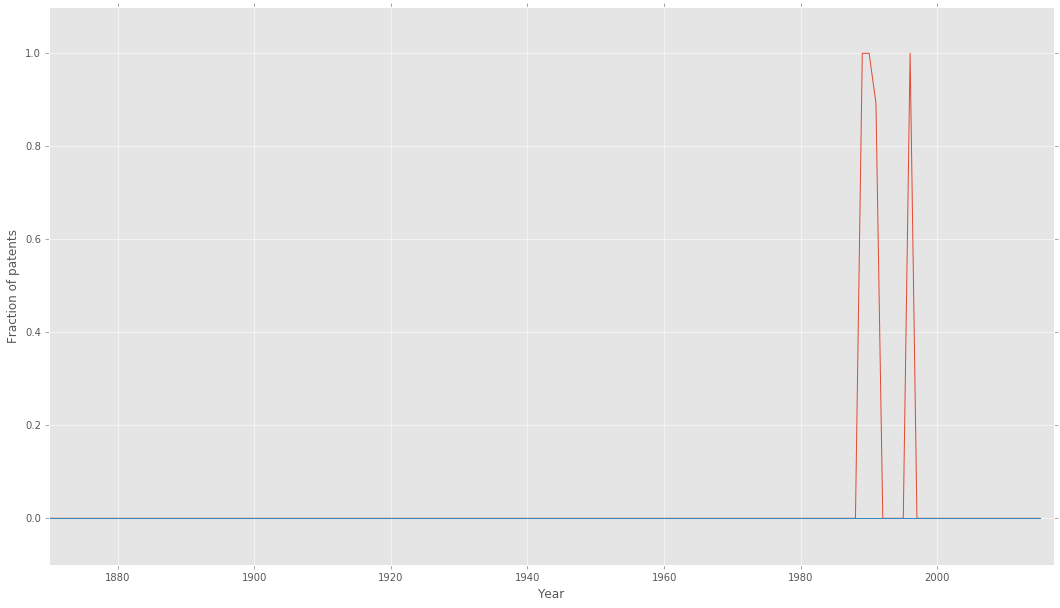

VN


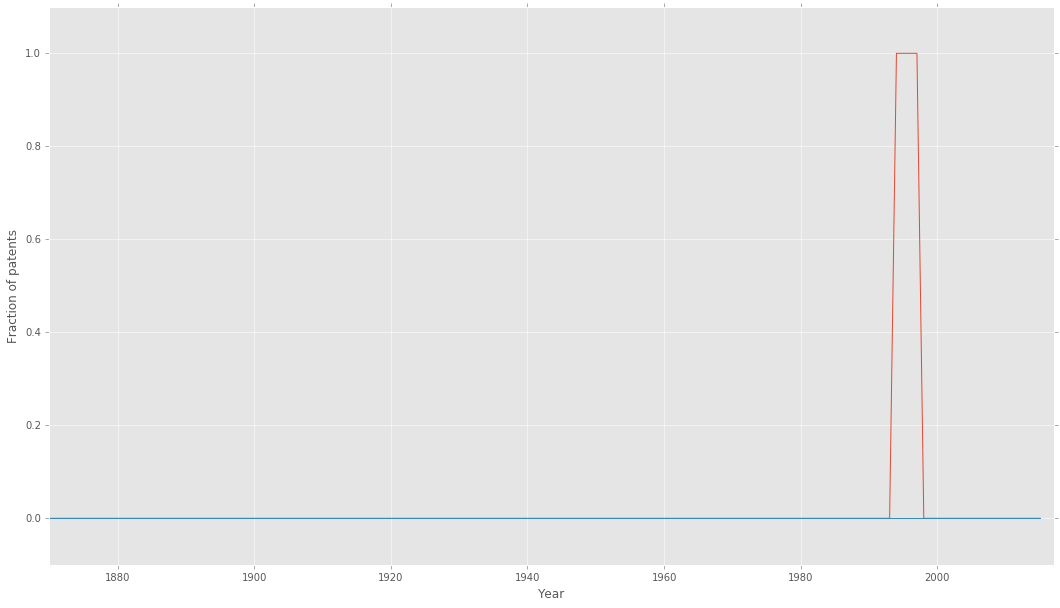

HK


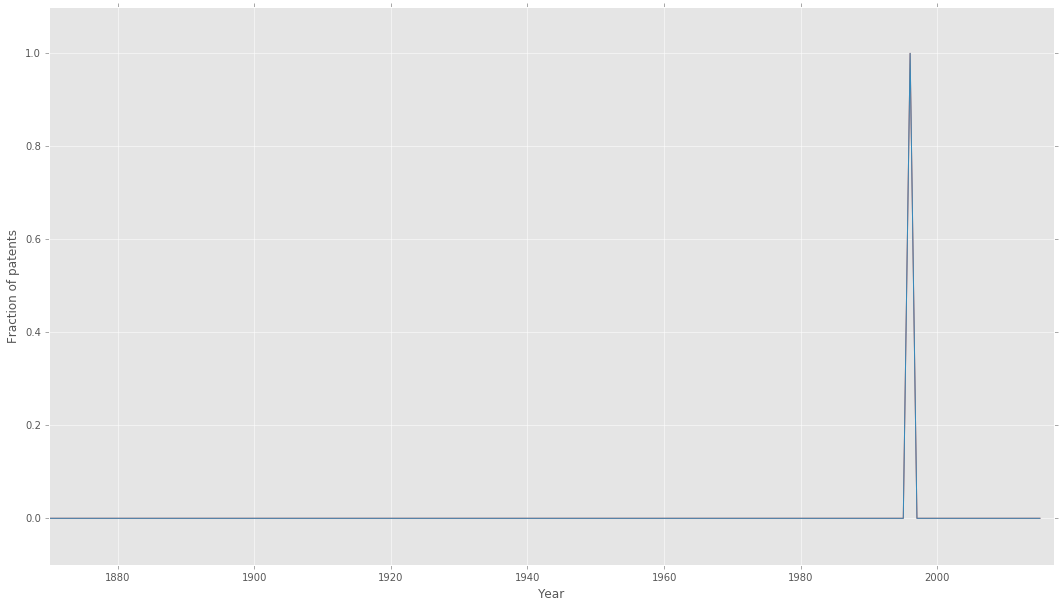

AP


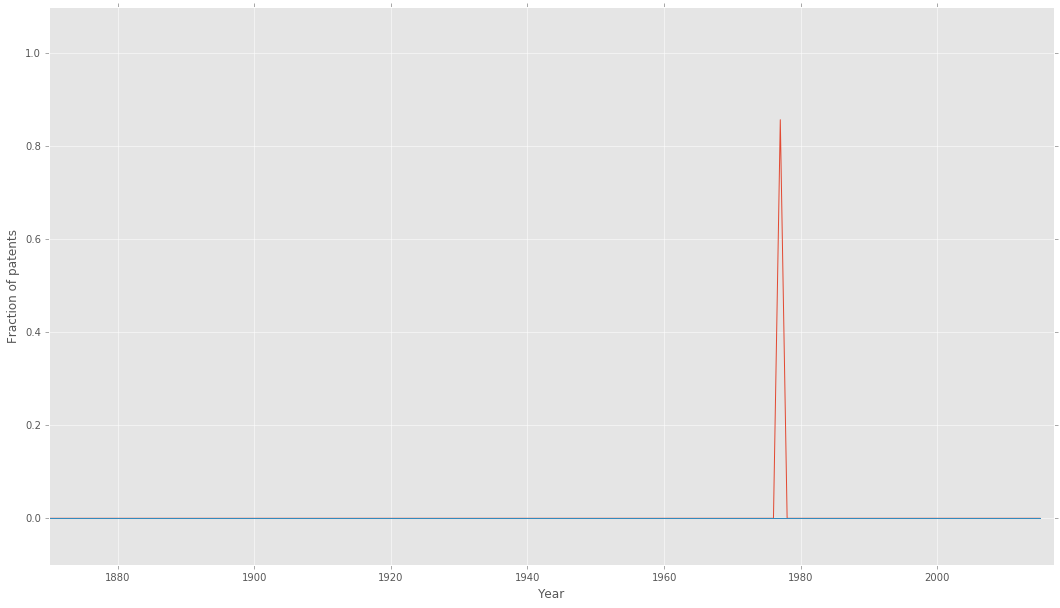

MW


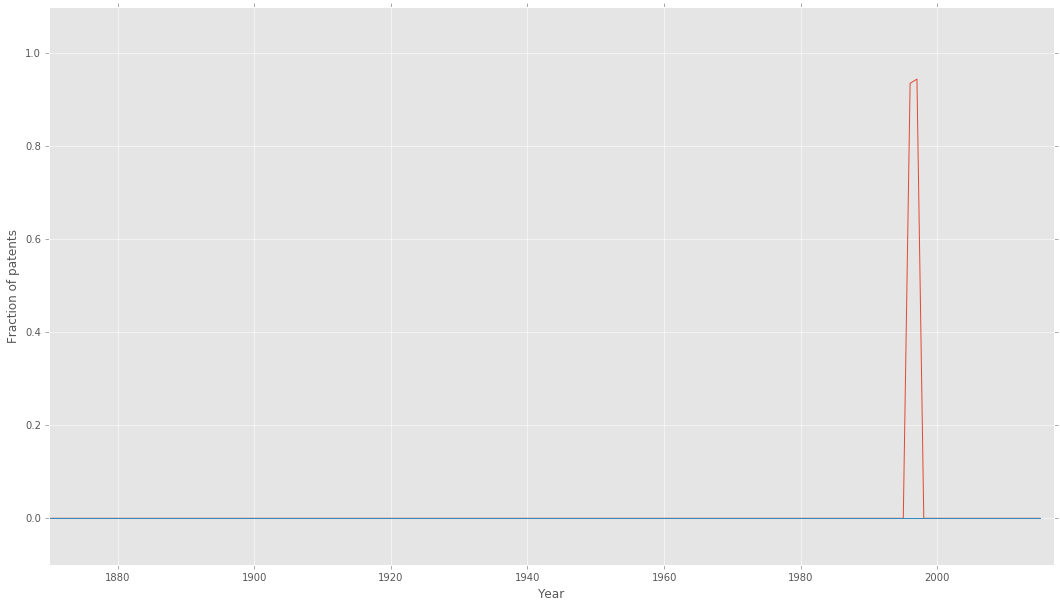

ID


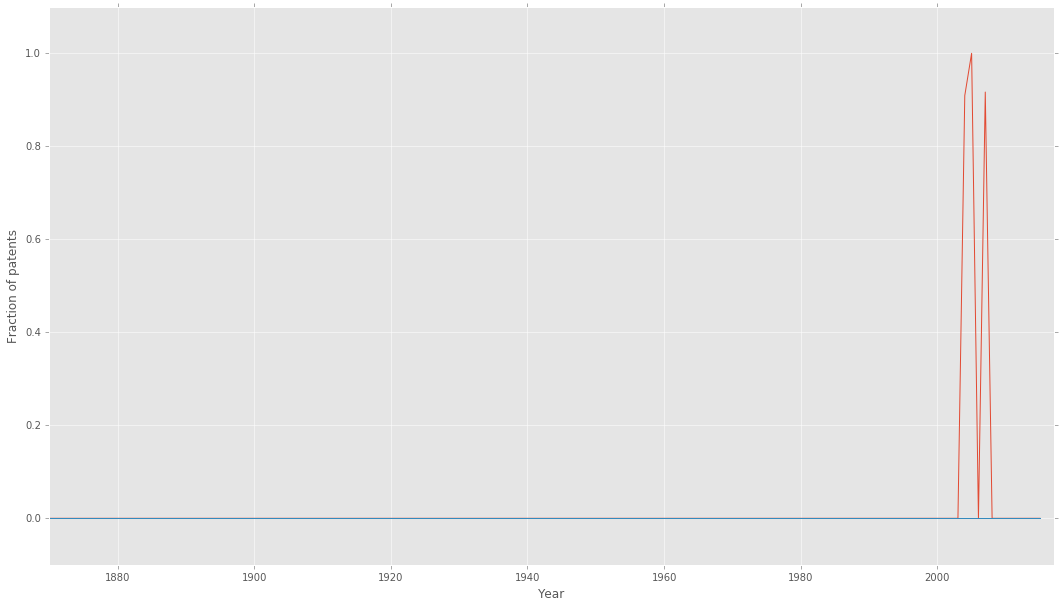

GC


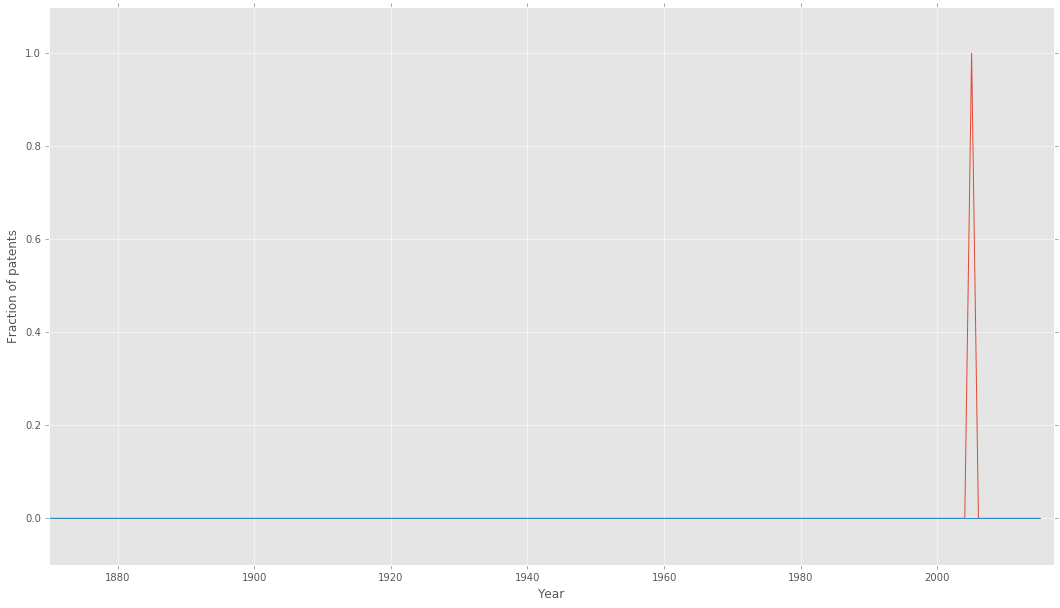

CL


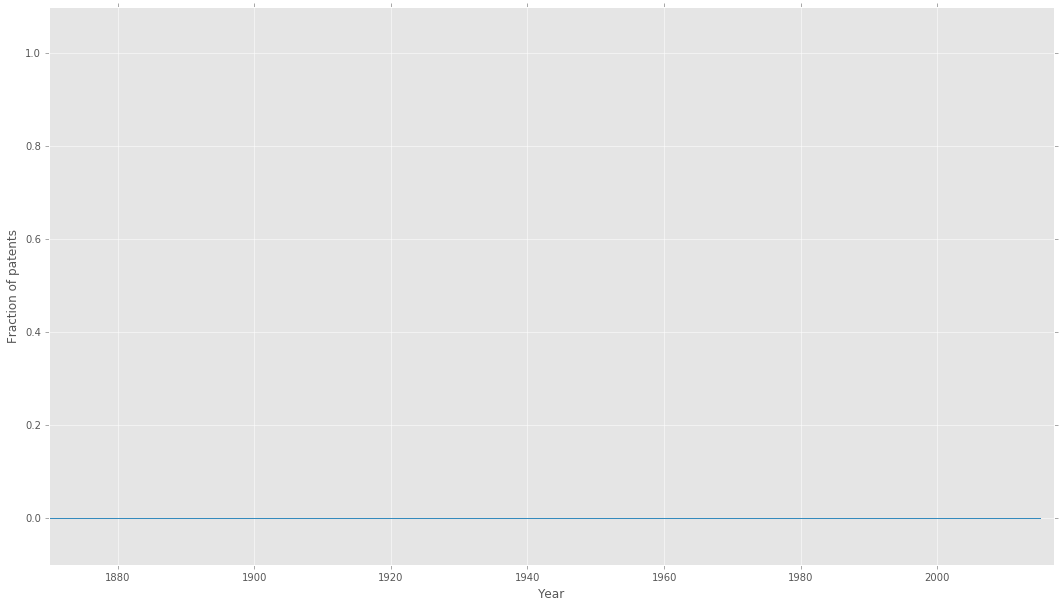

BY


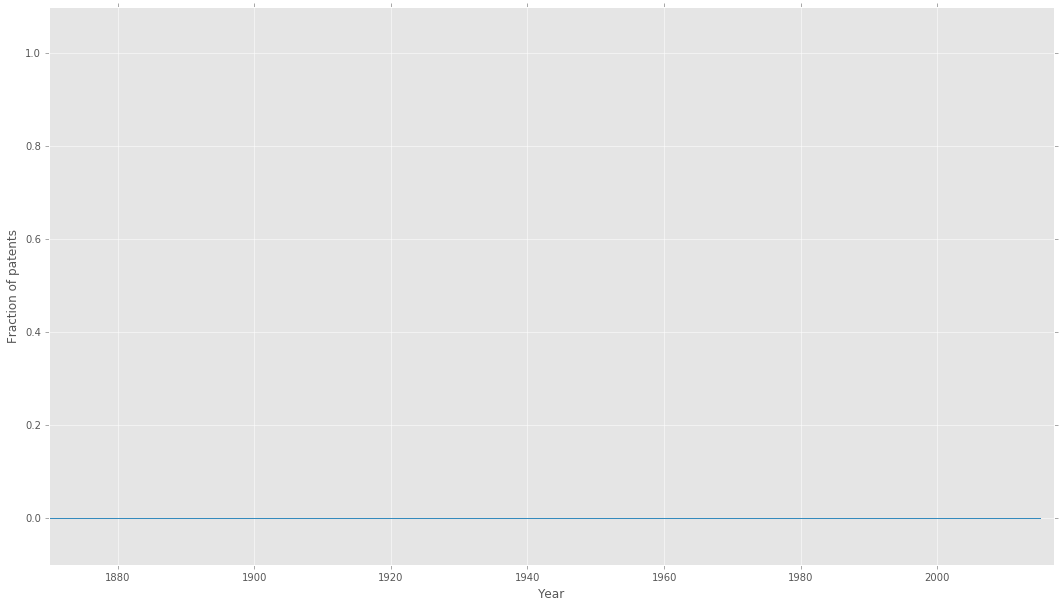

KE


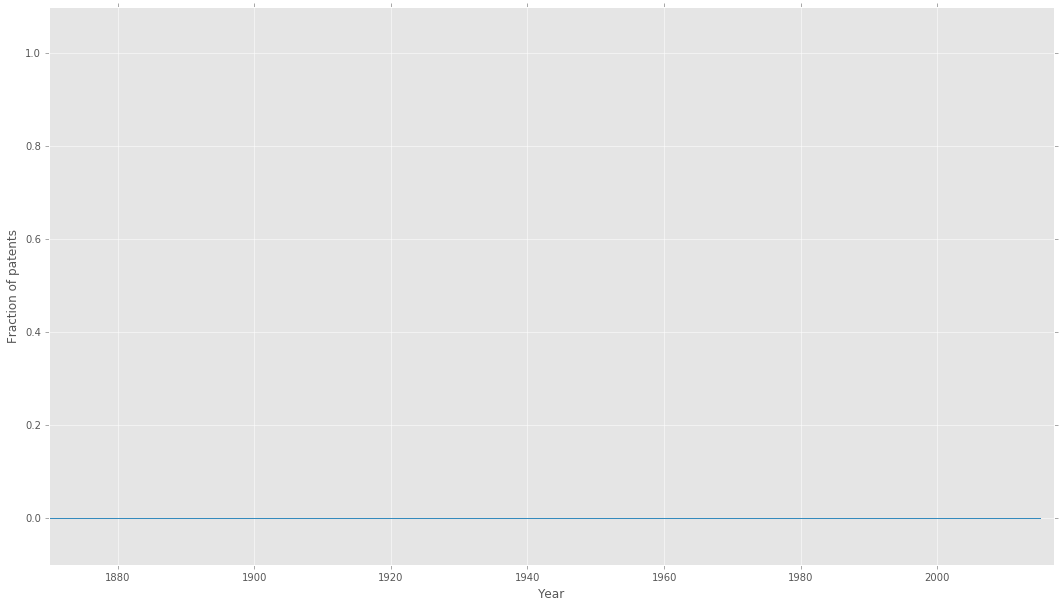

NI


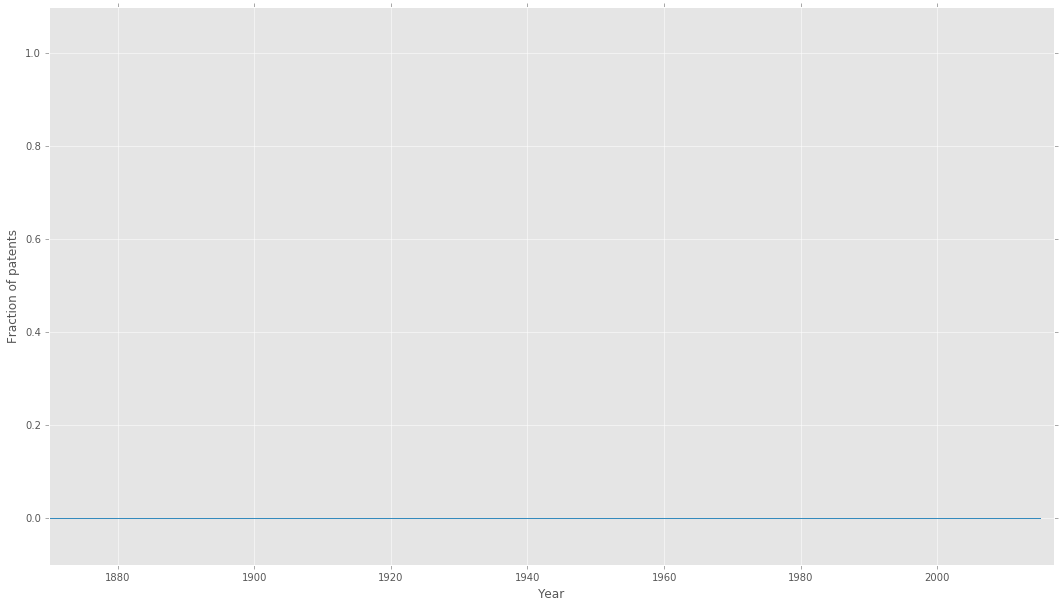

BA


In [44]:
# For ALL indivudually

for auth in auth_by_size:
    df_au_year_frac_10_pv.frac_ipc[auth].plot(figsize=(18,10), label='ipc') # RED
    df_au_year_frac_10_pv.frac_cpc[auth].plot(figsize=(18,10)) # BLUE
    plt.xlim(1870,yr_min_max_plt[1])
    plt.ylim(-0.1, 1.1)

    plt.xlabel("Year")
    plt.ylabel('Fraction of patents')
    plt.show()

    print auth

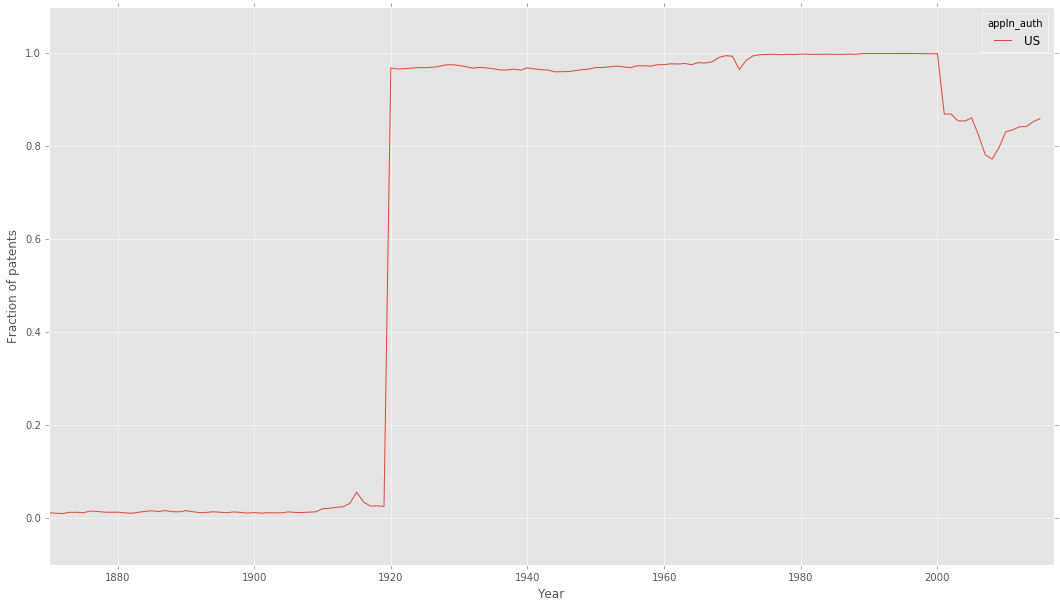

In [45]:
# For top 10

df_au_year_frac_pv.frac_ipc[auth_by_size[0:1]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

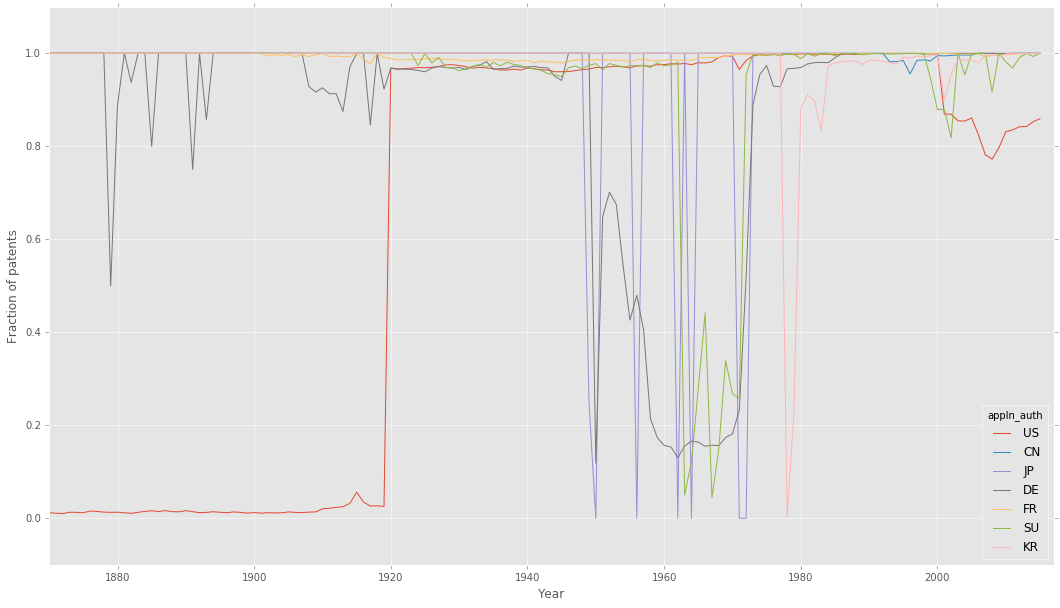

In [46]:
# For top 6 Auths

df_au_year_frac_pv.frac_ipc[auth_by_size[0:7]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

## Checking CPC Classfications By Auth
[to top](#Table-of-Contents)

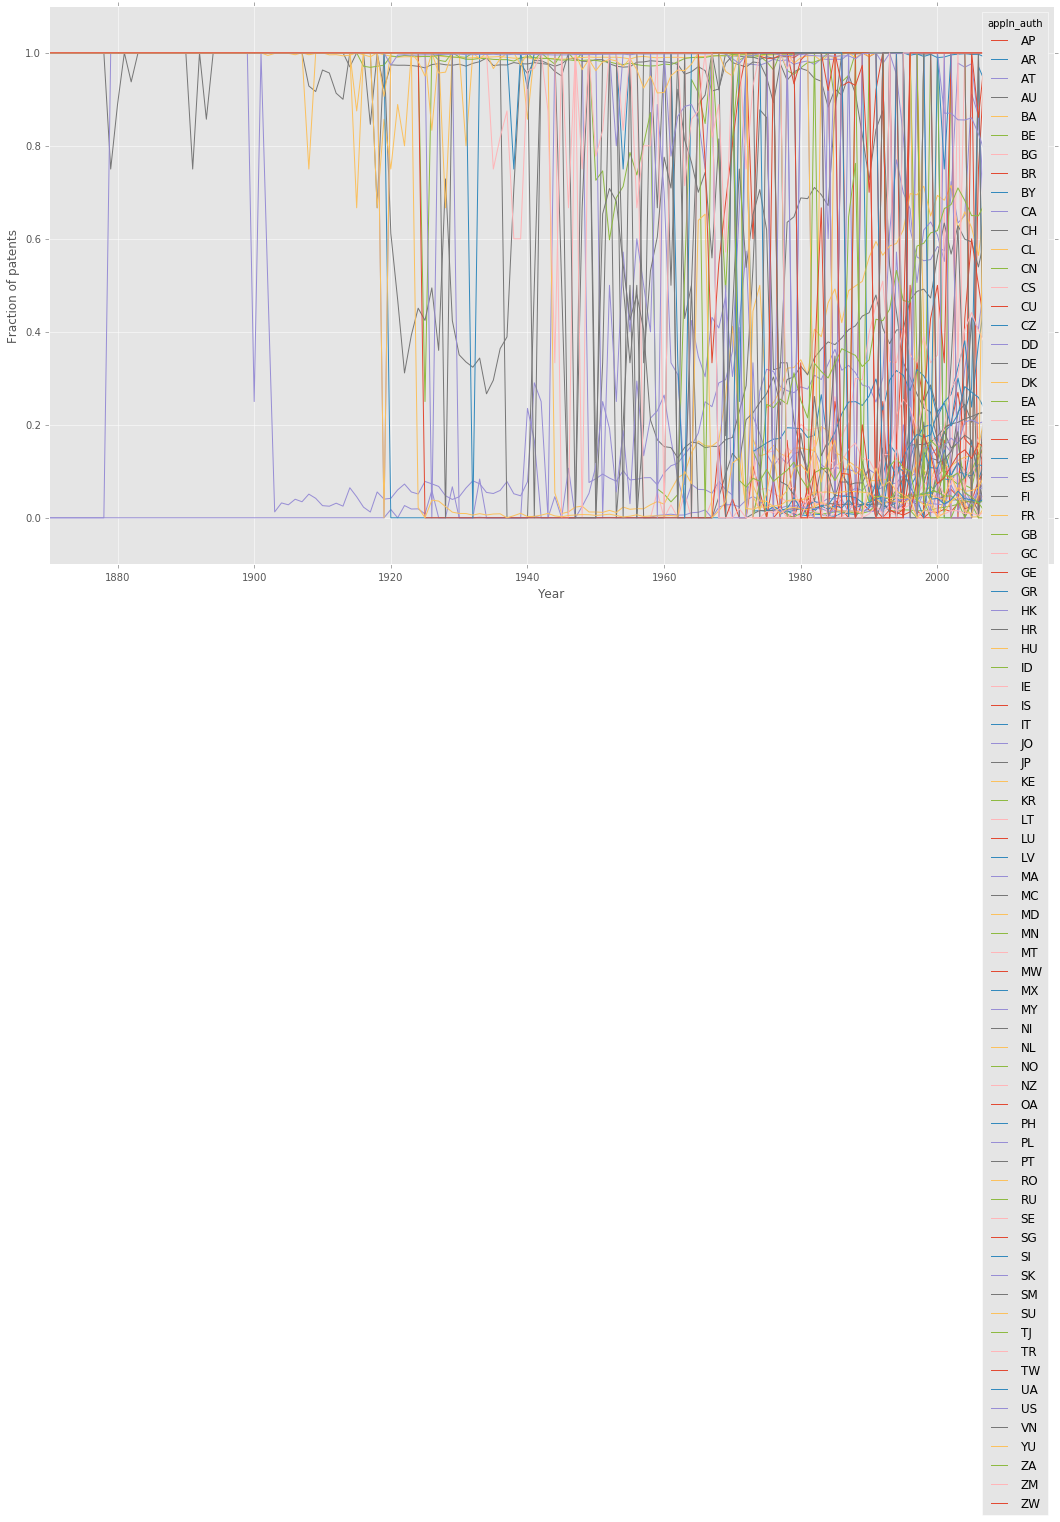

In [47]:
# For all Auths

df_au_year_frac_pv.frac_cpc.plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

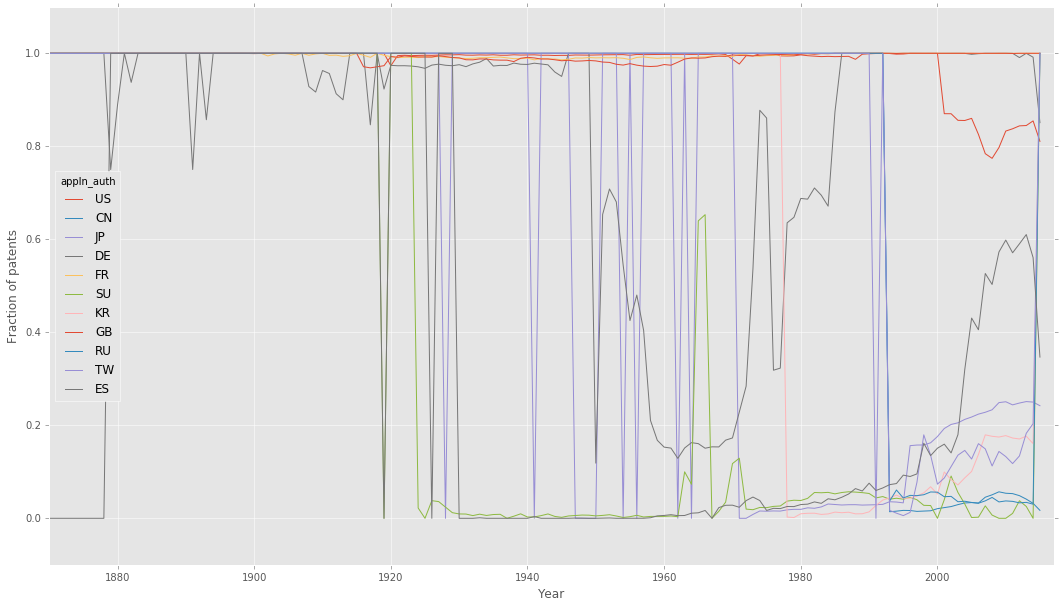

In [48]:
# For top 10 Auths

df_au_year_frac_pv.frac_cpc[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

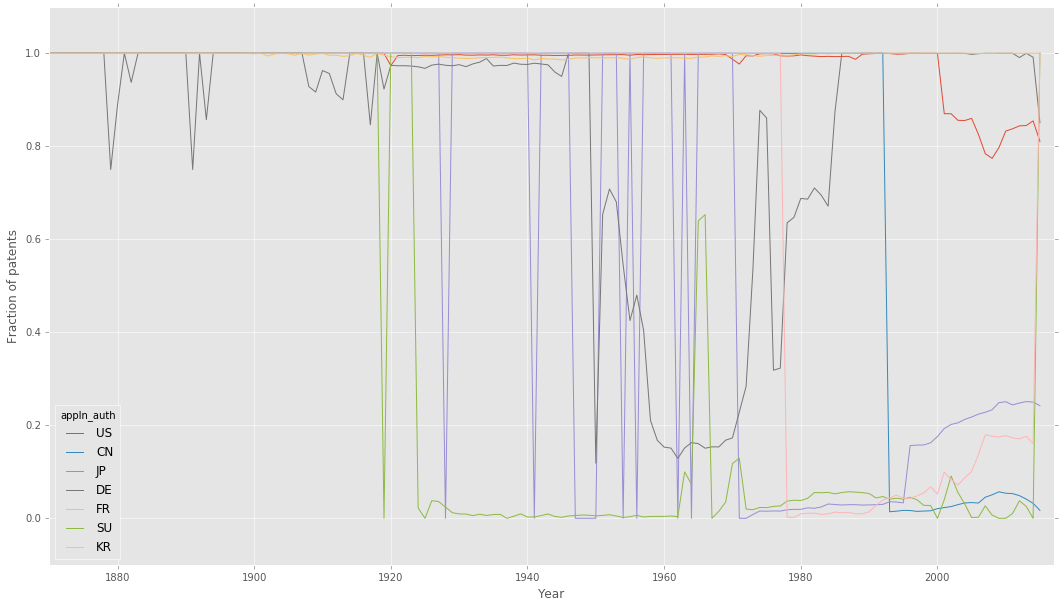

In [49]:
# For top 6 Auths

df_au_year_frac_pv.frac_cpc[auth_by_size[0:7]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

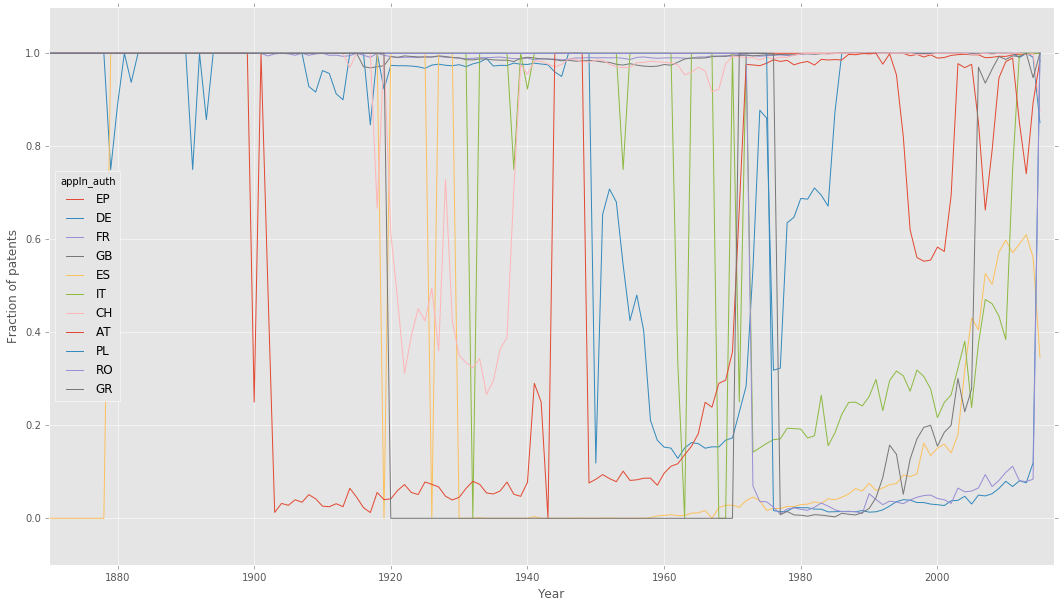

In [50]:
# For top 10 EU

df_au_year_frac_pv.frac_cpc[eu_auths[0:11]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

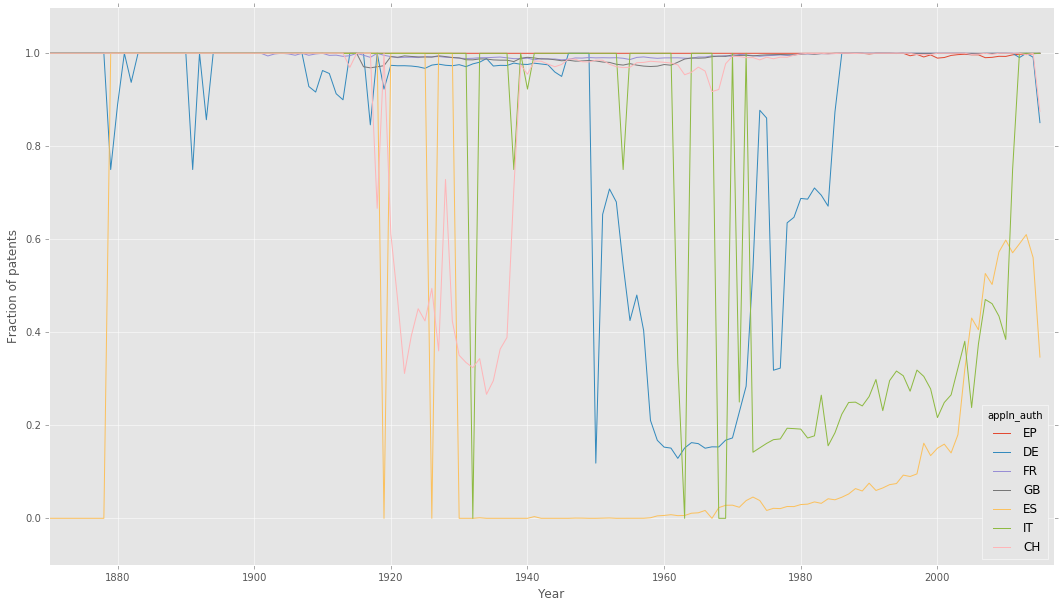

In [51]:
# For top 6 EU

df_au_year_frac_pv.frac_cpc[eu_auths[0:7]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')